# Functions, libraries, settings

In [1]:
#Libraries

import numpy as np
import pandas as pd 
from netCDF4 import Dataset
import netCDF4
import xarray as xr
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.util as cutil
import cartopy.crs as ccrs
import nc_time_axis
import dask
# from utilities_CESM2_NorESM2_v1_1_decomposition import *
# from utilities_CESM2_NorESM2_v1_1 import *
from RAMIP_FWI_utilities import *
from fwdp import computeFireWeatherIndices
from matplotlib.patches import Rectangle

import datetime
from datetime import timedelta
import sys
from os import listdir
from datetime import datetime
import cftime
import zarr

from time import time
import regionmask


In [ ]:
# def season_mean(ds, calendar="noleap"):
#     """
#     Calculate weighted seasonal means taking into account the number of days in each month.
    
#     Parameters:
#     ds (xarray.DataArray): Input data with a time dimension
#     calendar (str): Calendar type, default is "noleap"
    
#     Returns:
#     xarray.DataArray: Seasonal means weighted by the number of days in each month
#     """
#     # Make a DataArray with the number of days in each month, size = len(time)
#     month_length = ds.time.dt.days_in_month

#     # Calculate the weights by grouping by 'time.season'
#     weights = (
#         month_length.groupby("time.season") / month_length.groupby("time.season").sum()
#     )

#     # Test that the sum of the weights for each season is 1.0
#     np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

#     # Calculate the weighted average with skipna=True
#     seasonal = (ds * weights).groupby("time.season").sum(dim="time", skipna=True)
    
#     # Reorder seasons
#     season_order = ['DJF', 'MAM', 'JJA', 'SON']
#     return seasonal.reindex(season=season_order)

In [2]:
# (3) Weighted horizontal average
def weighted_horizontal_avg(da, ensemble = True, time = True):
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    if ensemble == True and time == True:
        if "member" in da.dims:
            weighted_mean = da_weighted.mean(("lon", "lat", "member", "time"))
        elif "model" in da.dims:
            weighted_mean = da_weighted.mean(("lon", "lat", "model", "time"))
    elif ensemble == True and time == False:
        if "member" in da.dims:
            weighted_mean = da_weighted.mean(("lon", "lat", "member"))
        elif "model" in da.dims:
            weighted_mean = da_weighted.mean(("lon", "lat", "model"))
    elif ensemble == False and time == True:
        weighted_mean = da_weighted.mean(("lon", "lat", "time"))
    elif ensemble == False and time == False:
        weighted_mean = da_weighted.mean(("lon", "lat"))
    return weighted_mean

In [2]:
# # Default values
# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 22

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcdefaults()

# FWI Data

In [3]:
# Open FWI data

## NorESM2
NorESM2_global_FWI_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
)

NorESM2_historical_FWI = read_zarr('NorESM2-LM', 'historical', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(1961, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(1990, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

NorESM2_ssp370_FWI_2041_2050 = read_zarr('NorESM2-LM', 'ssp370', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

# NorESM2_global_hurs_FWI_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-126aer_hurs', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

# NorESM2_global_pr_FWI_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-126aer_pr', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

# NorESM2_global_sfcWind_FWI_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-126aer_sfcWind', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

# NorESM2_global_tasmax_FWI_2041_2050 = read_zarr('NorESM2-LM', 'ssp370-126aer_tasmax', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

## SPEAR
SPEAR_historical_FWI = read_zarr('SPEAR', 'historical', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(1961, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(1990, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

SPEAR_ssp370_FWI_2041_2050 = read_zarr('SPEAR', 'ssp370', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

SPEAR_global_FWI_2041_2050 = read_zarr('SPEAR', 'ssp370-126aer', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

SPEAR_global_hurs_FWI_2041_2050 = read_zarr('SPEAR', 'ssp370-126aer_hurs', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

SPEAR_global_pr_FWI_2041_2050 = read_zarr('SPEAR', 'ssp370-126aer_pr', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

SPEAR_global_sfcWind_FWI_2041_2050 = read_zarr('SPEAR', 'ssp370-126aer_sfcWind', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

SPEAR_global_tasmax_FWI_2041_2050 = read_zarr('SPEAR', 'ssp370-126aer_tasmax', 'FWI',
    start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
    end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
).interp(lat = NorESM2_global_FWI_2041_2050.lat, lon = NorESM2_global_FWI_2041_2050.lon)

# ## MRI-ESM2-0
# MRI_historical_FWI = read_zarr('MRI-ESM2-0', 'historical', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(1961, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(1990, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)

# MRI_ssp370_FWI_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)

# MRI_global_FWI_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-126aer', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)

# MRI_global_hurs_FWI_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-126aer_hurs', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)

# MRI_global_pr_FWI_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-126aer_pr', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)

# MRI_global_sfcWind_FWI_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-126aer_sfcWind', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)

# MRI_global_tasmax_FWI_2041_2050 = read_zarr('MRI-ESM2-0', 'ssp370-126aer_tasmax', 'FWI',
#     start_analysis = cftime.DatetimeNoLeap(2041, 1, 1, 12, 0, 0, 0, has_year_zero=True),
#     end_analysis = cftime.DatetimeNoLeap(2050, 12, 31, 12, 0, 0, 0, has_year_zero=True)
# ).interp(lat = MRI_global_FWI_2041_2050.lat, lon = MRI_global_FWI_2041_2050.lon)



In [ ]:
# # Concatenate from multiple models

# multi_historical_FWI = xr.concat([NorESM2_historical_FWI, SPEAR_historical_FWI, MRI_historical_FWI], dim="model")

# multi_ssp370_FWI = xr.concat([NorESM2_ssp370_FWI_2041_2050, SPEAR_ssp370_FWI_2041_2050, MRI_ssp370_FWI_2041_2050], dim="model")
# multi_global_FWI = xr.concat([NorESM2_global_FWI_2041_2050, SPEAR_global_FWI_2041_2050, MRI_global_FWI_2041_2050], dim="model")

# multi_global_tasmax_FWI = xr.concat([NorESM2_global_tasmax_FWI_2041_2050, SPEAR_global_tasmax_FWI_2041_2050, MRI_global_tasmax_FWI_2041_2050], dim="model")
# multi_global_pr_FWI = xr.concat([NorESM2_global_pr_FWI_2041_2050, SPEAR_global_pr_FWI_2041_2050, MRI_global_pr_FWI_2041_2050], dim="model")
# multi_global_hurs_FWI = xr.concat([NorESM2_global_hurs_FWI_2041_2050, SPEAR_global_hurs_FWI_2041_2050, MRI_global_hurs_FWI_2041_2050], dim="model")
# multi_global_sfcWind_FWI = xr.concat([NorESM2_global_sfcWind_FWI_2041_2050, SPEAR_global_sfcWind_FWI_2041_2050, MRI_global_sfcWind_FWI_2041_2050], dim="model")



In [4]:
# Compute values into memory

historical_FWI = SPEAR_historical_FWI.compute()
print(f"historical_FWI is ready")

ssp370_FWI = SPEAR_ssp370_FWI_2041_2050.compute()
print(f"ssp370_FWI is ready")
global_FWI = SPEAR_global_FWI_2041_2050.compute()
print(f"global_FWI is ready")
global_hurs_FWI = SPEAR_global_hurs_FWI_2041_2050.compute()
print(f"global_hurs_FWI is ready")
global_pr_FWI = SPEAR_global_pr_FWI_2041_2050.compute()
print(f"global_pr_FWI is ready")
global_sfcWind_FWI = SPEAR_global_sfcWind_FWI_2041_2050.compute()
print(f"global_sfcWind_FWI is ready")
global_tasmax_FWI = SPEAR_global_tasmax_FWI_2041_2050.compute()
print(f"global_tasmax_FWI is ready")


historical_FWI is ready
ssp370_FWI is ready
global_FWI is ready
global_hurs_FWI is ready
global_pr_FWI is ready
global_sfcWind_FWI is ready
global_tasmax_FWI is ready


In [ ]:
# # Compute values into memory

# historical_FWI = multi_historical_FWI.compute()
# print(f"historical_FWI is ready")

# ssp370_FWI = multi_ssp370_FWI.compute()
# print(f"ssp370_FWI is ready")
# global_FWI = multi_global_FWI.compute()
# print(f"global_FWI is ready")

# global_tasmax_FWI = multi_global_tasmax_FWI.compute()
# print(f"global_tasmax_FWI is ready")
# global_pr_FWI = multi_global_pr_FWI.compute()
# print(f"global_pr_FWI is ready")
# global_hurs_FWI = multi_global_hurs_FWI.compute()
# print(f"global_hurs_FWI is ready")
# global_sfcWind_FWI = multi_global_sfcWind_FWI.compute()
# print(f"global_sfcWind_FWI is ready")


NameError: name 'multi_historical_FWI' is not defined

In [5]:
# Read file containing fraction of PFT type
da_mask = xr.open_dataset("/home/persad_users/vsu66/Research/EDF/b.e21.BSSP370cmip6.f09_g17.LE2-1231.001.clm2.h3.PCT_NAT_PFT.20950101-21001231.nc")
da_masked = NorESM2_global_FWI_2041_2050
da_mask = da_mask.interp(coords={"lat":da_masked.lat.values, "lon":da_masked.lon.values})

# Load the predefined AR6 land regions
ar6_regions = regionmask.defined_regions.ar6.land

# Create a mask for your model's latitude and longitude
mask = ar6_regions.mask(da_masked)


# PDF development and trial

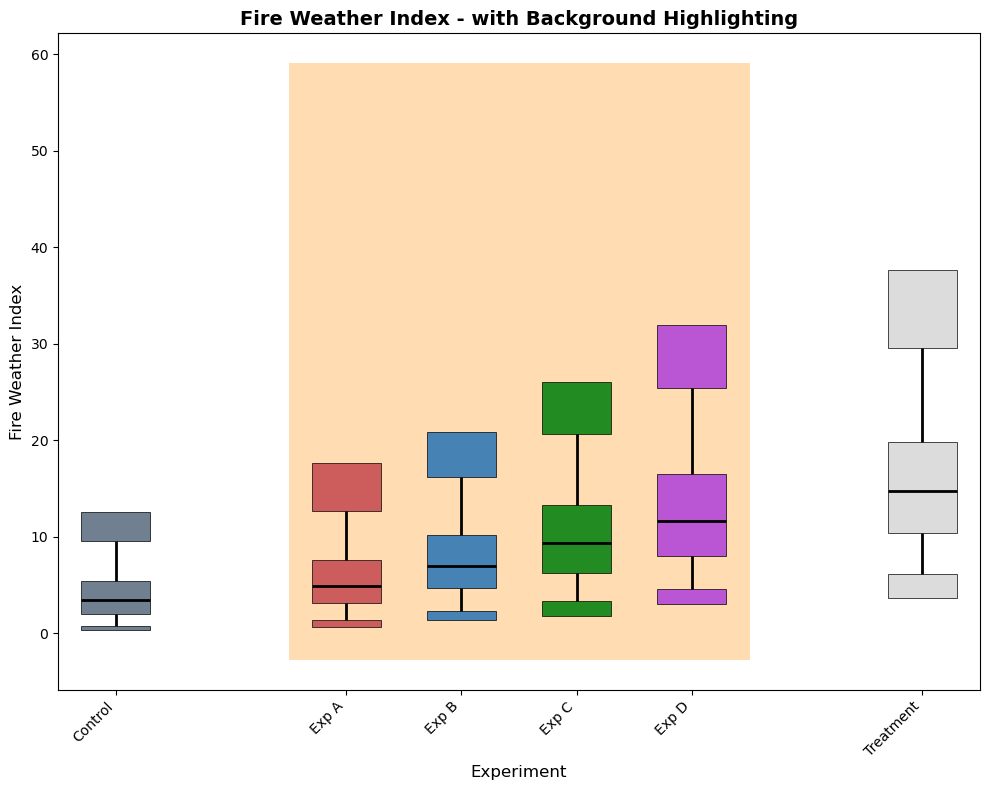

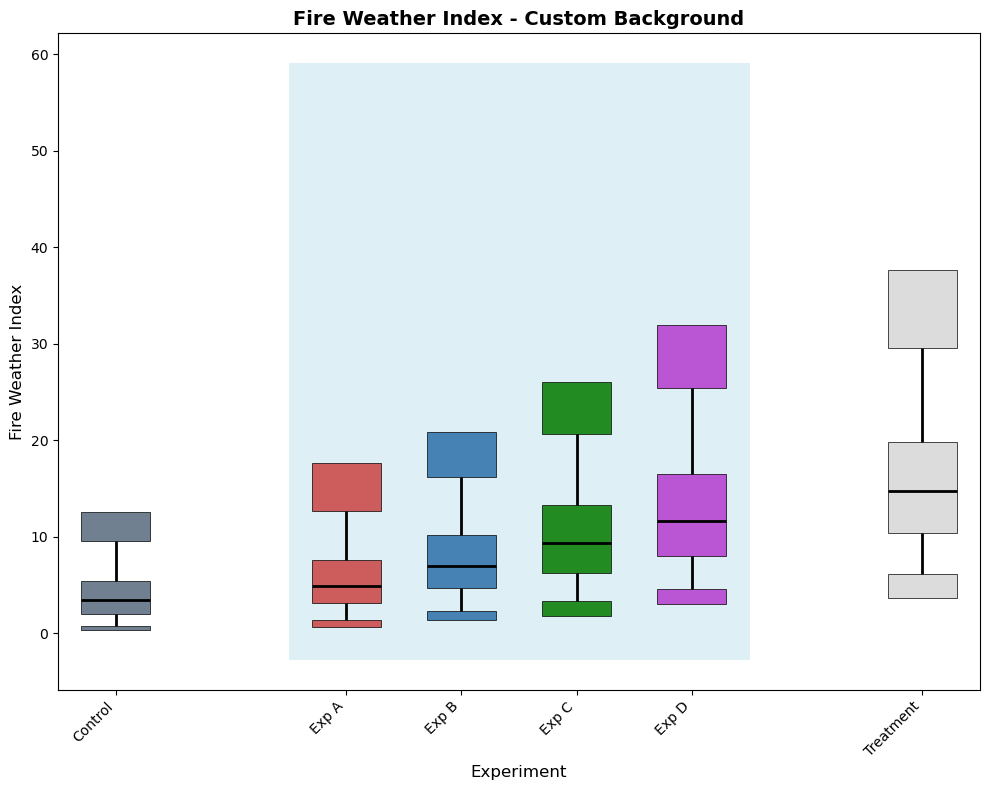

In [6]:
# Alternative function with more control over spacing
def create_fwi_boxplots_custom_spacing(data_arrays, labels=None, colors=None, 
                                     title="Fire Weather Index Distribution", 
                                     ylabel="Fire Weather Index", figsize=(10, 8),
                                     spacing_pattern="isolated_ends"):
    """
    Create box plots with custom spacing between box plots
    
    Parameters:
    -----------
    spacing_pattern : str
        "isolated_ends" - gaps before first and after last box
        "grouped_middle" - first box isolated, middle 4 grouped, last box isolated
        "custom" - use custom positions
    """
    
    # Default labels and colors
    if labels is None:
        labels = [f"Region {i+1}" for i in range(len(data_arrays))]
    if colors is None:
        colors = ['slategrey', 'indianred', 'steelblue', 'forestgreen', 'mediumorchid', 'gainsboro']
    
    # Extract data from DataArrays and flatten to 1D
    data_list = []
    for da in data_arrays:
        flattened_data = da.values.flatten()
        clean_data = flattened_data[~np.isnan(flattened_data)]
        data_list.append(clean_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define custom positions based on spacing pattern
    if spacing_pattern == "isolated_ends" and len(data_list) == 6:
        # Pattern: Box1 | gap | Box2-Box3-Box4-Box5 | gap | Box6
        positions = [1, 3, 4, 5, 6, 8]
    elif spacing_pattern == "custom" and len(data_list) == 6:
        # Define your own custom positions here
        positions = [1, 2.5, 3.5, 4.5, 5.5, 7]  # Customize as needed
    else:
        # Default equal spacing
        positions = list(range(1, len(data_list) + 1))
    
    # Add background color for middle four box plots if using isolated_ends pattern
    if spacing_pattern == "isolated_ends" and len(data_list) == 6:
        # Get the y-axis limits to span the full height
        # We'll calculate this after we know the data range
        all_data = np.concatenate([data for data in data_list])
        y_min = np.min(all_data)
        y_max = np.max(all_data)
        
        # Add some padding to the background
        y_padding = (y_max - y_min) * 0.05
        
        # Background rectangle covering the middle 4 box plots (positions 3-6)
        middle_positions = positions[1:5]  # positions [3, 4, 5, 6]
        bg_left = min(middle_positions) - 0.5
        bg_right = max(middle_positions) + 0.5
        bg_width = bg_right - bg_left
        bg_height = y_max - y_min + 2 * y_padding
        
        background_rect = Rectangle((bg_left, y_min - y_padding), 
                                  bg_width, bg_height,
                                  facecolor='darkorange', 
                                  alpha=0.3,  # Semi-transparent
                                  edgecolor='none',
                                  zorder=0)  # Behind everything else
        ax.add_patch(background_rect)
    
    box_width = 0.6
    
    for i, (data, color, pos) in enumerate(zip(data_list, colors, positions)):
        
        # Calculate percentiles
        percentiles = [5, 25, 50, 75, 95]
        p5, p25, p50, p75, p95 = np.percentile(data, percentiles)
        p1, p99 = np.percentile(data, [1, 99])
        
        # Define box segments
        boxes = [
            {'bottom': p1, 'top': p5, 'alpha': 1},      # Most extreme (1-5th percentile)
            {'bottom': p25, 'top': p75, 'alpha': 1},    # Main IQR box (25-75th percentile)
            {'bottom': p95, 'top': p99, 'alpha': 1}     # Most extreme (95-99th percentile)
        ]
        
        # Draw each box segment
        for box in boxes:
            height = box['top'] - box['bottom']
            if height > 0:
                rect = Rectangle((pos - box_width/2, box['bottom']), 
                               box_width, height,
                               facecolor=color, 
                               alpha=box['alpha'],
                               edgecolor='black',
                               linewidth=0.5,
                               zorder=2)  # Above background
                ax.add_patch(rect)
        
        # Add connecting lines
        if p25 > p5:
            ax.vlines(pos, p5, p25, colors='black', linewidth=2, alpha=1, zorder=3)
        if p95 > p75:
            ax.vlines(pos, p75, p95, colors='black', linewidth=2, alpha=1, zorder=3)
        
        # Add median line
        ax.hlines(p50, pos - box_width/2, pos + box_width/2, 
                 colors='black', linewidth=2, alpha=1, zorder=3)
    
    # Customize the plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Experiment', fontsize=12)
    
    # Set x-axis
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    # Adjust x-axis limits
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    
    return fig, ax

# Alternative version with customizable background options
def create_fwi_boxplots_with_background(data_arrays, labels=None, colors=None, 
                                      title="Fire Weather Index Distribution", 
                                      ylabel="Fire Weather Index", figsize=(10, 8),
                                      spacing_pattern="isolated_ends",
                                      background_color="darkorange",
                                      background_alpha=0.3):
    """
    Create box plots with customizable background color options
    
    Parameters:
    -----------
    background_color : str
        Color for the background rectangle
    background_alpha : float
        Transparency of the background (0-1)
    """
    
    # Default labels and colors
    if labels is None:
        labels = [f"Region {i+1}" for i in range(len(data_arrays))]
    if colors is None:
        colors = ['slategrey', 'indianred', 'steelblue', 'forestgreen', 'mediumorchid', 'gainsboro']
    
    # Extract data from DataArrays and flatten to 1D
    data_list = []
    for da in data_arrays:
        flattened_data = da.values.flatten()
        clean_data = flattened_data[~np.isnan(flattened_data)]
        data_list.append(clean_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define custom positions based on spacing pattern
    if spacing_pattern == "isolated_ends" and len(data_list) == 6:
        positions = [1, 3, 4, 5, 6, 8]
        background_indices = [1, 2, 3, 4]  # Middle 4 box plots (indices 1-4)
    elif spacing_pattern == "custom" and len(data_list) == 6:
        positions = [1, 2.5, 3.5, 4.5, 5.5, 7]
        background_indices = [1, 2, 3, 4]  # Adjust as needed
    else:
        positions = list(range(1, len(data_list) + 1))
        background_indices = []  # No background for default spacing
    
    # Add background color for specified box plots
    if background_indices and spacing_pattern == "isolated_ends":
        # Calculate data range for background height
        all_data = np.concatenate([data for data in data_list])
        y_min = np.min(all_data)
        y_max = np.max(all_data)
        y_padding = (y_max - y_min) * 0.05
        
        # Get positions of the background box plots
        bg_positions = [positions[i] for i in background_indices]
        bg_left = min(bg_positions) - 0.5
        bg_right = max(bg_positions) + 0.5
        bg_width = bg_right - bg_left
        bg_height = y_max - y_min + 2 * y_padding
        
        background_rect = Rectangle((bg_left, y_min - y_padding), 
                                  bg_width, bg_height,
                                  facecolor=background_color, 
                                  alpha=background_alpha,
                                  edgecolor='none',
                                  zorder=0)
        ax.add_patch(background_rect)
    
    box_width = 0.6
    
    # Draw box plots (same as before)
    for i, (data, color, pos) in enumerate(zip(data_list, colors, positions)):
        
        # Calculate percentiles
        percentiles = [5, 25, 50, 75, 95]
        p5, p25, p50, p75, p95 = np.percentile(data, percentiles)
        p1, p99 = np.percentile(data, [1, 99])
        
        # Define box segments
        boxes = [
            {'bottom': p1, 'top': p5, 'alpha': 1},
            {'bottom': p25, 'top': p75, 'alpha': 1},
            {'bottom': p95, 'top': p99, 'alpha': 1}
        ]
        
        # Draw each box segment
        for box in boxes:
            height = box['top'] - box['bottom']
            if height > 0:
                rect = Rectangle((pos - box_width/2, box['bottom']), 
                               box_width, height,
                               facecolor=color, 
                               alpha=box['alpha'],
                               edgecolor='black',
                               linewidth=0.5,
                               zorder=2)
                ax.add_patch(rect)
        
        # Add connecting lines
        if p25 > p5:
            ax.vlines(pos, p5, p25, colors='black', linewidth=2, alpha=1, zorder=3)
        if p95 > p75:
            ax.vlines(pos, p75, p95, colors='black', linewidth=2, alpha=1, zorder=3)
        
        # Add median line
        ax.hlines(p50, pos - box_width/2, pos + box_width/2, 
                 colors='black', linewidth=2, alpha=1, zorder=3)
    
    # Customize the plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Experiment', fontsize=12)
    
    # Set x-axis
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    # Adjust x-axis limits
    ax.set_xlim(min(positions) - 0.5, max(positions) + 0.5)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    
    return fig, ax

# Example usage
def example_usage():
    """
    Example usage with sample data showing the background color
    """
    import xarray as xr
    
    # Create sample data
    np.random.seed(42)
    sample_data_arrays = []
    for i in range(6):
        data = np.random.gamma(2 + i*0.5, 2 + i*0.3, size=(50, 50))
        da = xr.DataArray(data, dims=['lat', 'lon'])
        sample_data_arrays.append(da)
    
    # Custom labels
    region_labels = ['Control', 'Exp A', 'Exp B', 'Exp C', 'Exp D', 'Treatment']
    
    # Create the plot with darkorange background for middle 4 plots
    fig, ax = create_fwi_boxplots_custom_spacing(
        sample_data_arrays,
        labels=region_labels,
        title="Fire Weather Index - with Background Highlighting",
        ylabel="Fire Weather Index",
        spacing_pattern="isolated_ends"  # This will trigger the background
    )
    
    # ax.set_ylim(0, 25)
    plt.show()
    
    # Alternative with custom background options
    fig2, ax2 = create_fwi_boxplots_with_background(
        sample_data_arrays,
        labels=region_labels,
        title="Fire Weather Index - Custom Background",
        ylabel="Fire Weather Index",
        spacing_pattern="isolated_ends",
        background_color="lightblue",  # Different color
        background_alpha=0.4  # Different transparency
    )
    
    # ax2.set_ylim(0, 25)
    plt.show()
    
    return fig, ax

# Usage examples:
"""
# Basic usage with darkorange background (your request)
fig, ax = create_fwi_boxplots_custom_spacing(
    your_data_arrays,
    labels=your_labels,
    spacing_pattern="isolated_ends"  # Automatically adds darkorange background
)

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    your_data_arrays,
    labels=your_labels,
    spacing_pattern="isolated_ends",
    background_color="lightcoral",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)
"""

if __name__ == "__main__":
    example_usage()

In [9]:
data_arrays = [ssp370_FWI, global_tasmax_FWI, global_pr_FWI, global_hurs_FWI, global_sfcWind_FWI, global_FWI]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)


Creating violin plots with background highlighting...


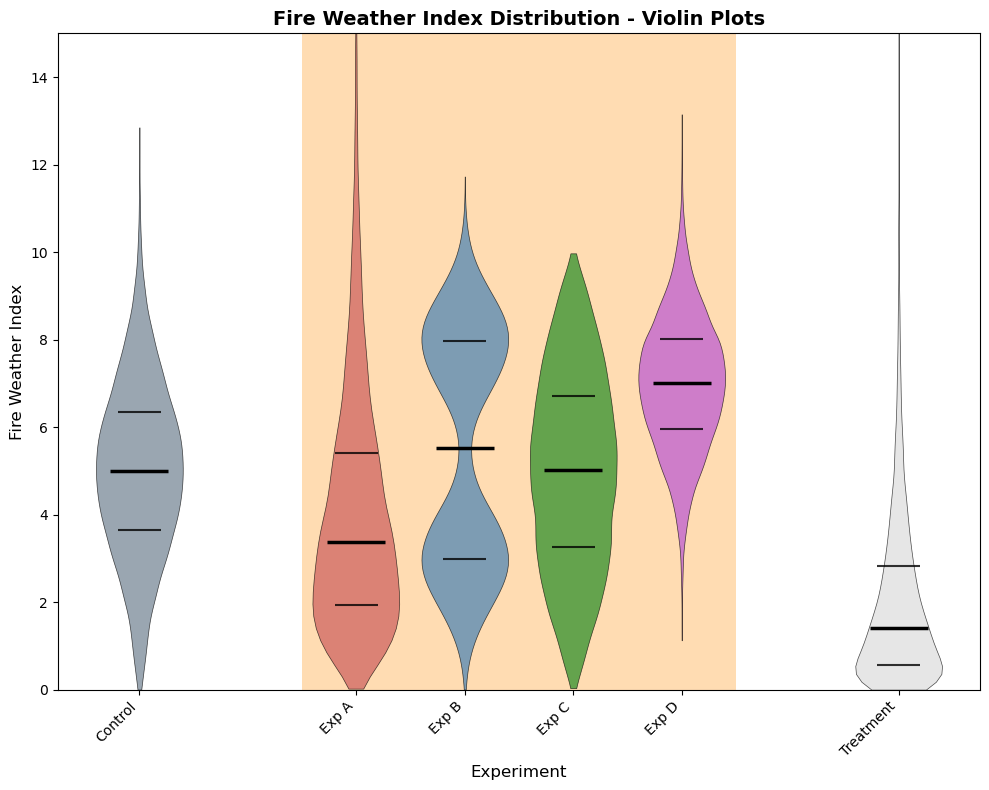

Creating violin plots with inner box plots...


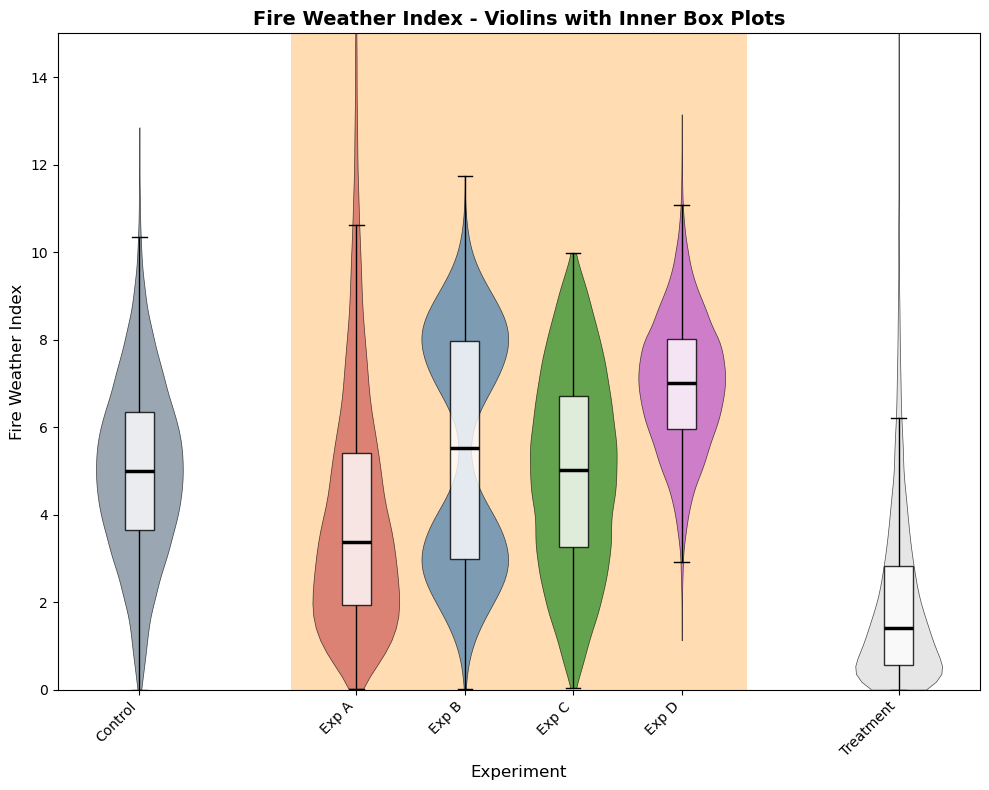

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde

def create_fwi_violinplots_custom_spacing(data_arrays, labels=None, colors=None, 
                                        title="Fire Weather Index Distribution", 
                                        ylabel="Fire Weather Index", figsize=(10, 8),
                                        spacing_pattern="isolated_ends",
                                        show_quartiles=True, show_median=True,
                                        violin_alpha=0.7):
    """
    Create violin plots with custom spacing between plots
    
    Parameters:
    -----------
    data_arrays : list of xarray.DataArray
        List of xarray DataArrays containing FWI values
    labels : list of str, optional
        Labels for each violin plot
    colors : list of str, optional
        Colors for each violin plot
    title : str
        Title for the plot
    ylabel : str
        Y-axis label
    figsize : tuple
        Figure size (width, height)
    spacing_pattern : str
        "isolated_ends" - gaps before first and after last violin
        "custom" - use custom positions
    show_quartiles : bool
        Whether to show quartile lines on violins
    show_median : bool
        Whether to show median line on violins
    violin_alpha : float
        Transparency of violin plots (0-1)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    
    # Default labels and colors
    if labels is None:
        labels = [f"Region {i+1}" for i in range(len(data_arrays))]
    if colors is None:
        colors = ['slategrey', 'indianred', 'steelblue', 'forestgreen', 'mediumorchid', 'gainsboro']
    
    # Extract data from DataArrays and flatten to 1D
    data_list = []
    for da in data_arrays:
        flattened_data = da.values.flatten()
        clean_data = flattened_data[~np.isnan(flattened_data)]
        data_list.append(clean_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define custom positions based on spacing pattern
    if spacing_pattern == "isolated_ends" and len(data_list) == 6:
        # Pattern: Violin1 | gap | Violin2-Violin3-Violin4-Violin5 | gap | Violin6
        positions = [1, 3, 4, 5, 6, 8]
    elif spacing_pattern == "custom" and len(data_list) == 6:
        # Define your own custom positions here
        positions = [1, 2.5, 3.5, 4.5, 5.5, 7]  # Customize as needed
    else:
        # Default equal spacing
        positions = list(range(1, len(data_list) + 1))
    
    # Add background color for middle four violin plots if using isolated_ends pattern
    if spacing_pattern == "isolated_ends" and len(data_list) == 6:
        # Get the y-axis limits to span the full height
        all_data = np.concatenate([data for data in data_list])
        y_min = np.min(all_data)
        y_max = np.max(all_data)
        
        # Add some padding to the background
        y_padding = (y_max - y_min) * 0.05
        
        # Background rectangle covering the middle 4 violin plots (positions 3-6)
        middle_positions = positions[1:5]  # positions [3, 4, 5, 6]
        bg_left = min(middle_positions) - 0.5
        bg_right = max(middle_positions) + 0.5
        bg_width = bg_right - bg_left
        bg_height = y_max - y_min + 2 * y_padding
        
        background_rect = Rectangle((bg_left, y_min - y_padding), 
                                  bg_width, bg_height,
                                  facecolor='darkorange', 
                                  alpha=0.3,  # Semi-transparent
                                  edgecolor='none',
                                  zorder=0)  # Behind everything else
        ax.add_patch(background_rect)
    
    # Create violin plots
    violin_width = 0.8  # Width of each violin
    
    for i, (data, color, pos) in enumerate(zip(data_list, colors, positions)):
        
        # Create violin plot using matplotlib's violinplot
        parts = ax.violinplot([data], positions=[pos], widths=[violin_width], 
                             showmeans=False, showmedians=False, showextrema=False)
        
        # Customize violin appearance
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_alpha(violin_alpha)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.5)
            pc.set_zorder(2)  # Above background
        
        # Add quartiles and median lines if requested
        if show_quartiles or show_median:
            # Calculate percentiles
            q1 = np.percentile(data, 25)
            q2 = np.percentile(data, 50)  # median
            q3 = np.percentile(data, 75)
            
            # Add quartile lines
            if show_quartiles:
                ax.hlines([q1, q3], pos - violin_width/4, pos + violin_width/4, 
                         colors='black', linewidth=1.5, alpha=0.8, zorder=3)
            
            # Add median line
            if show_median:
                ax.hlines(q2, pos - violin_width/3, pos + violin_width/3, 
                         colors='black', linewidth=2.5, alpha=1, zorder=3)
        
        # Optional: Add min/max whiskers (like box plots)
        # Uncomment if you want whiskers
        # p5 = np.percentile(data, 5)
        # p95 = np.percentile(data, 95)
        # ax.vlines(pos, p5, p95, colors='black', linewidth=1, alpha=0.6, zorder=3)
    
    # Customize the plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Experiment', fontsize=12)
    
    # Set x-axis
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    # Adjust x-axis limits
    ax.set_xlim(min(positions) - 0.75, max(positions) + 0.75)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    
    return fig, ax

def create_fwi_violinplots_with_background(data_arrays, labels=None, colors=None, 
                                         title="Fire Weather Index Distribution", 
                                         ylabel="Fire Weather Index", figsize=(10, 8),
                                         spacing_pattern="isolated_ends",
                                         background_color="darkorange",
                                         background_alpha=0.3,
                                         violin_style="filled",
                                         show_box_inside=False):
    """
    Create violin plots with more customization options
    
    Parameters:
    -----------
    violin_style : str
        "filled" - standard filled violins
        "outline" - outline only
        "half" - half violins (one side only)
    show_box_inside : bool
        Whether to show a small box plot inside each violin
    """
    
    # Default labels and colors
    if labels is None:
        labels = [f"Region {i+1}" for i in range(len(data_arrays))]
    if colors is None:
        colors = ['slategrey', 'indianred', 'steelblue', 'forestgreen', 'mediumorchid', 'gainsboro']
    
    # Extract data from DataArrays and flatten to 1D
    data_list = []
    for da in data_arrays:
        flattened_data = da.values.flatten()
        clean_data = flattened_data[~np.isnan(flattened_data)]
        data_list.append(clean_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define custom positions based on spacing pattern
    if spacing_pattern == "isolated_ends" and len(data_list) == 6:
        positions = [1, 3, 4, 5, 6, 8]
        background_indices = [1, 2, 3, 4]  # Middle 4 violin plots (indices 1-4)
    elif spacing_pattern == "custom" and len(data_list) == 6:
        positions = [1, 2.5, 3.5, 4.5, 5.5, 7]
        background_indices = [1, 2, 3, 4]  # Adjust as needed
    else:
        positions = list(range(1, len(data_list) + 1))
        background_indices = []  # No background for default spacing
    
    # Add background color for specified violin plots
    if background_indices and spacing_pattern == "isolated_ends":
        # Calculate data range for background height
        all_data = np.concatenate([data for data in data_list])
        y_min = np.min(all_data)
        y_max = np.max(all_data)
        y_padding = (y_max - y_min) * 0.05
        
        # Get positions of the background violin plots
        bg_positions = [positions[i] for i in background_indices]
        bg_left = min(bg_positions) - 0.6
        bg_right = max(bg_positions) + 0.6
        bg_width = bg_right - bg_left
        bg_height = y_max - y_min + 2 * y_padding
        
        background_rect = Rectangle((bg_left, y_min - y_padding), 
                                  bg_width, bg_height,
                                  facecolor=background_color, 
                                  alpha=background_alpha,
                                  edgecolor='none',
                                  zorder=0)
        ax.add_patch(background_rect)
    
    # Create violin plots
    violin_width = 0.8
    
    for i, (data, color, pos) in enumerate(zip(data_list, colors, positions)):
        
        if violin_style == "filled":
            # Standard filled violin
            parts = ax.violinplot([data], positions=[pos], widths=[violin_width], 
                                 showmeans=False, showmedians=False, showextrema=False)
            
            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_alpha(0.7)
                pc.set_edgecolor('black')
                pc.set_linewidth(0.5)
                pc.set_zorder(2)
        
        elif violin_style == "outline":
            # Outline only violin
            parts = ax.violinplot([data], positions=[pos], widths=[violin_width], 
                                 showmeans=False, showmedians=False, showextrema=False)
            
            for pc in parts['bodies']:
                pc.set_facecolor('none')
                pc.set_edgecolor(color)
                pc.set_linewidth(2)
                pc.set_zorder(2)
        
        # Add inner box plot if requested
        if show_box_inside:
            # Small box plot inside the violin
            box_parts = ax.boxplot([data], positions=[pos], widths=[violin_width/3],
                                  patch_artist=True, showfliers=False)
            
            # Customize box appearance
            for patch in box_parts['boxes']:
                patch.set_facecolor('white')
                patch.set_alpha(0.8)
                patch.set_edgecolor('black')
                patch.set_linewidth(1)
                patch.set_zorder(4)
            
            # Set median line to black
            for median in box_parts['medians']:
                median.set_color('black')
                median.set_linewidth(2.5)
                median.set_zorder(5)
            
            # Customize other box plot elements
            for whisker in box_parts['whiskers']:
                whisker.set_color('black')
                whisker.set_linewidth(1)
            
            for cap in box_parts['caps']:
                cap.set_color('black')
                cap.set_linewidth(1)
        
        else:
            # Add quartiles and median manually
            q1, q2, q3 = np.percentile(data, [25, 50, 75])
            
            # Add quartile lines
            ax.hlines([q1, q3], pos - violin_width/4, pos + violin_width/4, 
                     colors='black', linewidth=1.5, alpha=0.8, zorder=3)
            
            # Add median line
            ax.hlines(q2, pos - violin_width/3, pos + violin_width/3, 
                     colors='black', linewidth=2.5, alpha=1, zorder=3)
    
    # Customize the plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Experiment', fontsize=12)
    
    # Set x-axis
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    # Adjust x-axis limits
    ax.set_xlim(min(positions) - 0.75, max(positions) + 0.75)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    
    return fig, ax

# Example usage
def example_usage():
    """
    Example usage with sample data showing violin plots
    """
    import xarray as xr
    
    # Create sample data with different distributions for better violin shapes
    np.random.seed(42)
    sample_data_arrays = []
    
    for i in range(6):
        # Create more interesting distributions for violin plots
        if i == 0:
            # Normal distribution
            data = np.random.normal(5, 2, size=(100, 100))
        elif i == 1:
            # Skewed distribution
            data = np.random.gamma(2, 2, size=(100, 100))
        elif i == 2:
            # Bimodal distribution
            data1 = np.random.normal(3, 1, size=5000)
            data2 = np.random.normal(8, 1, size=5000)
            data = np.concatenate([data1, data2]).reshape(100, 100)
        elif i == 3:
            # Uniform-ish distribution
            data = np.random.beta(2, 2, size=(100, 100)) * 10
        elif i == 4:
            # Another normal with different parameters
            data = np.random.normal(7, 1.5, size=(100, 100))
        else:
            # Exponential-like
            data = np.random.exponential(2, size=(100, 100))
        
        # Ensure positive values and convert to xarray
        data = np.abs(data)
        da = xr.DataArray(data, dims=['lat', 'lon'])
        sample_data_arrays.append(da)
    
    # Custom labels
    region_labels = ['Control', 'Exp A', 'Exp B', 'Exp C', 'Exp D', 'Treatment']
    
    # Create standard violin plots with darkorange background
    print("Creating violin plots with background highlighting...")
    fig1, ax1 = create_fwi_violinplots_custom_spacing(
        sample_data_arrays,
        labels=region_labels,
        title="Fire Weather Index Distribution - Violin Plots",
        ylabel="Fire Weather Index",
        spacing_pattern="isolated_ends"
    )
    
    ax1.set_ylim(0, 15)
    plt.show()
    
    # Create violin plots with box plots inside
    print("Creating violin plots with inner box plots...")
    fig2, ax2 = create_fwi_violinplots_with_background(
        sample_data_arrays,
        labels=region_labels,
        title="Fire Weather Index - Violins with Inner Box Plots",
        ylabel="Fire Weather Index",
        spacing_pattern="isolated_ends",
        show_box_inside=True
    )
    
    ax2.set_ylim(0, 15)
    plt.show()
    
    return fig1, ax1

# Usage examples:
"""
# Basic violin plots with your exact styling
fig, ax = create_fwi_violinplots_custom_spacing(
    your_data_arrays,
    labels=your_labels,
    spacing_pattern="isolated_ends"  # Adds darkorange background
)

# Violin plots with more customization
fig, ax = create_fwi_violinplots_with_background(
    your_data_arrays,
    labels=your_labels,
    spacing_pattern="isolated_ends",
    background_color="lightcoral",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)
"""

if __name__ == "__main__":
    example_usage()

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_xarray_distributions(data_arrays, labels=None, show_hist=True, show_kde=True, 
                             overlay=False, figsize=(15, 10), bins='auto', alpha=0.7,
                             xlabel='Value', ylabel=None, xlim=None, ylim=None, 
                             show_grid=True, plot_title=None, legend_title='Datasets',
                             legend_inside=False, legend_facecolor='white', legend_edgecolor='black',
                             legend_shadow=True, plot_facecolor='white', show_reference_line=True,
                             reference_line_x=30, reference_line_color='black', colors=None):
    """
    Create histograms and/or KDE plots for a list of 6 xarray DataArrays.
    
    Parameters:
    -----------
    data_arrays : list
        List of 6 xarray DataArrays to plot
    labels : list, optional
        List of 6 labels for each plot/legend. If None, uses default labels.
    show_hist : bool, default True
        Whether to show histogram bars
    show_kde : bool, default True
        Whether to show KDE curve
    overlay : bool, default False
        If True, overlay all distributions in a single plot. If False, create subplots.
    figsize : tuple, default (15, 10)
        Figure size as (width, height)
    bins : int or str, default 'auto'
        Number of bins for histogram
    alpha : float, default 0.7
        Transparency level for histogram bars
    xlabel : str, default 'Value'
        Label for x-axis
    ylabel : str, optional
        Label for y-axis. If None, uses 'Density' for KDE or 'Count' for histogram.
    xlim : tuple, optional
        X-axis limits as (min, max). If None, uses automatic scaling.
    ylim : tuple, optional
        Y-axis limits as (min, max). If None, uses automatic scaling.
    show_grid : bool, default True
        Whether to show gridlines on the plot(s).
    plot_title : str, optional
        Title for the plot. If None, no title is added. In subplot mode, this becomes 
        the suptitle (overall title). In overlay mode, this becomes the plot title.
    legend_title : str, default 'Datasets'
        Title for the legend. Only applies to overlay mode. Set to None to remove legend title.
    legend_inside : bool, default False
        If True, positions legend inside the plot area. If False, positions outside (default).
        Only applies to overlay mode.
    legend_facecolor : str, default 'white'
        Background color of the legend box. Only applies to overlay mode.
    legend_edgecolor : str, default 'black'
        Border/edge color of the legend box. Only applies to overlay mode.
    legend_shadow : bool, default True
        Whether to show drop shadow for the legend box. Only applies to overlay mode.
    plot_facecolor : str, default 'white'
        Background color of the plot area(s). Applies to both overlay and subplot modes.
    show_reference_line : bool, default True
        Whether to show a vertical reference line on the plot(s).
    reference_line_x : float, default 30
        X-coordinate for the vertical reference line. Only used if show_reference_line is True.
    reference_line_color : str, default 'red'
        Color of the vertical reference line. Only used if show_reference_line is True.
    colors : list, optional
        List of 6 colors for the distributions. If None, uses default colors:
        ['slategrey', 'indianred', 'steelblue', 'forestgreen', 'mediumorchid', 'gainsboro'].
        Accepts any matplotlib color format (names, hex codes, RGB tuples).
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot(s)
    """
    
    # Validate inputs
    if len(data_arrays) != 6:
        raise ValueError("This function expects exactly 6 xarray DataArrays")
    
    # Define colors for each plot - use custom colors if provided, otherwise use defaults
    if colors is None:
        colors = ['slategrey', 'indianred', 'steelblue', 'forestgreen', 'mediumorchid', 'gainsboro']
    elif len(colors) != 6:
        raise ValueError("If provided, colors must be a list of exactly 6 colors")
    
    # Set default labels if none provided
    if labels is None:
        labels = [f'DataArray {i+1}' for i in range(6)]
    elif len(labels) != 6:
        raise ValueError("If provided, labels must be a list of exactly 6 strings")
    
    # Set default ylabel if none provided
    if ylabel is None:
        ylabel = 'Density' if show_kde else 'Count'
    
    if overlay:
        # Create single plot for overlaid distributions
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Plot each DataArray on the same axes
        for i, (data_array, label, color) in enumerate(zip(data_arrays, labels, colors)):
            # Flatten the xarray DataArray to 1D for plotting
            data_flat = data_array.values.flatten()
            
            # Remove NaN values
            data_clean = data_flat[~np.isnan(data_flat)]
            
            if len(data_clean) == 0:
                print(f"Warning: No valid data for {label}")
                continue
            
            # Set line thickness - first and last datasets get thicker lines
            line_thickness = 4 if (i == 0 or i == 5) else 2
            
            # Create the distribution plot
            if show_kde and not show_hist:
                # For KDE only, use kdeplot to avoid histogram artifacts
                sns.kdeplot(data=data_clean, ax=ax, color=color, label=label,
                           linewidth=line_thickness)
            else:
                # Standard histplot for histogram and/or combined plots
                sns.histplot(data=data_clean, ax=ax, color=color, label=label,
                            kde=show_kde, stat='density' if show_kde else 'count',
                            bins=bins, alpha=alpha if show_hist else 0,
                            line_kws={'linewidth': line_thickness} if show_kde else None,
                            element='step' if not show_hist else 'bars')
                
                # If only showing KDE, make sure histogram bars are not visible
                if show_kde and not show_hist:
                    # For overlaid plots, we handle this differently
                    # Remove the histogram bars that were just added
                    patches_to_remove = ax.patches[-len(ax.patches):]
                    for patch in patches_to_remove:
                        patch.set_alpha(0)
        
        # Set labels and add title if provided
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        if plot_title is not None:
            ax.set_title(plot_title, fontsize=14, fontweight='bold')
        
        # Set plot background color
        ax.set_facecolor(plot_facecolor)
        
        # Add legend with custom positioning and styling
        if legend_inside:
            # Position legend inside the plot area using 'best' location
            legend = ax.legend(title=legend_title, loc='best', 
                             fancybox=True, shadow=legend_shadow, framealpha=0.9)
        else:
            # Position legend outside the plot area (default)
            legend = ax.legend(title=legend_title, bbox_to_anchor=(1.05, 1), 
                             loc='upper left', fancybox=True, shadow=legend_shadow, framealpha=0.9)
        
        # Set legend box colors
        legend.get_frame().set_facecolor(legend_facecolor)
        legend.get_frame().set_edgecolor(legend_edgecolor)
        
        # Add grid for better readability (if enabled)
        if show_grid:
            ax.grid(True, alpha=0.3)
        
        # Set axis limits if provided
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        
    else:
        # Create subplots in a 2x3 grid (original behavior)
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()  # Make it easier to iterate
        
        # Plot each DataArray
        for i, (data_array, label, color) in enumerate(zip(data_arrays, labels, colors)):
            # Flatten the xarray DataArray to 1D for plotting
            data_flat = data_array.values.flatten()
            
            # Remove NaN values
            data_clean = data_flat[~np.isnan(data_flat)]
            
            if len(data_clean) == 0:
                axes[i].text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                            transform=axes[i].transAxes)
                axes[i].set_title(label)
                continue
            
            # Create the distribution plot
            if show_kde and not show_hist:
                # For KDE only, use kdeplot to avoid histogram artifacts
                sns.kdeplot(data=data_clean, ax=axes[i], color=color,
                           linewidth=2)
            else:
                # Standard histplot for histogram and/or combined plots
                sns.histplot(data=data_clean, ax=axes[i], color=color, 
                            kde=show_kde, stat='density' if show_kde else 'count',
                            bins=bins, alpha=alpha if show_hist else 0,
                            line_kws={'linewidth': 2} if show_kde else None)
                
                # If only showing KDE, make sure histogram bars are not visible
                if show_kde and not show_hist:
                    # Clear the histogram bars but keep the KDE
                    for patch in axes[i].patches:
                        patch.set_alpha(0)
            
            # Set title and labels
            axes[i].set_title(label, fontsize=12, fontweight='bold')
            axes[i].set_xlabel(xlabel)
            axes[i].set_ylabel(ylabel)
            
            # Set plot background color
            axes[i].set_facecolor(plot_facecolor)
            
            # Add grid for better readability (if enabled)
            if show_grid:
                axes[i].grid(True, alpha=0.3)
            
            # Add reference line if enabled
            if show_reference_line:
                axes[i].axvline(x=reference_line_x, color=reference_line_color, linestyle='--', 
                              linewidth=1.5, alpha=0.7)
            
            # Set axis limits if provided
            if xlim is not None:
                axes[i].set_xlim(xlim)
            if ylim is not None:
                axes[i].set_ylim(ylim)
    
    # Add overall title for subplot mode if provided
    if not overlay and plot_title is not None:
        fig.suptitle(plot_title, fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Add reference line AFTER tight_layout for overlay mode (final step)
    if overlay and show_reference_line:
        ax = fig.gca()  # Get current axis
        ax.axvline(x=reference_line_x, color=reference_line_color, linestyle='--', 
                  linewidth=2, alpha=0.8, zorder=1)  # Low zorder puts it behind distributions
        # Keep original legend without reference line
        ax.legend(title=legend_title, 
                 bbox_to_anchor=(1.05, 1) if not legend_inside else None,
                 loc='upper left' if not legend_inside else 'best',
                 fancybox=True, shadow=legend_shadow, framealpha=0.9)
        # Reapply legend styling
        legend = ax.get_legend()
        if legend:
            legend.get_frame().set_facecolor(legend_facecolor)
            legend.get_frame().set_edgecolor(legend_edgecolor)
    
    return fig

# Example usage function
def example_usage():
    """
    Example of how to use the plot_xarray_distributions function.
    This creates dummy xarray DataArrays for demonstration.
    """
    import xarray as xr
    
    # Create example xarray DataArrays with different distributions
    np.random.seed(42)  # For reproducible results
    
    data_arrays = []
    for i in range(6):
        # Create different types of distributions for variety
        if i == 0:
            data = np.random.normal(0, 1, (50, 50))  # Normal distribution
        elif i == 1:
            data = np.random.exponential(2, (50, 50))  # Exponential distribution
        elif i == 2:
            data = np.random.gamma(2, 2, (50, 50))  # Gamma distribution
        elif i == 3:
            data = np.random.uniform(-3, 3, (50, 50))  # Uniform distribution
        elif i == 4:
            data = np.random.lognormal(0, 0.5, (50, 50))  # Log-normal distribution
        else:
            data = np.random.beta(2, 5, (50, 50))  # Beta distribution
        
        # Create xarray DataArray
        da = xr.DataArray(
            data,
            dims=['x', 'y'],
            coords={'x': range(50), 'y': range(50)},
            name=f'dataset_{i+1}'
        )
        data_arrays.append(da)
    
    # Example 1: Default settings (both histogram and KDE) - Subplots
    labels = ['Normal', 'Exponential', 'Gamma', 'Uniform', 'Log-Normal', 'Beta']
    fig1 = plot_xarray_distributions(data_arrays, labels=labels)
    plt.suptitle('XArray Distributions - Histogram + KDE (Subplots)', fontsize=16, y=1.02)
    plt.show()
    
    # Example 2: Overlaid histograms and KDEs
    fig2 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                   xlabel='Data Values', ylabel='Probability Density',
                                   figsize=(12, 8))
    plt.show()
    
    # Example 3: Overlaid KDE only with custom labels
    fig3 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                   show_hist=False, show_kde=True,
                                   xlabel='Temperature (°C)', ylabel='Density',
                                   figsize=(10, 6), alpha=0.3)
    plt.show()
    
    # Example 5: Custom axis limits - Overlaid plot
    fig5 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                   xlabel='Standardized Values', ylabel='Density',
                                   xlim=(-2, 4), ylim=(0, 0.8),
                                   figsize=(10, 6))
    plt.show()
    
    # Example 7: KDE only without grid lines
    fig7 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                   show_hist=False, show_kde=True,
                                   xlabel='Clean Data', ylabel='Density',
                                   show_grid=False, figsize=(10, 6))
    plt.show()
    
    # Example 9: Custom titles and legend
    fig9 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                   show_hist=True, show_kde=True,
                                   xlabel='Measurement Values', ylabel='Probability Density',
                                   plot_title='Distribution Comparison Analysis',
                                   legend_title='Experimental Conditions',
                                   figsize=(12, 8))
    plt.show()
    
    # Example 10: Subplots with overall title and no legend title
    fig10 = plot_xarray_distributions(data_arrays, labels=labels, overlay=False,
                                    show_hist=False, show_kde=True,
                                    xlabel='Normalized Values', ylabel='Density',
                                    plot_title='Individual Distribution Analysis',
                                    show_grid=False, figsize=(15, 10))
    plt.show()
    
    # Example 12: Demonstrate bold first and last lines in overlay
    fig12 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='KDE Comparison with Emphasized First & Last',
                                    legend_title='Distributions',
                                    show_grid=True, figsize=(12, 8))
    plt.show()
    
    # Example 14: Legend inside plot with custom color
    fig14 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='KDE with Inside Legend',
                                    legend_title='Sample Types',
                                    legend_inside=True,
                                    legend_facecolor='lightblue',
                                    figsize=(10, 8))
    plt.show()
    
    # Example 15: Different legend colors and positions
    fig15 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='Custom Legend Styling',
                                    legend_title='Conditions',
                                    legend_inside=False,
                                    legend_facecolor='lightyellow',
                                    alpha=0.6, figsize=(12, 8))
    plt.show()
    
    # Example 17: Legend with custom edge colors and auto-positioning
    fig17 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='Auto-Positioned Legend with Custom Styling',
                                    legend_title='Data Sources',
                                    legend_inside=True,
                                    legend_facecolor='lightcyan',
                                    legend_edgecolor='darkblue',
                                    figsize=(10, 8))
    plt.show()
    
    # Example 18: High contrast legend styling
    fig18 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='High Contrast Legend Design',
                                    legend_title='Conditions',
                                    legend_inside=False,
                                    legend_facecolor='black',
                                    legend_edgecolor='gold',
                                    alpha=0.5, figsize=(12, 8))
    plt.show()
    
    # Example 20: Minimalist legend without shadow
    fig20 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='Clean Legend Design (No Shadow)',
                                    legend_title='Sample Groups',
                                    legend_inside=True,
                                    legend_facecolor='white',
                                    legend_edgecolor='gray',
                                    legend_shadow=False,  # No drop shadow
                                    show_grid=False, figsize=(10, 8))
    plt.show()
    
    # Example 21: Comparison - with and without shadow styling
    fig21 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='Legend with Shadow Effect',
                                    legend_title='Conditions',
                                    legend_inside=False,
                                    legend_facecolor='lightblue',
                                    legend_edgecolor='darkblue',
                                    legend_shadow=True,   # With drop shadow
                                    alpha=0.6, figsize=(12, 8))
    plt.show()
    
    # Example 23: Dark theme with light plots
    fig23 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='Dark Theme Distribution Analysis',
                                    legend_title='Data Sources',
                                    legend_inside=True,
                                    legend_facecolor='darkgray',
                                    legend_edgecolor='white',
                                    legend_shadow=False,
                                    plot_facecolor='#2b2b2b',  # Dark background
                                    show_grid=True, figsize=(12, 8))
    plt.show()
    
    # Example 24: Light theme with subtle background
    fig24 = plot_xarray_distributions(data_arrays, labels=labels, overlay=False,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='Light Theme Subplots',
                                    plot_facecolor='#f8f9fa',  # Very light gray
                                    show_grid=True, figsize=(15, 10))
    plt.show()
    
    # Example 26: With default reference line
    fig26 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Temperature (°C)', ylabel='Density',
                                    plot_title='Distribution Analysis with Reference Line',
                                    legend_title='Conditions',
                                    legend_inside=False,
                                    show_reference_line=True,  # Default x=30
                                    figsize=(12, 8))
    plt.show()
    
    # Example 27: Custom reference line position
    fig27 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='Custom Reference Line at x=0.5',
                                    show_reference_line=True,
                                    reference_line_x=0.5,  # Custom position
                                    alpha=0.6, figsize=(12, 8))
    plt.show()
    
    # Example 28: No reference line for clean look
    fig28 = plot_xarray_distributions(data_arrays, labels=labels, overlay=False,
                                    show_hist=True, show_kde=False,
                                    xlabel='Data Points', ylabel='Count',
                                    plot_title='Clean Subplots (No Reference Line)',
                                    show_reference_line=False,  # Disabled
                                    plot_facecolor='#f8f9fa',
                                    figsize=(15, 10))
    plt.show()
    
    # Example 30: Custom colored reference lines
    fig30 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Temperature (°C)', ylabel='Density',
                                    plot_title='Blue Reference Line Analysis',
                                    legend_title='Conditions',
                                    show_reference_line=True,
                                    reference_line_x=1.5,
                                    reference_line_color='blue',  # Custom color
                                    figsize=(12, 8))
    plt.show()
    
    # Example 31: Green reference line with light theme
    fig31 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='Green Threshold Analysis',
                                    show_reference_line=True,
                                    reference_line_x=0.0,
                                    reference_line_color='green',  # Green line
                                    plot_facecolor='#f8f9fa',
                                    alpha=0.6, figsize=(12, 8))
    plt.show()
    
    # Example 32: Purple reference line in dark theme
    fig32 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='Dark Theme with Purple Reference',
                                    show_reference_line=True,
                                    reference_line_x=2.0,
                                    reference_line_color='magenta',  # Bright on dark
                                    plot_facecolor='#2b2b2b',
                                    legend_facecolor='darkgray',
                                    legend_edgecolor='white',
                                    legend_inside=True,
                                    show_grid=False, figsize=(11, 7))
    plt.show()
    
    # Example 34: Custom fire weather colors (colorblind-safe)
    fire_weather_colors = ['#2f2f2f', '#ff8c42', '#4472c4', '#8b4513', '#ffd700', '#d3d3d3']
    fig34 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Fire Weather Index', ylabel='Density',
                                    plot_title='Fire Weather Risk Analysis (Custom Colors)',
                                    legend_title='Climate Factors',
                                    colors=fire_weather_colors,  # Custom palette
                                    show_reference_line=True,
                                    reference_line_color='black',
                                    figsize=(12, 8))
    plt.show()
    
    # Example 35: Pastel color palette
    pastel_colors = ['#696969', '#ffb366', '#66b3ff', '#cd853f', '#ffe066', '#cccccc']
    fig35 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=True, show_kde=True,
                                    xlabel='Measurement Values', ylabel='Density',
                                    plot_title='Soft Pastel Color Theme',
                                    colors=pastel_colors,  # Pastel palette
                                    alpha=0.6, figsize=(12, 8))
    plt.show()
    
    # Example 36: High-contrast presentation colors
    presentation_colors = ['black', '#ff7f00', '#0077bb', '#8b4513', '#ffdd44', '#bbbbbb']
    fig36 = plot_xarray_distributions(data_arrays, labels=labels, overlay=False,
                                    show_hist=True, show_kde=False,
                                    xlabel='Data Points', ylabel='Count',
                                    plot_title='High-Contrast Presentation Style',
                                    colors=presentation_colors,  # High contrast
                                    plot_facecolor='#f5f5f5',
                                    show_reference_line=True,
                                    reference_line_color='red',
                                    figsize=(15, 10))
    plt.show()
    
    # Example 37: Monochromatic grayscale theme
    grayscale_colors = ['#000000', '#333333', '#666666', '#999999', '#cccccc', '#eeeeee']
    fig37 = plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                    show_hist=False, show_kde=True,
                                    xlabel='Values', ylabel='Density',
                                    plot_title='Grayscale Scientific Publication Style',
                                    colors=grayscale_colors,  # Grayscale palette
                                    legend_inside=True,
                                    show_grid=False,
                                    reference_line_color='black',
                                    figsize=(10, 6))
    plt.show()

# Uncomment the line below to run the example
# example_usage()

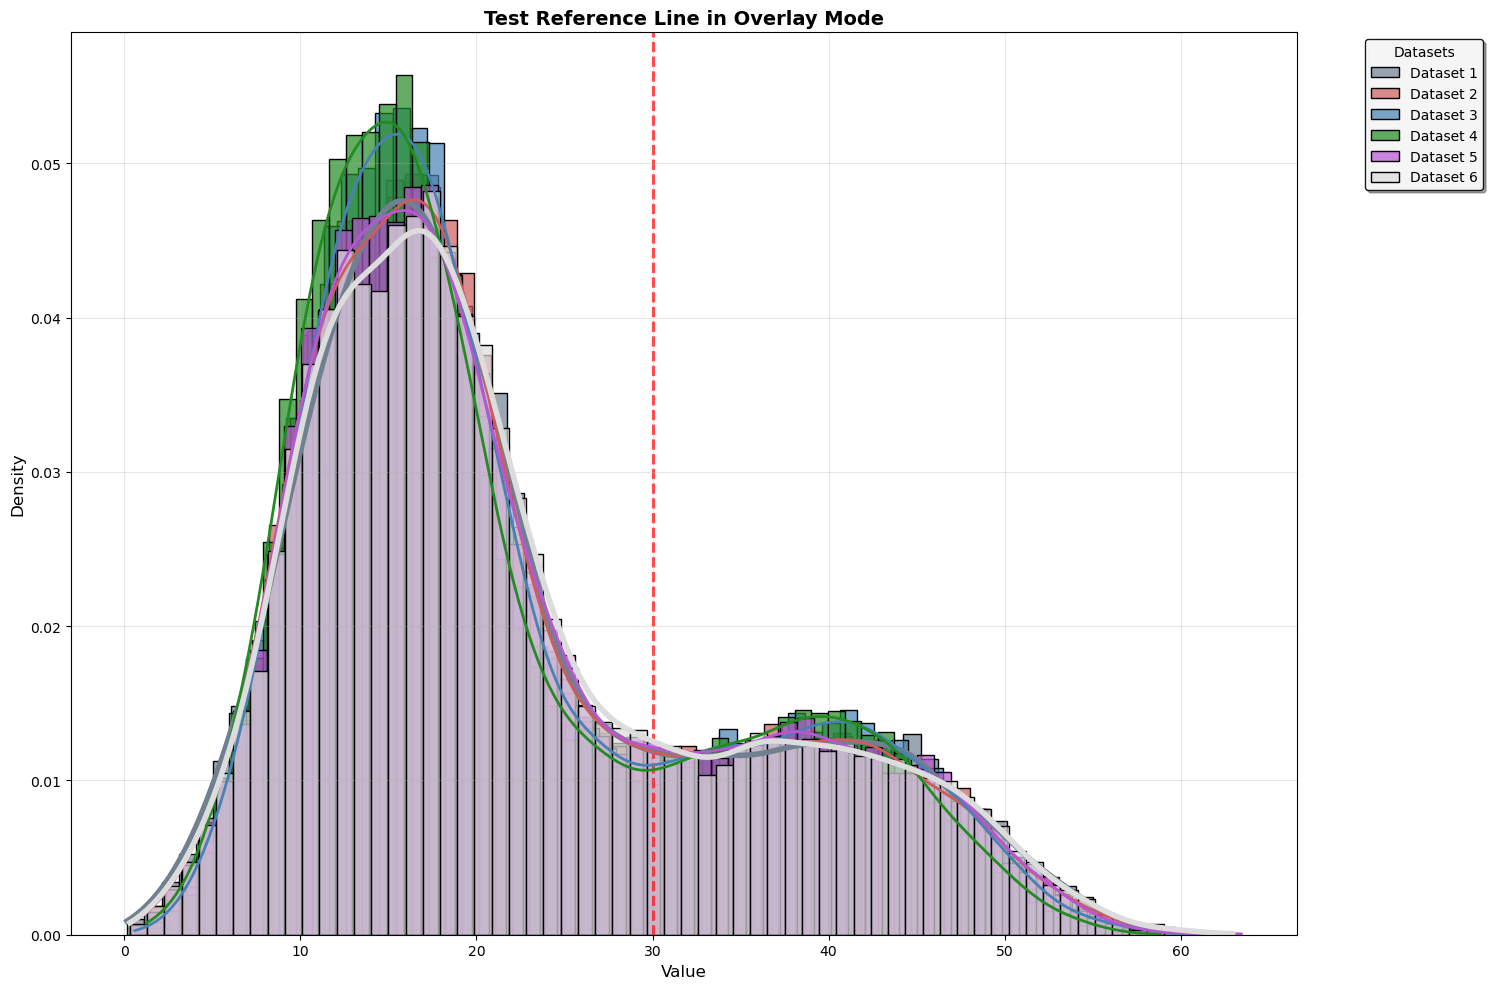

In [118]:
# This should now work correctly:
fig = plot_xarray_distributions(
    data_arrays,
    labels=['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5', 'Dataset 6'],
    overlay=True,
    show_kde=True,
    show_reference_line=True,
    reference_line_x=30,
    reference_line_color='red',
    plot_title='Test Reference Line in Overlay Mode'
)

# Data sanity check

In [12]:
ssp370_check = ssp370_FWI.mean(dim=['member','time']).compute()
print(f"ssp370_check is ready")
global_tasmax_check = global_tasmax_FWI.mean(dim=['member','time']).compute()
print(f"global_tasmax_check is ready")
global_pr_check = global_pr_FWI.mean(dim=['member','time']).compute()
print(f"global_pr_check is ready")
global_hurs_check = global_hurs_FWI.mean(dim=['member','time']).compute()
print(f"global_hurs_check is ready")
global_sfcWind_check = global_sfcWind_FWI.mean(dim=['member','time']).compute()
print(f"global_sfcWind_check is ready")
global_check = global_FWI.mean(dim=['member','time']).compute()
print(f"global_check is ready")


ssp370_check is ready
global_tasmax_check is ready
global_pr_check is ready
global_hurs_check is ready
global_sfcWind_check is ready
global_check is ready


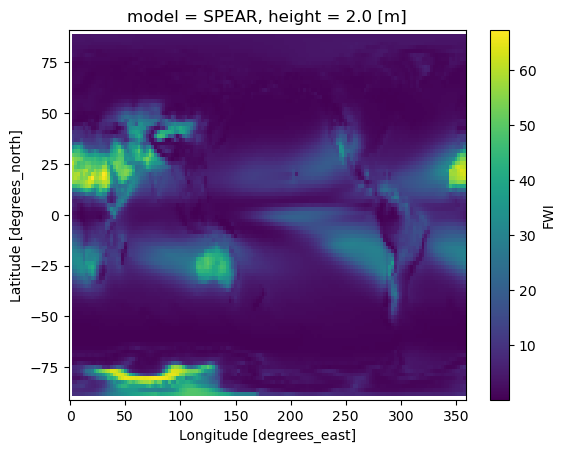

In [13]:
ssp370_check.plot()

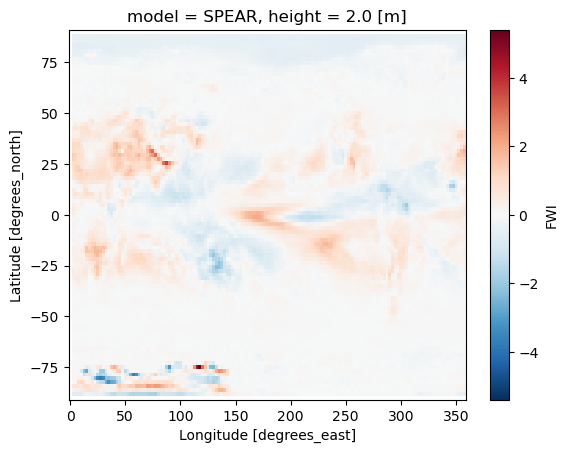

In [14]:
(global_check - ssp370_check).plot()

# Regional Daily Analysis

In [11]:
# Get daily data for non-barren land

ssp370_FWI_daily = ssp370_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"ssp370_FWI_daily is ready")
global_FWI_daily = global_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_FWI_daily is ready")
global_hurs_FWI_daily = global_hurs_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_hurs_FWI_daily is ready")
global_pr_FWI_daily = global_pr_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_pr_FWI_daily is ready")
global_sfcWind_FWI_daily = global_sfcWind_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_sfcWind_FWI_daily is ready")
global_tasmax_FWI_daily = global_tasmax_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_tasmax_FWI_daily is ready")


ssp370_FWI_daily is ready
global_FWI_daily is ready
global_hurs_FWI_daily is ready
global_pr_FWI_daily is ready
global_sfcWind_FWI_daily is ready
global_tasmax_FWI_daily is ready


In [12]:
global_sfcWind_FWI_daily

<xarray.DataArray 'FWI' (member: 10, time: 3649, lat: 96, lon: 144)> Size: 4GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], shape=(10, 3649, 96, 144))
Coordinates:
  * time     (time) object 29kB 2041-01-01 12:00:00 ... 2050-12-30 12:00:00
  * member   (member) <U9 360B 'r1i1p1f1' 'r2i1p1f1' ... 'r9i1p1f1' 'r10i1p1f1'
    model    <U5 20B 'SPEAR'
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 8B 2.0
Attributes:
    units:      unitless
    long_name:  Fire Weather Index

In [13]:
# Group by region
ssp370_FWI_daily_region = ssp370_FWI_daily.groupby(mask)
print(f"ssp370_FWI_daily_region is ready")
global_FWI_daily_region = global_FWI_daily.groupby(mask)
print(f"global_FWI_daily_region is ready")
global_hurs_FWI_daily_region = global_hurs_FWI_daily.groupby(mask)
print(f"global_hurs_FWI_daily_region is ready")
global_pr_FWI_daily_region = global_pr_FWI_daily.groupby(mask)
print(f"global_pr_FWI_daily_region is ready")
global_sfcWind_FWI_daily_region = global_sfcWind_FWI_daily.groupby(mask)
print(f"global_sfcWind_FWI_daily_region is ready")
global_tasmax_FWI_daily_region = global_tasmax_FWI_daily.groupby(mask)
print(f"global_tasmax_FWI_daily_region is ready")


ssp370_FWI_daily_region is ready
global_FWI_daily_region is ready
global_hurs_FWI_daily_region is ready
global_pr_FWI_daily_region is ready
global_sfcWind_FWI_daily_region is ready
global_tasmax_FWI_daily_region is ready


In [14]:
# Unpack the lat/lon coordinates of the grouped data

# daily

# ssp370
ssp370_FWI_daily_nwn = ssp370_FWI_daily_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_nen = ssp370_FWI_daily_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_wna = ssp370_FWI_daily_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_cna = ssp370_FWI_daily_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_ena = ssp370_FWI_daily_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_nca = ssp370_FWI_daily_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_nsa = ssp370_FWI_daily_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_nes = ssp370_FWI_daily_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_sam = ssp370_FWI_daily_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_med = ssp370_FWI_daily_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_waf = ssp370_FWI_daily_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_caf = ssp370_FWI_daily_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_neaf = ssp370_FWI_daily_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seaf = ssp370_FWI_daily_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_wsaf = ssp370_FWI_daily_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_esaf = ssp370_FWI_daily_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_esb = ssp370_FWI_daily_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_rfe = ssp370_FWI_daily_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_sea = ssp370_FWI_daily_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_eau = ssp370_FWI_daily_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_sau = ssp370_FWI_daily_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_daily_nwn = global_FWI_daily_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_nen = global_FWI_daily_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_wna = global_FWI_daily_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_cna = global_FWI_daily_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_ena = global_FWI_daily_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_nca = global_FWI_daily_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_nsa = global_FWI_daily_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_nes = global_FWI_daily_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_sam = global_FWI_daily_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_med = global_FWI_daily_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_waf = global_FWI_daily_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_caf = global_FWI_daily_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_neaf = global_FWI_daily_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seaf = global_FWI_daily_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_wsaf = global_FWI_daily_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_esaf = global_FWI_daily_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_esb = global_FWI_daily_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_rfe = global_FWI_daily_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_sea = global_FWI_daily_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_eau = global_FWI_daily_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_sau = global_FWI_daily_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_daily_nwn = global_hurs_FWI_daily_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_nen = global_hurs_FWI_daily_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_wna = global_hurs_FWI_daily_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_cna = global_hurs_FWI_daily_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_ena = global_hurs_FWI_daily_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_nca = global_hurs_FWI_daily_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_nsa = global_hurs_FWI_daily_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_nes = global_hurs_FWI_daily_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_sam = global_hurs_FWI_daily_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_med = global_hurs_FWI_daily_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_waf = global_hurs_FWI_daily_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_caf = global_hurs_FWI_daily_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_neaf = global_hurs_FWI_daily_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seaf = global_hurs_FWI_daily_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_wsaf = global_hurs_FWI_daily_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_esaf = global_hurs_FWI_daily_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_esb = global_hurs_FWI_daily_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_rfe = global_hurs_FWI_daily_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_sea = global_hurs_FWI_daily_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_eau = global_hurs_FWI_daily_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_sau = global_hurs_FWI_daily_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_daily_nwn = global_pr_FWI_daily_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_nen = global_pr_FWI_daily_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_wna = global_pr_FWI_daily_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_cna = global_pr_FWI_daily_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_ena = global_pr_FWI_daily_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_nca = global_pr_FWI_daily_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_nsa = global_pr_FWI_daily_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_nes = global_pr_FWI_daily_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_sam = global_pr_FWI_daily_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_med = global_pr_FWI_daily_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_waf = global_pr_FWI_daily_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_caf = global_pr_FWI_daily_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_neaf = global_pr_FWI_daily_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seaf = global_pr_FWI_daily_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_wsaf = global_pr_FWI_daily_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_esaf = global_pr_FWI_daily_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_esb = global_pr_FWI_daily_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_rfe = global_pr_FWI_daily_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_sea = global_pr_FWI_daily_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_eau = global_pr_FWI_daily_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_sau = global_pr_FWI_daily_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_daily_nwn = global_sfcWind_FWI_daily_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_nen = global_sfcWind_FWI_daily_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_wna = global_sfcWind_FWI_daily_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_cna = global_sfcWind_FWI_daily_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_ena = global_sfcWind_FWI_daily_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_nca = global_sfcWind_FWI_daily_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_nsa = global_sfcWind_FWI_daily_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_nes = global_sfcWind_FWI_daily_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_sam = global_sfcWind_FWI_daily_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_med = global_sfcWind_FWI_daily_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_waf = global_sfcWind_FWI_daily_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_caf = global_sfcWind_FWI_daily_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_neaf = global_sfcWind_FWI_daily_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seaf = global_sfcWind_FWI_daily_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_wsaf = global_sfcWind_FWI_daily_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_esaf = global_sfcWind_FWI_daily_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_esb = global_sfcWind_FWI_daily_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_rfe = global_sfcWind_FWI_daily_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_sea = global_sfcWind_FWI_daily_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_eau = global_sfcWind_FWI_daily_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_sau = global_sfcWind_FWI_daily_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_daily_nwn = global_tasmax_FWI_daily_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_nen = global_tasmax_FWI_daily_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_wna = global_tasmax_FWI_daily_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_cna = global_tasmax_FWI_daily_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_ena = global_tasmax_FWI_daily_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_nca = global_tasmax_FWI_daily_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_nsa = global_tasmax_FWI_daily_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_nes = global_tasmax_FWI_daily_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_sam = global_tasmax_FWI_daily_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_med = global_tasmax_FWI_daily_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_waf = global_tasmax_FWI_daily_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_caf = global_tasmax_FWI_daily_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_neaf = global_tasmax_FWI_daily_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seaf = global_tasmax_FWI_daily_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_wsaf = global_tasmax_FWI_daily_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_esaf = global_tasmax_FWI_daily_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_esb = global_tasmax_FWI_daily_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_rfe = global_tasmax_FWI_daily_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_sea = global_tasmax_FWI_daily_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_eau = global_tasmax_FWI_daily_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_sau = global_tasmax_FWI_daily_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])



In [15]:
# Compute weighted horizontal average

# daily

# ssp370
ssp370_FWI_daily_global_avg = weighted_horizontal_avg(ssp370_FWI_daily, ensemble=False, time=False)
ssp370_FWI_daily_nwn_avg = weighted_horizontal_avg(ssp370_FWI_daily_nwn, ensemble=False, time=False)
ssp370_FWI_daily_nen_avg = weighted_horizontal_avg(ssp370_FWI_daily_nen, ensemble=False, time=False)
ssp370_FWI_daily_wna_avg = weighted_horizontal_avg(ssp370_FWI_daily_wna, ensemble=False, time=False)
ssp370_FWI_daily_cna_avg = weighted_horizontal_avg(ssp370_FWI_daily_cna, ensemble=False, time=False)
ssp370_FWI_daily_ena_avg = weighted_horizontal_avg(ssp370_FWI_daily_ena, ensemble=False, time=False)
ssp370_FWI_daily_nca_avg = weighted_horizontal_avg(ssp370_FWI_daily_nca, ensemble=False, time=False)
ssp370_FWI_daily_nsa_avg = weighted_horizontal_avg(ssp370_FWI_daily_nsa, ensemble=False, time=False)
ssp370_FWI_daily_nes_avg = weighted_horizontal_avg(ssp370_FWI_daily_nes, ensemble=False, time=False)
ssp370_FWI_daily_sam_avg = weighted_horizontal_avg(ssp370_FWI_daily_sam, ensemble=False, time=False)
ssp370_FWI_daily_med_avg = weighted_horizontal_avg(ssp370_FWI_daily_med, ensemble=False, time=False)
ssp370_FWI_daily_waf_avg = weighted_horizontal_avg(ssp370_FWI_daily_waf, ensemble=False, time=False)
ssp370_FWI_daily_caf_avg = weighted_horizontal_avg(ssp370_FWI_daily_caf, ensemble=False, time=False)
ssp370_FWI_daily_neaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_neaf, ensemble=False, time=False)
ssp370_FWI_daily_seaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seaf, ensemble=False, time=False)
ssp370_FWI_daily_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_wsaf, ensemble=False, time=False)
ssp370_FWI_daily_esaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_esaf, ensemble=False, time=False)
ssp370_FWI_daily_esb_avg = weighted_horizontal_avg(ssp370_FWI_daily_esb, ensemble=False, time=False)
ssp370_FWI_daily_rfe_avg = weighted_horizontal_avg(ssp370_FWI_daily_rfe, ensemble=False, time=False)
ssp370_FWI_daily_sea_avg = weighted_horizontal_avg(ssp370_FWI_daily_sea, ensemble=False, time=False)
ssp370_FWI_daily_eau_avg = weighted_horizontal_avg(ssp370_FWI_daily_eau, ensemble=False, time=False)
ssp370_FWI_daily_sau_avg = weighted_horizontal_avg(ssp370_FWI_daily_sau, ensemble=False, time=False)

# global
global_FWI_daily_global_avg = weighted_horizontal_avg(global_FWI_daily, ensemble=False, time=False)
global_FWI_daily_nwn_avg = weighted_horizontal_avg(global_FWI_daily_nwn, ensemble=False, time=False)
global_FWI_daily_nen_avg = weighted_horizontal_avg(global_FWI_daily_nen, ensemble=False, time=False)
global_FWI_daily_wna_avg = weighted_horizontal_avg(global_FWI_daily_wna, ensemble=False, time=False)
global_FWI_daily_cna_avg = weighted_horizontal_avg(global_FWI_daily_cna, ensemble=False, time=False)
global_FWI_daily_ena_avg = weighted_horizontal_avg(global_FWI_daily_ena, ensemble=False, time=False)
global_FWI_daily_nca_avg = weighted_horizontal_avg(global_FWI_daily_nca, ensemble=False, time=False)
global_FWI_daily_nsa_avg = weighted_horizontal_avg(global_FWI_daily_nsa, ensemble=False, time=False)
global_FWI_daily_nes_avg = weighted_horizontal_avg(global_FWI_daily_nes, ensemble=False, time=False)
global_FWI_daily_sam_avg = weighted_horizontal_avg(global_FWI_daily_sam, ensemble=False, time=False)
global_FWI_daily_med_avg = weighted_horizontal_avg(global_FWI_daily_med, ensemble=False, time=False)
global_FWI_daily_waf_avg = weighted_horizontal_avg(global_FWI_daily_waf, ensemble=False, time=False)
global_FWI_daily_caf_avg = weighted_horizontal_avg(global_FWI_daily_caf, ensemble=False, time=False)
global_FWI_daily_neaf_avg = weighted_horizontal_avg(global_FWI_daily_neaf, ensemble=False, time=False)
global_FWI_daily_seaf_avg = weighted_horizontal_avg(global_FWI_daily_seaf, ensemble=False, time=False)
global_FWI_daily_wsaf_avg = weighted_horizontal_avg(global_FWI_daily_wsaf, ensemble=False, time=False)
global_FWI_daily_esaf_avg = weighted_horizontal_avg(global_FWI_daily_esaf, ensemble=False, time=False)
global_FWI_daily_esb_avg = weighted_horizontal_avg(global_FWI_daily_esb, ensemble=False, time=False)
global_FWI_daily_rfe_avg = weighted_horizontal_avg(global_FWI_daily_rfe, ensemble=False, time=False)
global_FWI_daily_sea_avg = weighted_horizontal_avg(global_FWI_daily_sea, ensemble=False, time=False)
global_FWI_daily_eau_avg = weighted_horizontal_avg(global_FWI_daily_eau, ensemble=False, time=False)
global_FWI_daily_sau_avg = weighted_horizontal_avg(global_FWI_daily_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_daily_global_avg = weighted_horizontal_avg(global_hurs_FWI_daily, ensemble=False, time=False)
global_hurs_FWI_daily_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_daily_nwn, ensemble=False, time=False)
global_hurs_FWI_daily_nen_avg = weighted_horizontal_avg(global_hurs_FWI_daily_nen, ensemble=False, time=False)
global_hurs_FWI_daily_wna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_wna, ensemble=False, time=False)
global_hurs_FWI_daily_cna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_cna, ensemble=False, time=False)
global_hurs_FWI_daily_ena_avg = weighted_horizontal_avg(global_hurs_FWI_daily_ena, ensemble=False, time=False)
global_hurs_FWI_daily_nca_avg = weighted_horizontal_avg(global_hurs_FWI_daily_nca, ensemble=False, time=False)
global_hurs_FWI_daily_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_daily_nsa, ensemble=False, time=False)
global_hurs_FWI_daily_nes_avg = weighted_horizontal_avg(global_hurs_FWI_daily_nes, ensemble=False, time=False)
global_hurs_FWI_daily_sam_avg = weighted_horizontal_avg(global_hurs_FWI_daily_sam, ensemble=False, time=False)
global_hurs_FWI_daily_med_avg = weighted_horizontal_avg(global_hurs_FWI_daily_med, ensemble=False, time=False)
global_hurs_FWI_daily_waf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_waf, ensemble=False, time=False)
global_hurs_FWI_daily_caf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_caf, ensemble=False, time=False)
global_hurs_FWI_daily_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_neaf, ensemble=False, time=False)
global_hurs_FWI_daily_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seaf, ensemble=False, time=False)
global_hurs_FWI_daily_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_wsaf, ensemble=False, time=False)
global_hurs_FWI_daily_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_esaf, ensemble=False, time=False)
global_hurs_FWI_daily_esb_avg = weighted_horizontal_avg(global_hurs_FWI_daily_esb, ensemble=False, time=False)
global_hurs_FWI_daily_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_daily_rfe, ensemble=False, time=False)
global_hurs_FWI_daily_sea_avg = weighted_horizontal_avg(global_hurs_FWI_daily_sea, ensemble=False, time=False)
global_hurs_FWI_daily_eau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_eau, ensemble=False, time=False)
global_hurs_FWI_daily_sau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_daily_global_avg = weighted_horizontal_avg(global_pr_FWI_daily, ensemble=False, time=False)
global_pr_FWI_daily_nwn_avg = weighted_horizontal_avg(global_pr_FWI_daily_nwn, ensemble=False, time=False)
global_pr_FWI_daily_nen_avg = weighted_horizontal_avg(global_pr_FWI_daily_nen, ensemble=False, time=False)
global_pr_FWI_daily_wna_avg = weighted_horizontal_avg(global_pr_FWI_daily_wna, ensemble=False, time=False)
global_pr_FWI_daily_cna_avg = weighted_horizontal_avg(global_pr_FWI_daily_cna, ensemble=False, time=False)
global_pr_FWI_daily_ena_avg = weighted_horizontal_avg(global_pr_FWI_daily_ena, ensemble=False, time=False)
global_pr_FWI_daily_nca_avg = weighted_horizontal_avg(global_pr_FWI_daily_nca, ensemble=False, time=False)
global_pr_FWI_daily_nsa_avg = weighted_horizontal_avg(global_pr_FWI_daily_nsa, ensemble=False, time=False)
global_pr_FWI_daily_nes_avg = weighted_horizontal_avg(global_pr_FWI_daily_nes, ensemble=False, time=False)
global_pr_FWI_daily_sam_avg = weighted_horizontal_avg(global_pr_FWI_daily_sam, ensemble=False, time=False)
global_pr_FWI_daily_med_avg = weighted_horizontal_avg(global_pr_FWI_daily_med, ensemble=False, time=False)
global_pr_FWI_daily_waf_avg = weighted_horizontal_avg(global_pr_FWI_daily_waf, ensemble=False, time=False)
global_pr_FWI_daily_caf_avg = weighted_horizontal_avg(global_pr_FWI_daily_caf, ensemble=False, time=False)
global_pr_FWI_daily_neaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_neaf, ensemble=False, time=False)
global_pr_FWI_daily_seaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seaf, ensemble=False, time=False)
global_pr_FWI_daily_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_wsaf, ensemble=False, time=False)
global_pr_FWI_daily_esaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_esaf, ensemble=False, time=False)
global_pr_FWI_daily_esb_avg = weighted_horizontal_avg(global_pr_FWI_daily_esb, ensemble=False, time=False)
global_pr_FWI_daily_rfe_avg = weighted_horizontal_avg(global_pr_FWI_daily_rfe, ensemble=False, time=False)
global_pr_FWI_daily_sea_avg = weighted_horizontal_avg(global_pr_FWI_daily_sea, ensemble=False, time=False)
global_pr_FWI_daily_eau_avg = weighted_horizontal_avg(global_pr_FWI_daily_eau, ensemble=False, time=False)
global_pr_FWI_daily_sau_avg = weighted_horizontal_avg(global_pr_FWI_daily_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_daily_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily, ensemble=False, time=False)
global_sfcWind_FWI_daily_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_nwn, ensemble=False, time=False)
global_sfcWind_FWI_daily_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_nen, ensemble=False, time=False)
global_sfcWind_FWI_daily_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_wna, ensemble=False, time=False)
global_sfcWind_FWI_daily_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_cna, ensemble=False, time=False)
global_sfcWind_FWI_daily_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_ena, ensemble=False, time=False)
global_sfcWind_FWI_daily_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_nca, ensemble=False, time=False)
global_sfcWind_FWI_daily_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_nsa, ensemble=False, time=False)
global_sfcWind_FWI_daily_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_nes, ensemble=False, time=False)
global_sfcWind_FWI_daily_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_sam, ensemble=False, time=False)
global_sfcWind_FWI_daily_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_med, ensemble=False, time=False)
global_sfcWind_FWI_daily_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_waf, ensemble=False, time=False)
global_sfcWind_FWI_daily_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_caf, ensemble=False, time=False)
global_sfcWind_FWI_daily_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_neaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_esaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_esb, ensemble=False, time=False)
global_sfcWind_FWI_daily_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_rfe, ensemble=False, time=False)
global_sfcWind_FWI_daily_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_sea, ensemble=False, time=False)
global_sfcWind_FWI_daily_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_eau, ensemble=False, time=False)
global_sfcWind_FWI_daily_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_daily_global_avg = weighted_horizontal_avg(global_tasmax_FWI_daily, ensemble=False, time=False)
global_tasmax_FWI_daily_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_nwn, ensemble=False, time=False)
global_tasmax_FWI_daily_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_nen, ensemble=False, time=False)
global_tasmax_FWI_daily_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_wna, ensemble=False, time=False)
global_tasmax_FWI_daily_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_cna, ensemble=False, time=False)
global_tasmax_FWI_daily_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_ena, ensemble=False, time=False)
global_tasmax_FWI_daily_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_nca, ensemble=False, time=False)
global_tasmax_FWI_daily_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_nsa, ensemble=False, time=False)
global_tasmax_FWI_daily_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_nes, ensemble=False, time=False)
global_tasmax_FWI_daily_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_sam, ensemble=False, time=False)
global_tasmax_FWI_daily_med_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_med, ensemble=False, time=False)
global_tasmax_FWI_daily_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_waf, ensemble=False, time=False)
global_tasmax_FWI_daily_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_caf, ensemble=False, time=False)
global_tasmax_FWI_daily_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_neaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seaf, ensemble=False, time=False)
global_tasmax_FWI_daily_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_wsaf, ensemble=False, time=False)
global_tasmax_FWI_daily_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_esaf, ensemble=False, time=False)
global_tasmax_FWI_daily_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_esb, ensemble=False, time=False)
global_tasmax_FWI_daily_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_rfe, ensemble=False, time=False)
global_tasmax_FWI_daily_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_sea, ensemble=False, time=False)
global_tasmax_FWI_daily_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_eau, ensemble=False, time=False)
global_tasmax_FWI_daily_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_sau, ensemble=False, time=False)



In [16]:
ssp370_FWI_daily_esaf_avg

<xarray.DataArray 'FWI' (member: 10, time: 3649)> Size: 292kB
array([[0.83025016, 1.20034708, 2.20529864, ..., 7.86819033, 8.20429014,
        8.76230298],
       [2.41748295, 0.95281715, 0.60942928, ..., 2.79209132, 3.29615337,
        4.02453242],
       [1.58285682, 1.79537384, 2.23272783, ..., 1.240536  , 1.61230063,
        2.32646915],
       ...,
       [3.62299797, 4.2119724 , 2.96597103, ..., 2.49277372, 2.13736579,
        1.66340827],
       [4.86251088, 2.4773466 , 2.37223937, ..., 9.70399897, 4.93025253,
        2.81109931],
       [2.26754411, 2.08078769, 1.1210937 , ..., 1.13054525, 1.45076322,
        1.56203456]], shape=(10, 3649))
Coordinates:
  * member   (member) <U9 360B 'r1i1p1f1' 'r2i1p1f1' ... 'r9i1p1f1' 'r10i1p1f1'
  * time     (time) object 29kB 2041-01-01 12:00:00 ... 2050-12-30 12:00:00
    model    <U5 20B 'SPEAR'
    height   float64 8B 2.0

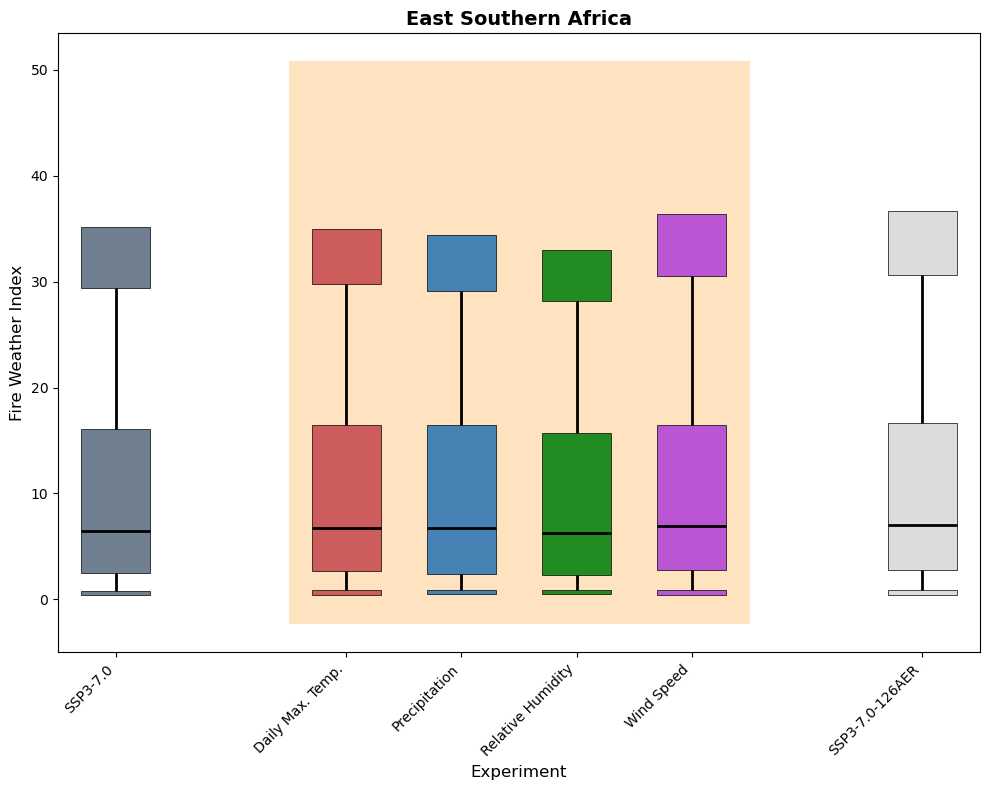

In [15]:
data_arrays = [ssp370_FWI_daily_esaf_avg, global_tasmax_FWI_daily_esaf_avg, global_pr_FWI_daily_esaf_avg, global_hurs_FWI_daily_esaf_avg, global_sfcWind_FWI_daily_esaf_avg, global_FWI_daily_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)


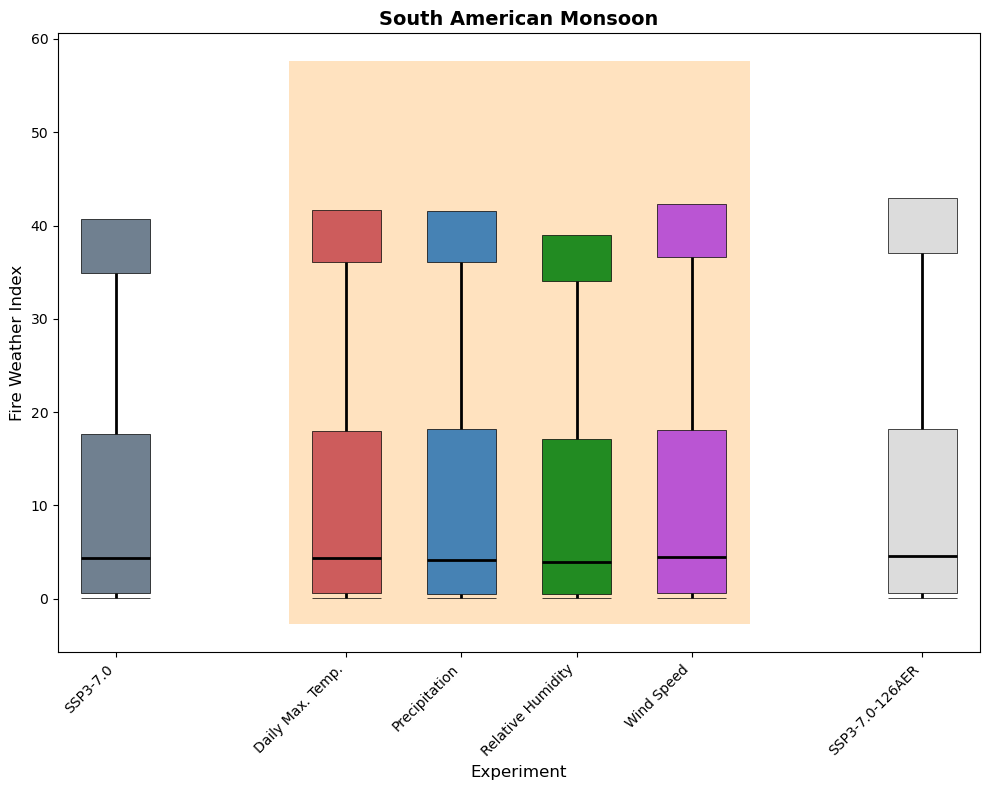

In [18]:
data_arrays = [ssp370_FWI_daily_sam_avg, global_tasmax_FWI_daily_sam_avg, global_pr_FWI_daily_sam_avg, global_hurs_FWI_daily_sam_avg, global_sfcWind_FWI_daily_sam_avg, global_FWI_daily_sam_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="South American Monsoon",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)


In [27]:
data_arrays = [ssp370_FWI_daily_nca_avg, global_tasmax_FWI_daily_nca_avg, global_pr_FWI_daily_nca_avg, global_hurs_FWI_daily_nca_avg, global_sfcWind_FWI_daily_nca_avg, global_FWI_daily_nca_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern Central America",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)


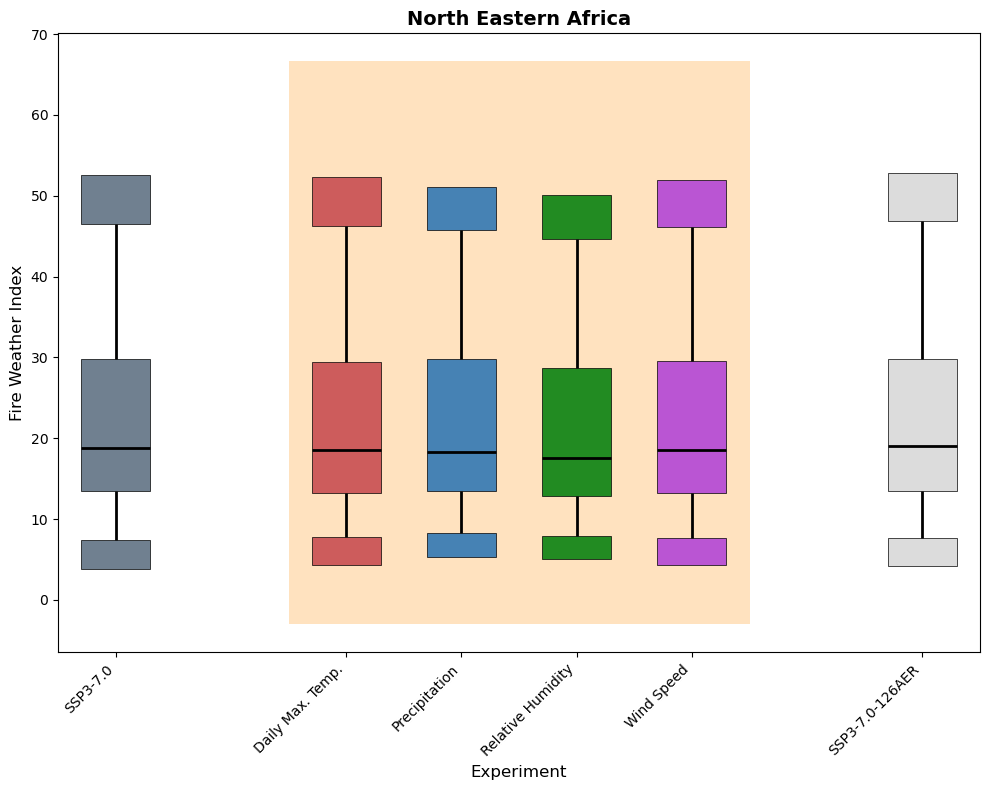

In [80]:
data_arrays = [ssp370_FWI_daily_neaf_avg, global_tasmax_FWI_daily_neaf_avg, global_pr_FWI_daily_neaf_avg, global_hurs_FWI_daily_neaf_avg, global_sfcWind_FWI_daily_neaf_avg, global_FWI_daily_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

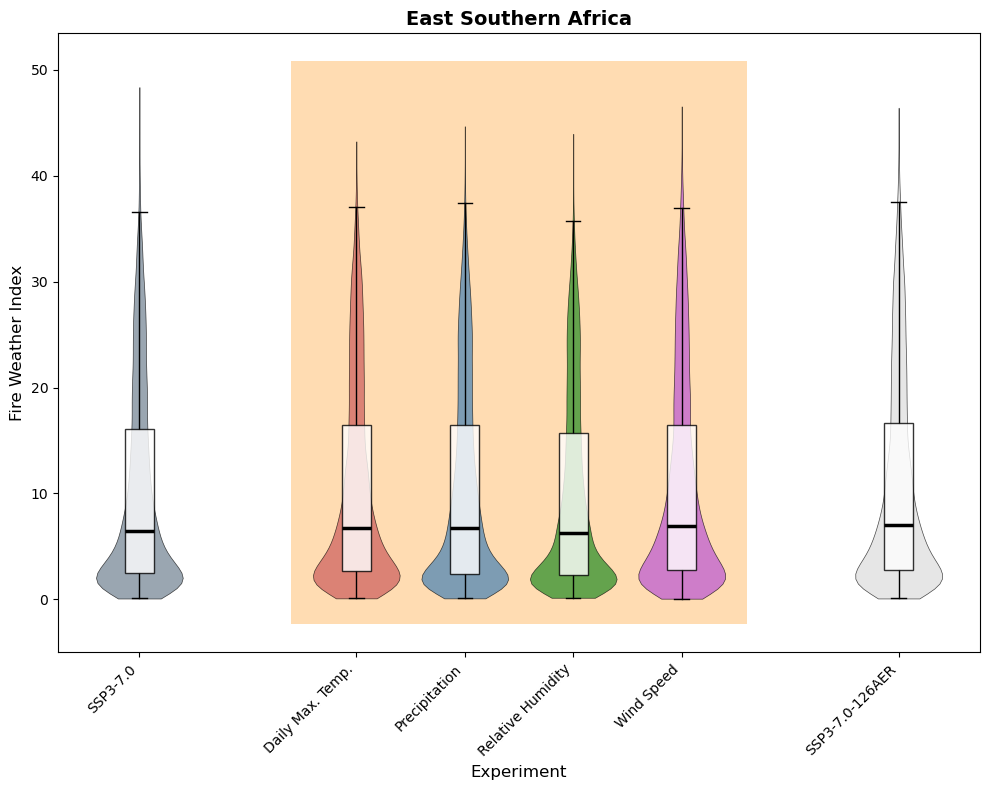

In [ ]:
data_arrays = [ssp370_FWI_daily_esaf_avg, global_tasmax_FWI_daily_esaf_avg, global_pr_FWI_daily_esaf_avg, global_hurs_FWI_daily_esaf_avg, global_sfcWind_FWI_daily_esaf_avg, global_FWI_daily_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

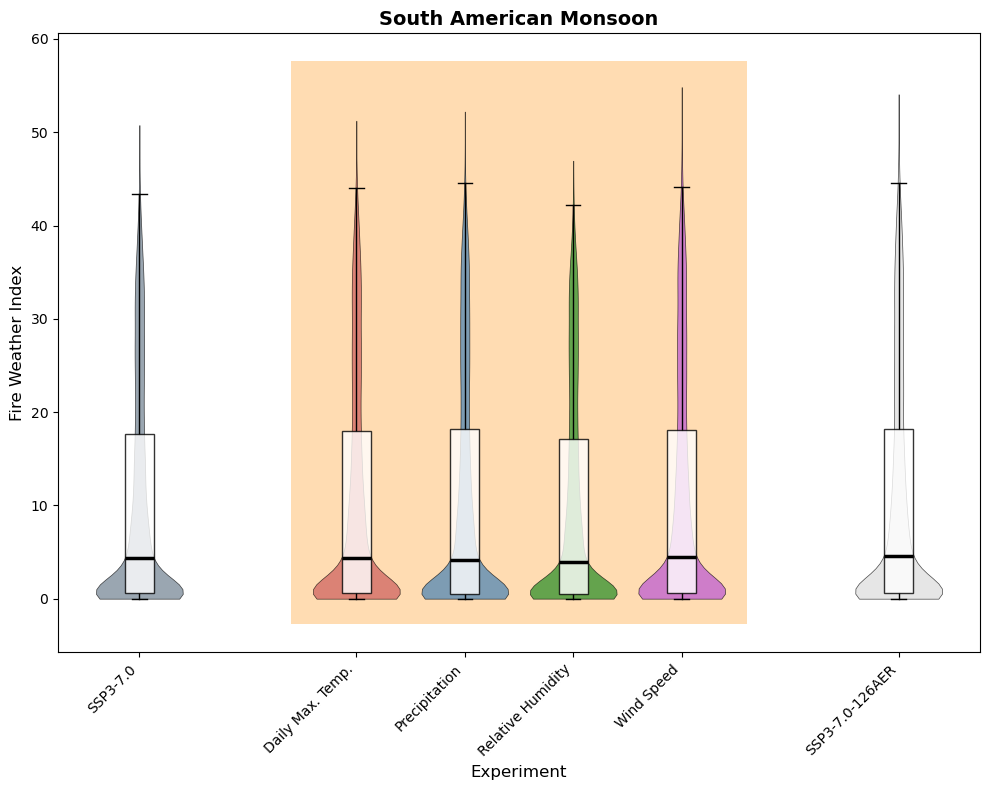

In [19]:
data_arrays = [ssp370_FWI_daily_sam_avg, global_tasmax_FWI_daily_sam_avg, global_pr_FWI_daily_sam_avg, global_hurs_FWI_daily_sam_avg, global_sfcWind_FWI_daily_sam_avg, global_FWI_daily_sam_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="South American Monsoon",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

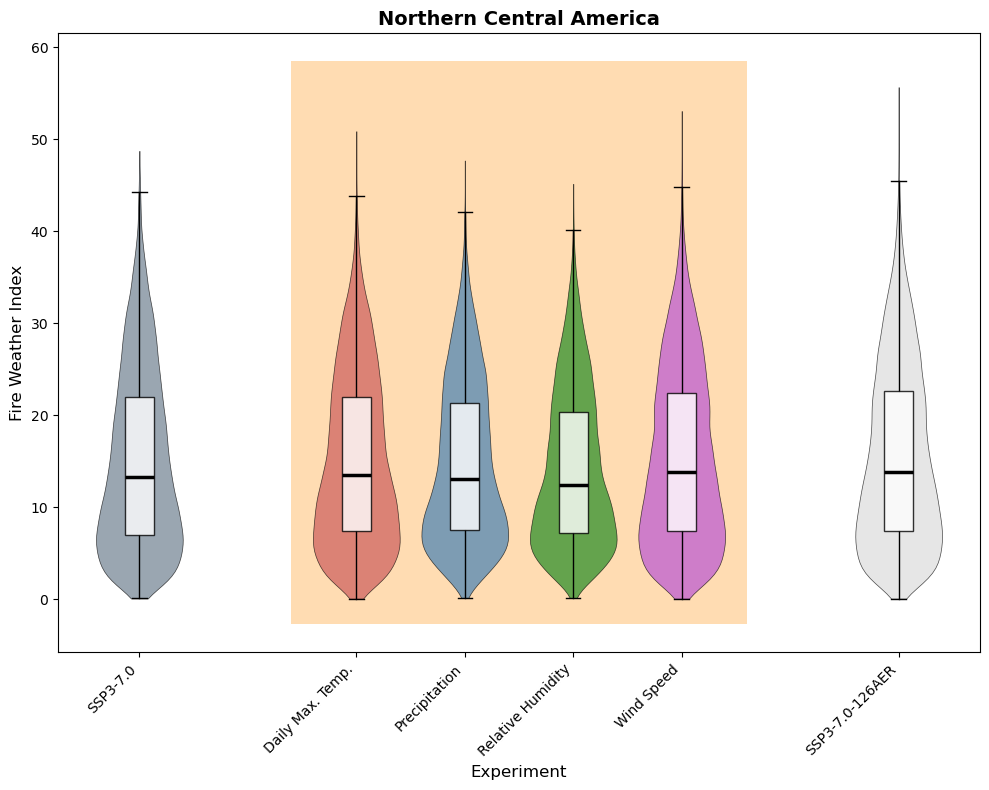

In [31]:
data_arrays = [ssp370_FWI_daily_nca_avg, global_tasmax_FWI_daily_nca_avg, global_pr_FWI_daily_nca_avg, global_hurs_FWI_daily_nca_avg, global_sfcWind_FWI_daily_nca_avg, global_FWI_daily_nca_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern Central America",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

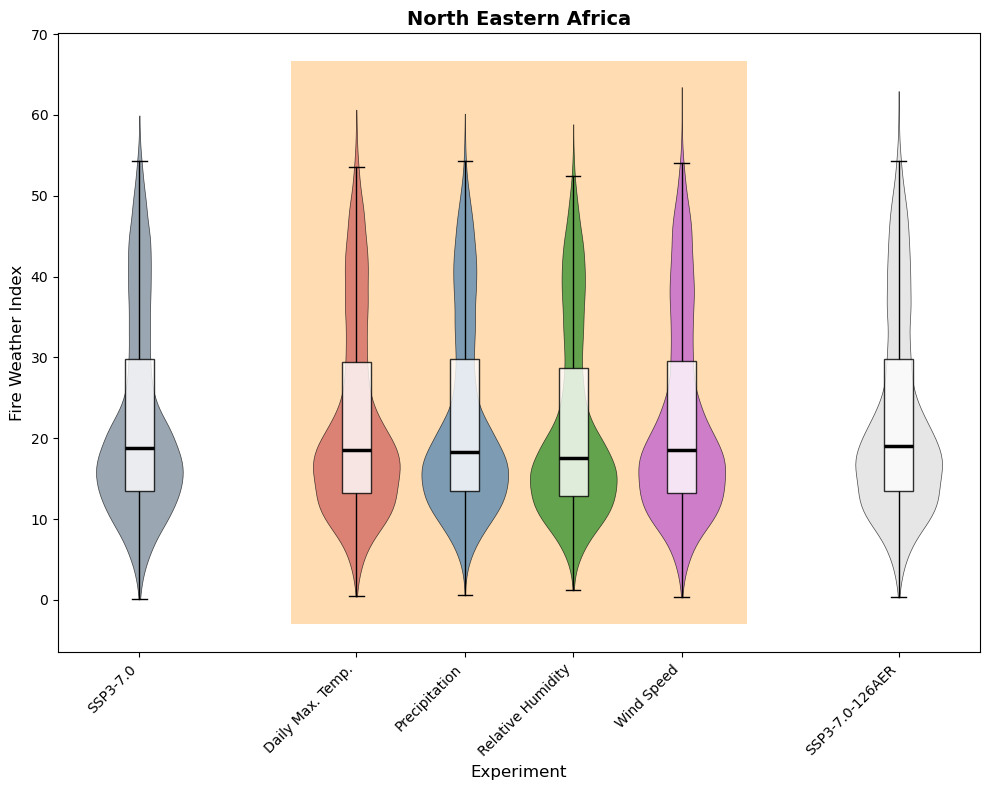

In [79]:
data_arrays = [ssp370_FWI_daily_neaf_avg, global_tasmax_FWI_daily_neaf_avg, global_pr_FWI_daily_neaf_avg, global_hurs_FWI_daily_neaf_avg, global_sfcWind_FWI_daily_neaf_avg, global_FWI_daily_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

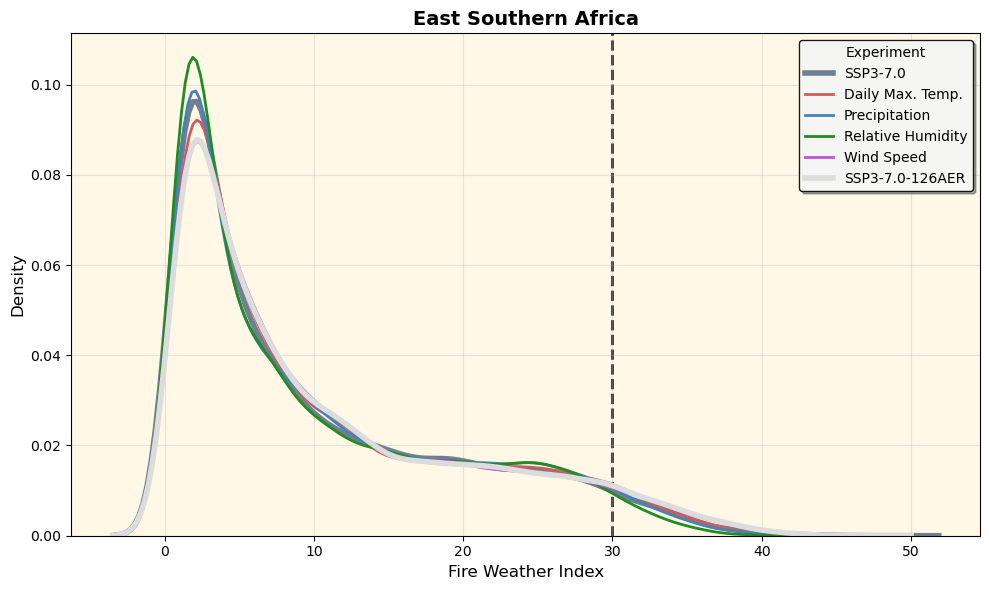

In [139]:
data_arrays = [ssp370_FWI_daily_esaf_avg, global_tasmax_FWI_daily_esaf_avg, global_pr_FWI_daily_esaf_avg, global_hurs_FWI_daily_esaf_avg, global_sfcWind_FWI_daily_esaf_avg, global_FWI_daily_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='East Southern Africa',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='white',
                                legend_edgecolor='black',
                                legend_shadow=True,
                                plot_facecolor='#fff8e7',
                                figsize=(10, 6), alpha=1)

plt.show()

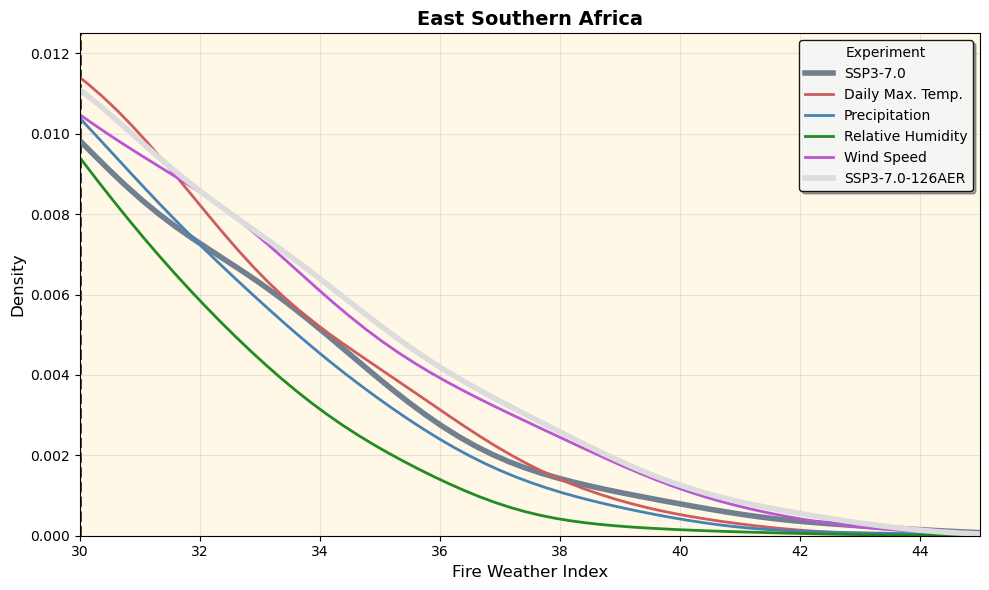

In [140]:
data_arrays = [ssp370_FWI_daily_esaf_avg, global_tasmax_FWI_daily_esaf_avg, global_pr_FWI_daily_esaf_avg, global_hurs_FWI_daily_esaf_avg, global_sfcWind_FWI_daily_esaf_avg, global_FWI_daily_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          xlim=(30, 45), ylim=(0, 0.0125),
                          figsize=(10, 6), alpha=1)

plt.show()

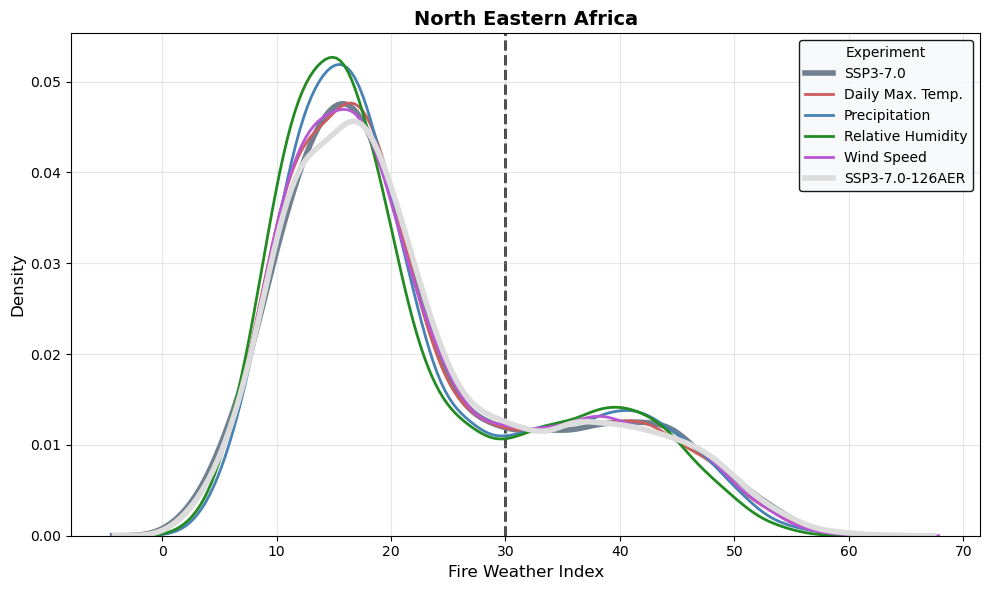

In [141]:
data_arrays = [ssp370_FWI_daily_neaf_avg, global_tasmax_FWI_daily_neaf_avg, global_pr_FWI_daily_neaf_avg, global_hurs_FWI_daily_neaf_avg, global_sfcWind_FWI_daily_neaf_avg, global_FWI_daily_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                figsize=(10, 6), alpha=1)

plt.show()

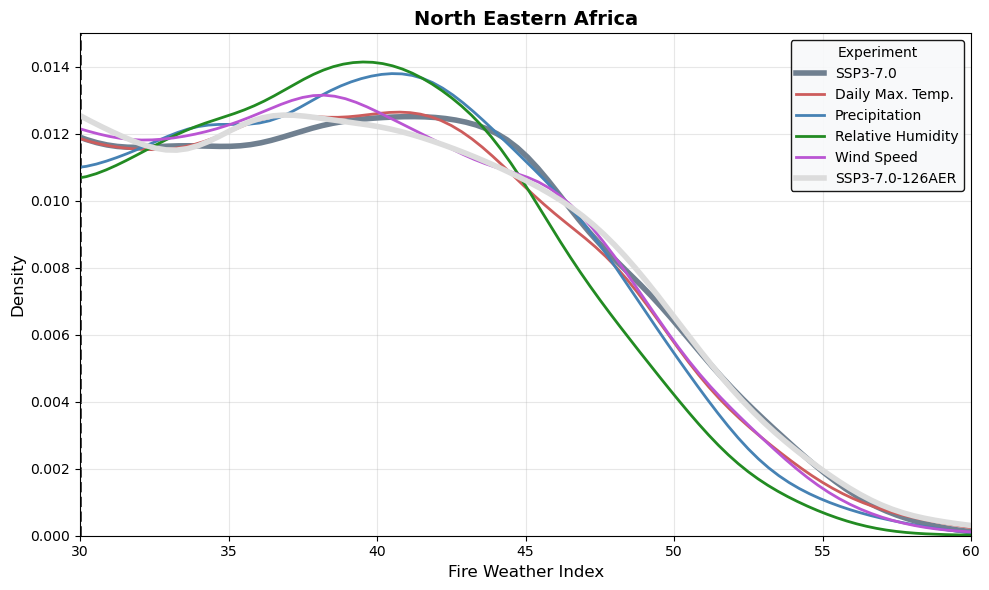

In [143]:
data_arrays = [ssp370_FWI_daily_neaf_avg, global_tasmax_FWI_daily_neaf_avg, global_pr_FWI_daily_neaf_avg, global_hurs_FWI_daily_neaf_avg, global_sfcWind_FWI_daily_neaf_avg, global_FWI_daily_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                xlim=(30, 60), ylim=(0, 0.015),
                                figsize=(10, 6), alpha=1)

plt.show()

In [21]:
ssp370_FWI_daily_esaf_avg.isel(member=0)

<xarray.DataArray 'FWI' (time: 3649)> Size: 29kB
array([0.83025016, 1.20034708, 2.20529864, ..., 7.86819033, 8.20429014,
       8.76230298], shape=(3649,))
Coordinates:
    member   <U9 36B 'r1i1p1f1'
  * time     (time) object 29kB 2041-01-01 12:00:00 ... 2050-12-30 12:00:00
    model    <U5 20B 'SPEAR'
    height   float64 8B 2.0

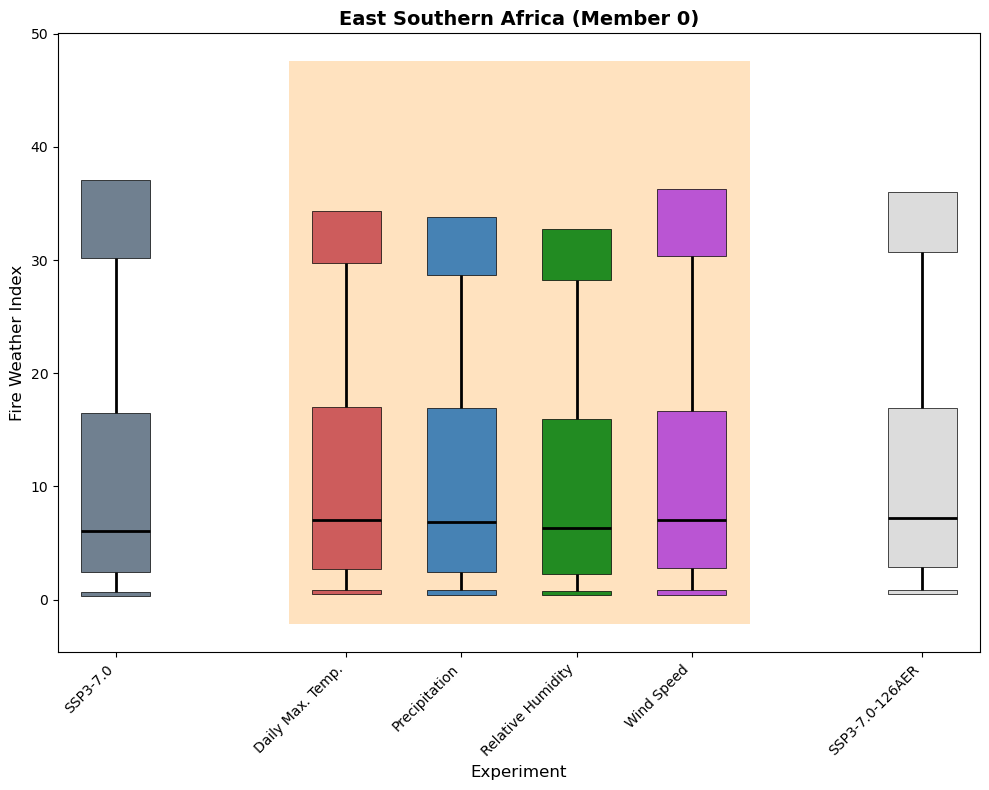

In [23]:
data_arrays = [ssp370_FWI_daily_esaf_avg.isel(member=0), global_tasmax_FWI_daily_esaf_avg.isel(member=0), global_pr_FWI_daily_esaf_avg.isel(member=0), global_hurs_FWI_daily_esaf_avg.isel(member=0), global_sfcWind_FWI_daily_esaf_avg.isel(member=0), global_FWI_daily_esaf_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

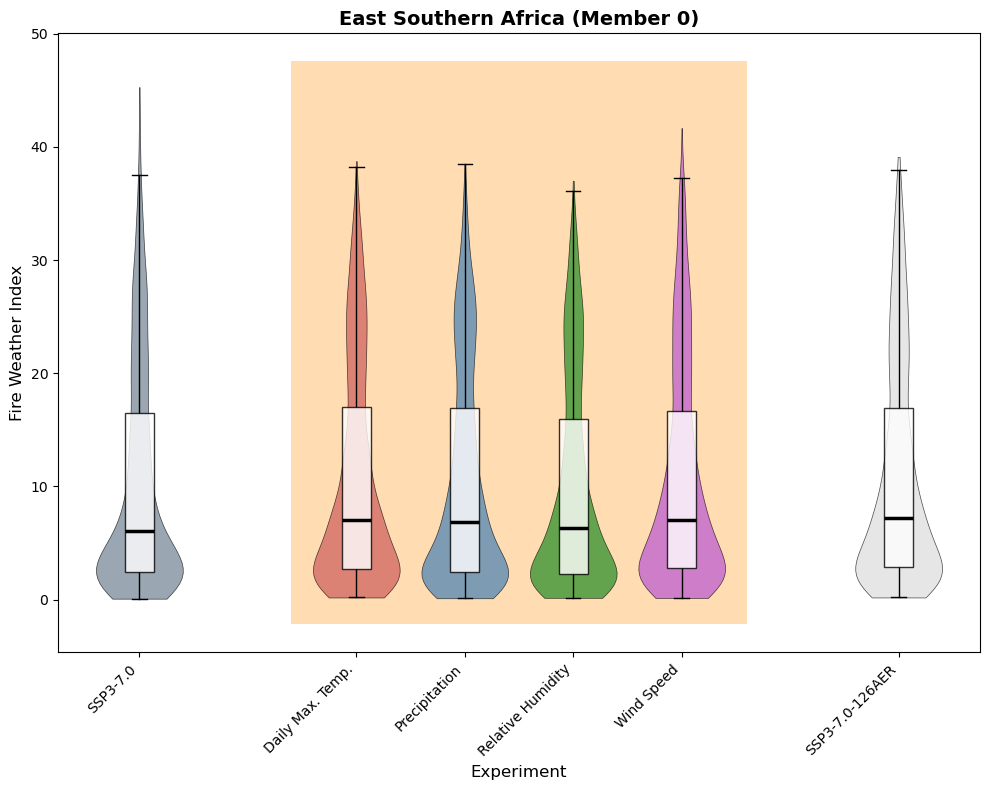

In [25]:
data_arrays = [ssp370_FWI_daily_esaf_avg.isel(member=0), global_tasmax_FWI_daily_esaf_avg.isel(member=0), global_pr_FWI_daily_esaf_avg.isel(member=0), global_hurs_FWI_daily_esaf_avg.isel(member=0), global_sfcWind_FWI_daily_esaf_avg.isel(member=0), global_FWI_daily_esaf_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

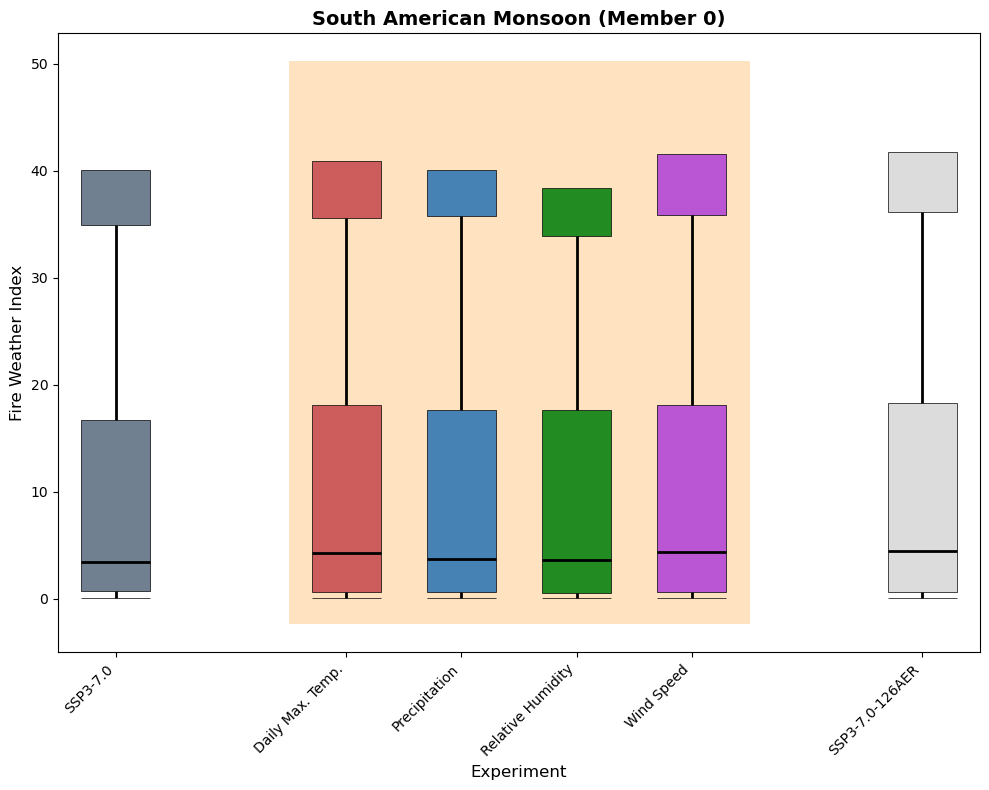

In [24]:
data_arrays = [ssp370_FWI_daily_sam_avg.isel(member=0), global_tasmax_FWI_daily_sam_avg.isel(member=0), global_pr_FWI_daily_sam_avg.isel(member=0), global_hurs_FWI_daily_sam_avg.isel(member=0), global_sfcWind_FWI_daily_sam_avg.isel(member=0), global_FWI_daily_sam_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="South American Monsoon (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)


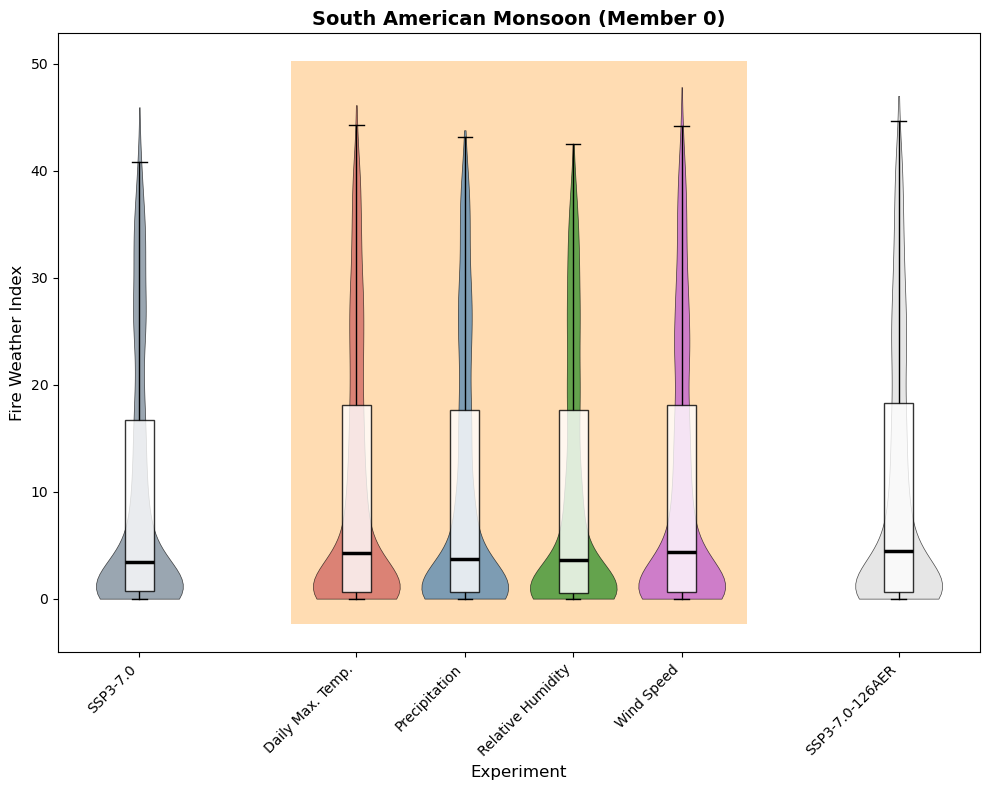

In [26]:
data_arrays = [ssp370_FWI_daily_sam_avg.isel(member=0), global_tasmax_FWI_daily_sam_avg.isel(member=0), global_pr_FWI_daily_sam_avg.isel(member=0), global_hurs_FWI_daily_sam_avg.isel(member=0), global_sfcWind_FWI_daily_sam_avg.isel(member=0), global_FWI_daily_sam_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="South American Monsoon (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

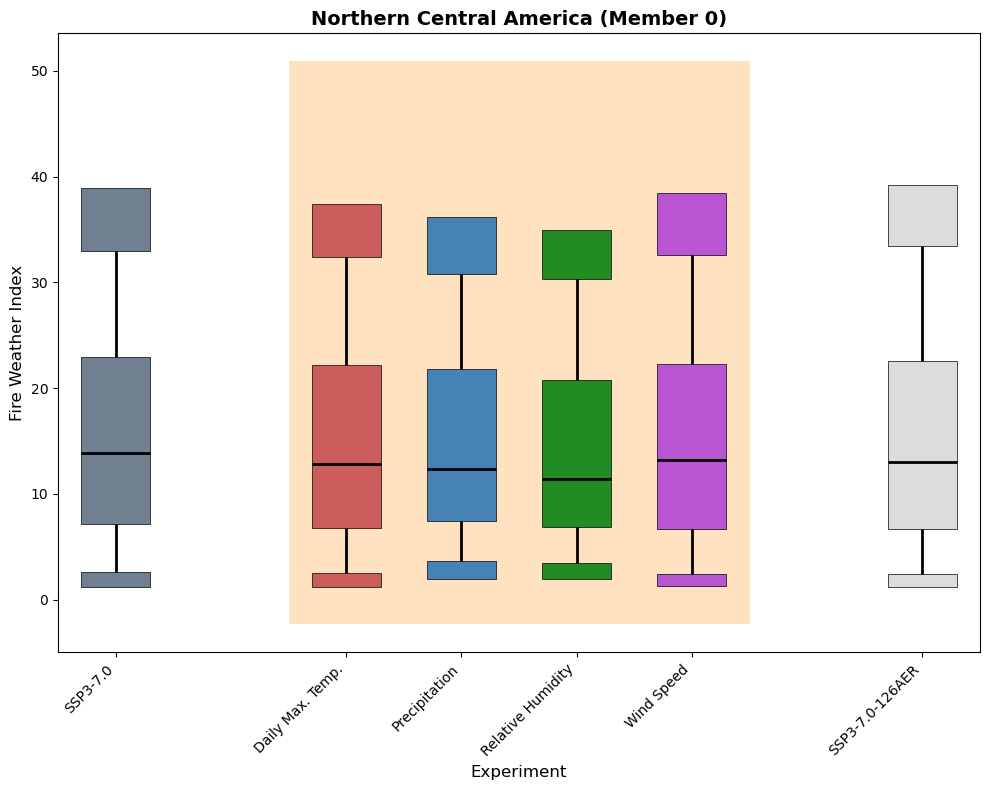

In [32]:
data_arrays = [ssp370_FWI_daily_nca_avg.isel(member=0), global_tasmax_FWI_daily_nca_avg.isel(member=0), global_pr_FWI_daily_nca_avg.isel(member=0), global_hurs_FWI_daily_nca_avg.isel(member=0), global_sfcWind_FWI_daily_nca_avg.isel(member=0), global_FWI_daily_nca_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern Central America (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

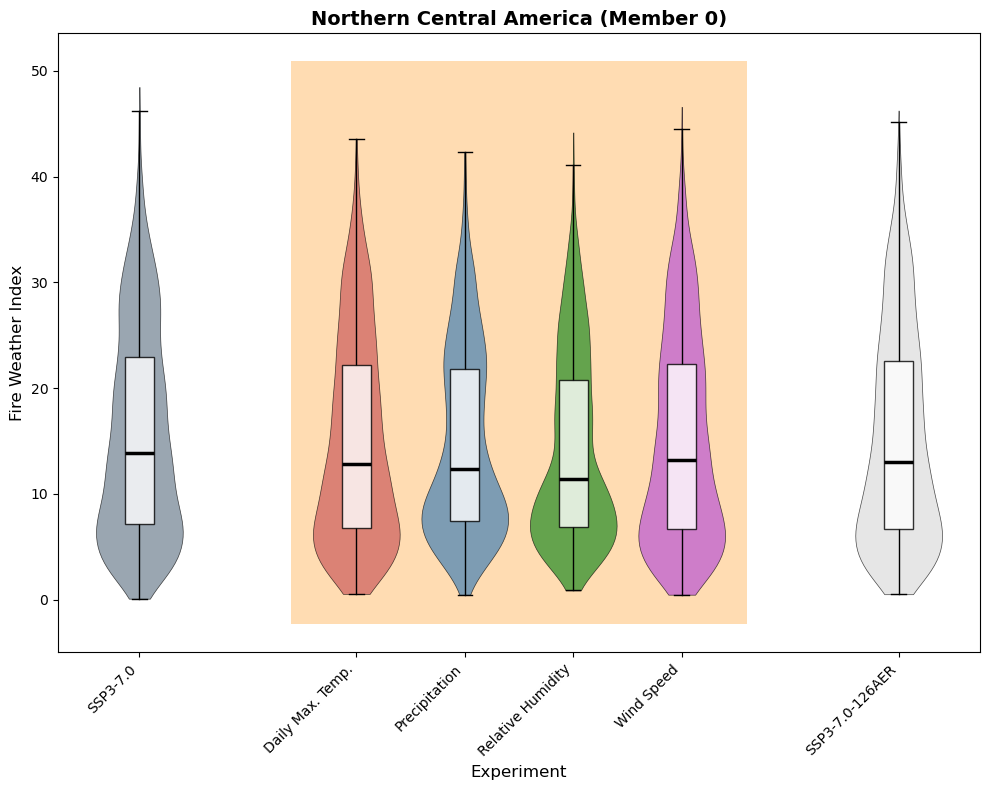

In [33]:
data_arrays = [ssp370_FWI_daily_nca_avg.isel(member=0), global_tasmax_FWI_daily_nca_avg.isel(member=0), global_pr_FWI_daily_nca_avg.isel(member=0), global_hurs_FWI_daily_nca_avg.isel(member=0), global_sfcWind_FWI_daily_nca_avg.isel(member=0), global_FWI_daily_nca_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern Central America (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

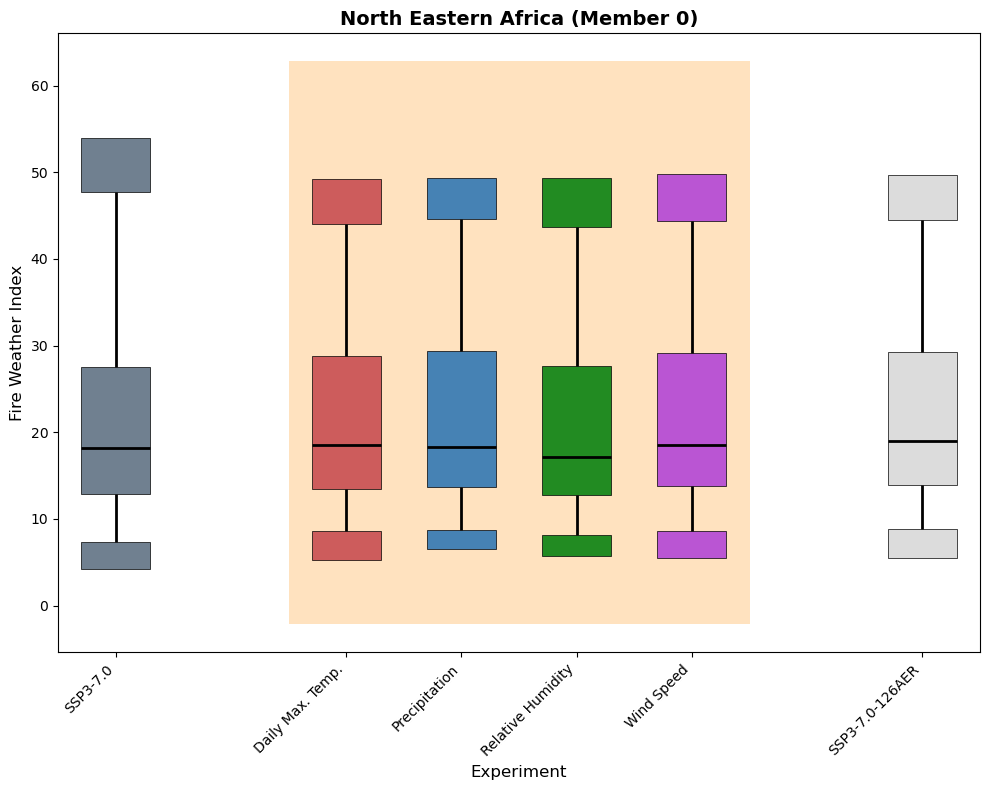

In [82]:
data_arrays = [ssp370_FWI_daily_neaf_avg.isel(member=0), global_tasmax_FWI_daily_neaf_avg.isel(member=0), global_pr_FWI_daily_neaf_avg.isel(member=0), global_hurs_FWI_daily_neaf_avg.isel(member=0), global_sfcWind_FWI_daily_neaf_avg.isel(member=0), global_FWI_daily_neaf_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

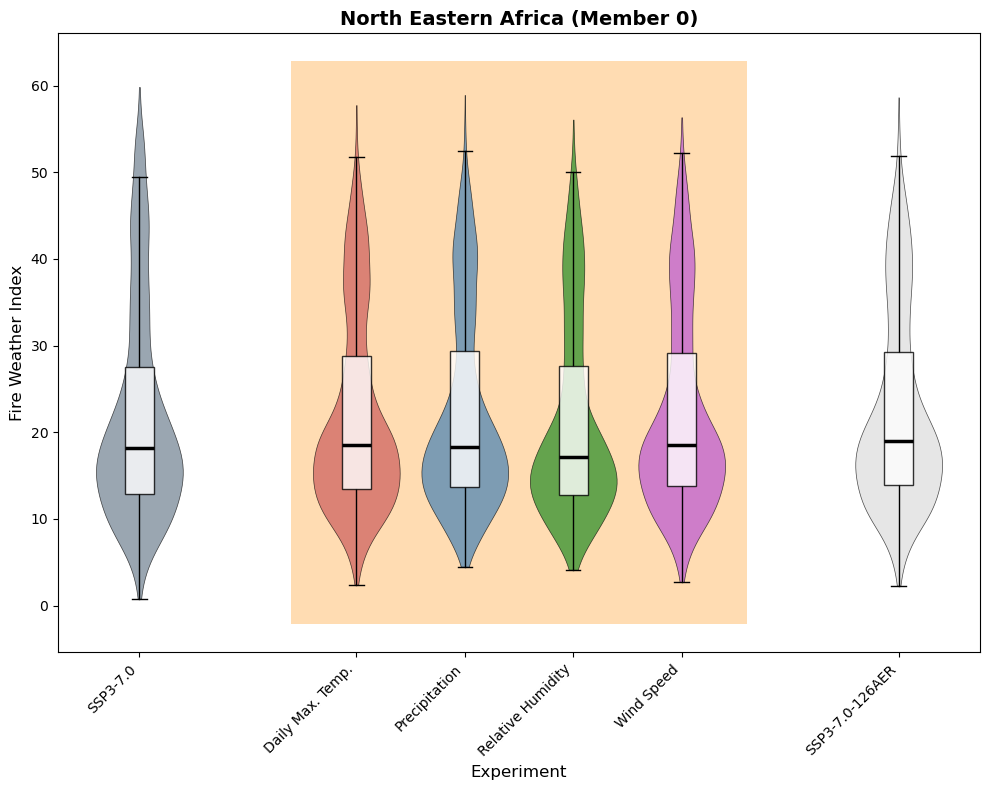

In [81]:
data_arrays = [ssp370_FWI_daily_neaf_avg.isel(member=0), global_tasmax_FWI_daily_neaf_avg.isel(member=0), global_pr_FWI_daily_neaf_avg.isel(member=0), global_hurs_FWI_daily_neaf_avg.isel(member=0), global_sfcWind_FWI_daily_neaf_avg.isel(member=0), global_FWI_daily_neaf_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

# Regional Daily Analysis by Season

In [129]:
# Get daily data for non-barren land

ssp370_FWI_daily = ssp370_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"ssp370_FWI_daily is ready")
global_FWI_daily = global_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_FWI_daily is ready")
global_hurs_FWI_daily = global_hurs_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_hurs_FWI_daily is ready")
global_pr_FWI_daily = global_pr_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_pr_FWI_daily is ready")
global_sfcWind_FWI_daily = global_sfcWind_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_sfcWind_FWI_daily is ready")
global_tasmax_FWI_daily = global_tasmax_FWI.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_tasmax_FWI_daily is ready")


ssp370_FWI_daily is ready
global_FWI_daily is ready
global_hurs_FWI_daily is ready
global_pr_FWI_daily is ready
global_sfcWind_FWI_daily is ready
global_tasmax_FWI_daily is ready


In [130]:
# Group by season

ssp370_FWI_daily_seasonal = ssp370_FWI_daily.groupby('time.season')
print(f"ssp370_FWI_daily_seasonal is ready")
global_FWI_daily_seasonal = global_FWI_daily.groupby('time.season')
print(f"global_FWI_daily_seasonal is ready")
global_hurs_FWI_daily_seasonal = global_hurs_FWI_daily.groupby('time.season')
print(f"global_hurs_FWI_daily_seasonal is ready")
global_pr_FWI_daily_seasonal = global_pr_FWI_daily.groupby('time.season')
print(f"global_pr_FWI_daily_seasonal is ready")
global_sfcWind_FWI_daily_seasonal = global_sfcWind_FWI_daily.groupby('time.season')
print(f"global_sfcWind_FWI_daily_seasonal is ready")
global_tasmax_FWI_daily_seasonal = global_tasmax_FWI_daily.groupby('time.season')
print(f"global_tasmax_FWI_daily_seasonal is ready")


ssp370_FWI_daily_seasonal is ready
global_FWI_daily_seasonal is ready
global_hurs_FWI_daily_seasonal is ready
global_pr_FWI_daily_seasonal is ready
global_sfcWind_FWI_daily_seasonal is ready
global_tasmax_FWI_daily_seasonal is ready


In [131]:
# Make dictionaries of daily data by season

ssp370_FWI_daily_seasonal = {
    season: ssp370_FWI_daily.sel(time=ssp370_FWI_daily['time.season'] == season)
    for season in ['DJF', 'MAM', 'JJA', 'SON']
}
print(f"ssp370_FWI_daily_seasonal is ready")

global_FWI_daily_seasonal = {
    season: global_FWI_daily.sel(time=global_FWI_daily['time.season'] == season)
    for season in ['DJF', 'MAM', 'JJA', 'SON']
}
print(f"global_FWI_daily_seasonal is ready")

global_hurs_FWI_daily_seasonal = {
    season: global_hurs_FWI_daily.sel(time=global_hurs_FWI_daily['time.season'] == season)
    for season in ['DJF', 'MAM', 'JJA', 'SON']
}
print(f"global_hurs_FWI_daily_seasonal is ready")

global_pr_FWI_daily_seasonal = {
    season: global_pr_FWI_daily.sel(time=global_pr_FWI_daily['time.season'] == season)
    for season in ['DJF', 'MAM', 'JJA', 'SON']
}
print(f"global_pr_FWI_daily_seasonal is ready")

global_sfcWind_FWI_daily_seasonal = {
    season: global_sfcWind_FWI_daily.sel(time=global_sfcWind_FWI_daily['time.season'] == season)
    for season in ['DJF', 'MAM', 'JJA', 'SON']
}
print(f"global_sfcWind_FWI_daily_seasonal is ready")

global_tasmax_FWI_daily_seasonal = {
    season: global_tasmax_FWI_daily.sel(time=global_tasmax_FWI_daily['time.season'] == season)
    for season in ['DJF', 'MAM', 'JJA', 'SON']
}
print(f"global_tasmax_FWI_daily_seasonal is ready")


ssp370_FWI_daily_seasonal is ready
global_FWI_daily_seasonal is ready
global_hurs_FWI_daily_seasonal is ready
global_pr_FWI_daily_seasonal is ready
global_sfcWind_FWI_daily_seasonal is ready
global_tasmax_FWI_daily_seasonal is ready


In [132]:
# Specify season

# jja
ssp370_FWI_daily_seasonal_jja =ssp370_FWI_daily_seasonal['JJA']
print(f"ssp370_FWI_daily_seasonal_jja is ready")
global_FWI_daily_seasonal_jja = global_FWI_daily_seasonal['JJA']
print(f"global_FWI_daily_seasonal_jja is ready")
global_hurs_FWI_daily_seasonal_jja = global_hurs_FWI_daily_seasonal['JJA']
print(f"global_hurs_FWI_daily_seasonal_jja is ready")
global_pr_FWI_daily_seasonal_jja = global_pr_FWI_daily_seasonal['JJA']
print(f"global_pr_FWI_daily_seasonal_jja is ready")
global_sfcWind_FWI_daily_seasonal_jja = global_sfcWind_FWI_daily_seasonal['JJA']
print(f"global_sfcWind_FWI_daily_seasonal_jja is ready")
global_tasmax_FWI_daily_seasonal_jja = global_tasmax_FWI_daily_seasonal['JJA']
print(f"global_tasmax_FWI_daily_seasonal_jja is ready")

# son
ssp370_FWI_daily_seasonal_son =ssp370_FWI_daily_seasonal['SON']
print(f"ssp370_FWI_daily_seasonal_son is ready")
global_FWI_daily_seasonal_son = global_FWI_daily_seasonal['SON']
print(f"global_FWI_daily_seasonal_son is ready")
global_hurs_FWI_daily_seasonal_son = global_hurs_FWI_daily_seasonal['SON']
print(f"global_hurs_FWI_daily_seasonal_son is ready")
global_pr_FWI_daily_seasonal_son = global_pr_FWI_daily_seasonal['SON']
print(f"global_pr_FWI_daily_seasonal_son is ready")
global_sfcWind_FWI_daily_seasonal_son = global_sfcWind_FWI_daily_seasonal['SON']
print(f"global_sfcWind_FWI_daily_seasonal_son is ready")
global_tasmax_FWI_daily_seasonal_son = global_tasmax_FWI_daily_seasonal['SON']
print(f"global_tasmax_FWI_daily_seasonal_son is ready")

# djf
ssp370_FWI_daily_seasonal_djf =ssp370_FWI_daily_seasonal['DJF']
print(f"ssp370_FWI_daily_seasonal_djf is ready")
global_FWI_daily_seasonal_djf = global_FWI_daily_seasonal['DJF']
print(f"global_FWI_daily_seasonal_djf is ready")
global_hurs_FWI_daily_seasonal_djf = global_hurs_FWI_daily_seasonal['DJF']
print(f"global_hurs_FWI_daily_seasonal_djf is ready")
global_pr_FWI_daily_seasonal_djf = global_pr_FWI_daily_seasonal['DJF']
print(f"global_pr_FWI_daily_seasonal_djf is ready")
global_sfcWind_FWI_daily_seasonal_djf = global_sfcWind_FWI_daily_seasonal['DJF']
print(f"global_sfcWind_FWI_daily_seasonal_djf is ready")
global_tasmax_FWI_daily_seasonal_djf = global_tasmax_FWI_daily_seasonal['DJF']
print(f"global_tasmax_FWI_daily_seasonal_djf is ready")

# mam
ssp370_FWI_daily_seasonal_mam =ssp370_FWI_daily_seasonal['MAM']
print(f"ssp370_FWI_daily_seasonal_mam is ready")
global_FWI_daily_seasonal_mam = global_FWI_daily_seasonal['MAM']
print(f"global_FWI_daily_seasonal_mam is ready")
global_hurs_FWI_daily_seasonal_mam = global_hurs_FWI_daily_seasonal['MAM']
print(f"global_hurs_FWI_daily_seasonal_mam is ready")
global_pr_FWI_daily_seasonal_mam = global_pr_FWI_daily_seasonal['MAM']
print(f"global_pr_FWI_daily_seasonal_mam is ready")
global_sfcWind_FWI_daily_seasonal_mam = global_sfcWind_FWI_daily_seasonal['MAM']
print(f"global_sfcWind_FWI_daily_seasonal_mam is ready")
global_tasmax_FWI_daily_seasonal_mam = global_tasmax_FWI_daily_seasonal['MAM']
print(f"global_tasmax_FWI_daily_seasonal_mam is ready")


ssp370_FWI_daily_seasonal_jja is ready
global_FWI_daily_seasonal_jja is ready
global_hurs_FWI_daily_seasonal_jja is ready
global_pr_FWI_daily_seasonal_jja is ready
global_sfcWind_FWI_daily_seasonal_jja is ready
global_tasmax_FWI_daily_seasonal_jja is ready
ssp370_FWI_daily_seasonal_son is ready
global_FWI_daily_seasonal_son is ready
global_hurs_FWI_daily_seasonal_son is ready
global_pr_FWI_daily_seasonal_son is ready
global_sfcWind_FWI_daily_seasonal_son is ready
global_tasmax_FWI_daily_seasonal_son is ready
ssp370_FWI_daily_seasonal_djf is ready
global_FWI_daily_seasonal_djf is ready
global_hurs_FWI_daily_seasonal_djf is ready
global_pr_FWI_daily_seasonal_djf is ready
global_sfcWind_FWI_daily_seasonal_djf is ready
global_tasmax_FWI_daily_seasonal_djf is ready
ssp370_FWI_daily_seasonal_mam is ready
global_FWI_daily_seasonal_mam is ready
global_hurs_FWI_daily_seasonal_mam is ready
global_pr_FWI_daily_seasonal_mam is ready
global_sfcWind_FWI_daily_seasonal_mam is ready
global_tasmax_FWI_

In [133]:
# Group by region

# jja
ssp370_FWI_daily_seasonal_jja_region = ssp370_FWI_daily_seasonal_jja.groupby(mask)
print(f"ssp370_FWI_daily_seasonal_jja_region is ready")
global_FWI_daily_seasonal_jja_region = global_FWI_daily_seasonal_jja.groupby(mask)
print(f"global_FWI_daily_seasonal_jja_region is ready")
global_hurs_FWI_daily_seasonal_jja_region = global_hurs_FWI_daily_seasonal_jja.groupby(mask)
print(f"global_hurs_FWI_daily_seasonal_jja_region is ready")
global_pr_FWI_daily_seasonal_jja_region = global_pr_FWI_daily_seasonal_jja.groupby(mask)
print(f"global_pr_FWI_daily_seasonal_jja_region is ready")
global_sfcWind_FWI_daily_seasonal_jja_region = global_sfcWind_FWI_daily_seasonal_jja.groupby(mask)
print(f"global_sfcWind_FWI_daily_seasonal_jja_region is ready")
global_tasmax_FWI_daily_seasonal_jja_region = global_tasmax_FWI_daily_seasonal_jja.groupby(mask)
print(f"global_tasmax_FWI_daily_seasonal_jja_region is ready")

# son
ssp370_FWI_daily_seasonal_son_region = ssp370_FWI_daily_seasonal_son.groupby(mask)
print(f"ssp370_FWI_daily_seasonal_son_region is ready")
global_FWI_daily_seasonal_son_region = global_FWI_daily_seasonal_son.groupby(mask)
print(f"global_FWI_daily_seasonal_son_region is ready")
global_hurs_FWI_daily_seasonal_son_region = global_hurs_FWI_daily_seasonal_son.groupby(mask)
print(f"global_hurs_FWI_daily_seasonal_son_region is ready")
global_pr_FWI_daily_seasonal_son_region = global_pr_FWI_daily_seasonal_son.groupby(mask)
print(f"global_pr_FWI_daily_seasonal_son_region is ready")
global_sfcWind_FWI_daily_seasonal_son_region = global_sfcWind_FWI_daily_seasonal_son.groupby(mask)
print(f"global_sfcWind_FWI_daily_seasonal_son_region is ready")
global_tasmax_FWI_daily_seasonal_son_region = global_tasmax_FWI_daily_seasonal_son.groupby(mask)
print(f"global_tasmax_FWI_daily_seasonal_son_region is ready")

# djf
ssp370_FWI_daily_seasonal_djf_region = ssp370_FWI_daily_seasonal_djf.groupby(mask)
print(f"ssp370_FWI_daily_seasonal_djf_region is ready")
global_FWI_daily_seasonal_djf_region = global_FWI_daily_seasonal_djf.groupby(mask)
print(f"global_FWI_daily_seasonal_djf_region is ready")
global_hurs_FWI_daily_seasonal_djf_region = global_hurs_FWI_daily_seasonal_djf.groupby(mask)
print(f"global_hurs_FWI_daily_seasonal_djf_region is ready")
global_pr_FWI_daily_seasonal_djf_region = global_pr_FWI_daily_seasonal_djf.groupby(mask)
print(f"global_pr_FWI_daily_seasonal_djf_region is ready")
global_sfcWind_FWI_daily_seasonal_djf_region = global_sfcWind_FWI_daily_seasonal_djf.groupby(mask)
print(f"global_sfcWind_FWI_daily_seasonal_djf_region is ready")
global_tasmax_FWI_daily_seasonal_djf_region = global_tasmax_FWI_daily_seasonal_djf.groupby(mask)
print(f"global_tasmax_FWI_daily_seasonal_djf_region is ready")

# mam
ssp370_FWI_daily_seasonal_mam_region = ssp370_FWI_daily_seasonal_mam.groupby(mask)
print(f"ssp370_FWI_daily_seasonal_mam_region is ready")
global_FWI_daily_seasonal_mam_region = global_FWI_daily_seasonal_mam.groupby(mask)
print(f"global_FWI_daily_seasonal_mam_region is ready")
global_hurs_FWI_daily_seasonal_mam_region = global_hurs_FWI_daily_seasonal_mam.groupby(mask)
print(f"global_hurs_FWI_daily_seasonal_mam_region is ready")
global_pr_FWI_daily_seasonal_mam_region = global_pr_FWI_daily_seasonal_mam.groupby(mask)
print(f"global_pr_FWI_daily_seasonal_mam_region is ready")
global_sfcWind_FWI_daily_seasonal_mam_region = global_sfcWind_FWI_daily_seasonal_mam.groupby(mask)
print(f"global_sfcWind_FWI_daily_seasonal_mam_region is ready")
global_tasmax_FWI_daily_seasonal_mam_region = global_tasmax_FWI_daily_seasonal_mam.groupby(mask)
print(f"global_tasmax_FWI_daily_seasonal_mam_region is ready")


ssp370_FWI_daily_seasonal_jja_region is ready
global_FWI_daily_seasonal_jja_region is ready
global_hurs_FWI_daily_seasonal_jja_region is ready
global_pr_FWI_daily_seasonal_jja_region is ready
global_sfcWind_FWI_daily_seasonal_jja_region is ready
global_tasmax_FWI_daily_seasonal_jja_region is ready
ssp370_FWI_daily_seasonal_son_region is ready
global_FWI_daily_seasonal_son_region is ready
global_hurs_FWI_daily_seasonal_son_region is ready
global_pr_FWI_daily_seasonal_son_region is ready
global_sfcWind_FWI_daily_seasonal_son_region is ready
global_tasmax_FWI_daily_seasonal_son_region is ready
ssp370_FWI_daily_seasonal_djf_region is ready
global_FWI_daily_seasonal_djf_region is ready
global_hurs_FWI_daily_seasonal_djf_region is ready
global_pr_FWI_daily_seasonal_djf_region is ready
global_sfcWind_FWI_daily_seasonal_djf_region is ready
global_tasmax_FWI_daily_seasonal_djf_region is ready
ssp370_FWI_daily_seasonal_mam_region is ready
global_FWI_daily_seasonal_mam_region is ready
global_hurs

In [134]:
# Unpack the lat/lon coordinates of the grouped data

# jja

# ssp370
ssp370_FWI_daily_seasonal_jja_nwn = ssp370_FWI_daily_seasonal_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_nen = ssp370_FWI_daily_seasonal_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_wna = ssp370_FWI_daily_seasonal_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_cna = ssp370_FWI_daily_seasonal_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_ena = ssp370_FWI_daily_seasonal_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_nca = ssp370_FWI_daily_seasonal_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_nsa = ssp370_FWI_daily_seasonal_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_nes = ssp370_FWI_daily_seasonal_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_sam = ssp370_FWI_daily_seasonal_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_med = ssp370_FWI_daily_seasonal_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_waf = ssp370_FWI_daily_seasonal_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_caf = ssp370_FWI_daily_seasonal_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_neaf = ssp370_FWI_daily_seasonal_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_seaf = ssp370_FWI_daily_seasonal_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_wsaf = ssp370_FWI_daily_seasonal_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_esaf = ssp370_FWI_daily_seasonal_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_esb = ssp370_FWI_daily_seasonal_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_rfe = ssp370_FWI_daily_seasonal_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_sea = ssp370_FWI_daily_seasonal_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_eau = ssp370_FWI_daily_seasonal_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_jja_sau = ssp370_FWI_daily_seasonal_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_daily_seasonal_jja_nwn = global_FWI_daily_seasonal_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_nen = global_FWI_daily_seasonal_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_wna = global_FWI_daily_seasonal_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_cna = global_FWI_daily_seasonal_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_ena = global_FWI_daily_seasonal_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_nca = global_FWI_daily_seasonal_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_nsa = global_FWI_daily_seasonal_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_nes = global_FWI_daily_seasonal_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_sam = global_FWI_daily_seasonal_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_med = global_FWI_daily_seasonal_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_waf = global_FWI_daily_seasonal_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_caf = global_FWI_daily_seasonal_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_neaf = global_FWI_daily_seasonal_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_seaf = global_FWI_daily_seasonal_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_wsaf = global_FWI_daily_seasonal_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_esaf = global_FWI_daily_seasonal_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_esb = global_FWI_daily_seasonal_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_rfe = global_FWI_daily_seasonal_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_sea = global_FWI_daily_seasonal_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_eau = global_FWI_daily_seasonal_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_jja_sau = global_FWI_daily_seasonal_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_daily_seasonal_jja_nwn = global_hurs_FWI_daily_seasonal_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_nen = global_hurs_FWI_daily_seasonal_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_wna = global_hurs_FWI_daily_seasonal_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_cna = global_hurs_FWI_daily_seasonal_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_ena = global_hurs_FWI_daily_seasonal_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_nca = global_hurs_FWI_daily_seasonal_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_nsa = global_hurs_FWI_daily_seasonal_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_nes = global_hurs_FWI_daily_seasonal_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_sam = global_hurs_FWI_daily_seasonal_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_med = global_hurs_FWI_daily_seasonal_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_waf = global_hurs_FWI_daily_seasonal_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_caf = global_hurs_FWI_daily_seasonal_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_neaf = global_hurs_FWI_daily_seasonal_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_seaf = global_hurs_FWI_daily_seasonal_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_wsaf = global_hurs_FWI_daily_seasonal_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_esaf = global_hurs_FWI_daily_seasonal_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_esb = global_hurs_FWI_daily_seasonal_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_rfe = global_hurs_FWI_daily_seasonal_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_sea = global_hurs_FWI_daily_seasonal_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_eau = global_hurs_FWI_daily_seasonal_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_jja_sau = global_hurs_FWI_daily_seasonal_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_daily_seasonal_jja_nwn = global_pr_FWI_daily_seasonal_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_nen = global_pr_FWI_daily_seasonal_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_wna = global_pr_FWI_daily_seasonal_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_cna = global_pr_FWI_daily_seasonal_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_ena = global_pr_FWI_daily_seasonal_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_nca = global_pr_FWI_daily_seasonal_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_nsa = global_pr_FWI_daily_seasonal_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_nes = global_pr_FWI_daily_seasonal_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_sam = global_pr_FWI_daily_seasonal_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_med = global_pr_FWI_daily_seasonal_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_waf = global_pr_FWI_daily_seasonal_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_caf = global_pr_FWI_daily_seasonal_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_neaf = global_pr_FWI_daily_seasonal_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_seaf = global_pr_FWI_daily_seasonal_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_wsaf = global_pr_FWI_daily_seasonal_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_esaf = global_pr_FWI_daily_seasonal_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_esb = global_pr_FWI_daily_seasonal_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_rfe = global_pr_FWI_daily_seasonal_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_sea = global_pr_FWI_daily_seasonal_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_eau = global_pr_FWI_daily_seasonal_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_jja_sau = global_pr_FWI_daily_seasonal_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_jja_nwn = global_sfcWind_FWI_daily_seasonal_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_nen = global_sfcWind_FWI_daily_seasonal_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_wna = global_sfcWind_FWI_daily_seasonal_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_cna = global_sfcWind_FWI_daily_seasonal_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_ena = global_sfcWind_FWI_daily_seasonal_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_nca = global_sfcWind_FWI_daily_seasonal_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_nsa = global_sfcWind_FWI_daily_seasonal_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_nes = global_sfcWind_FWI_daily_seasonal_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_sam = global_sfcWind_FWI_daily_seasonal_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_med = global_sfcWind_FWI_daily_seasonal_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_waf = global_sfcWind_FWI_daily_seasonal_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_caf = global_sfcWind_FWI_daily_seasonal_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_neaf = global_sfcWind_FWI_daily_seasonal_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_seaf = global_sfcWind_FWI_daily_seasonal_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_wsaf = global_sfcWind_FWI_daily_seasonal_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_esaf = global_sfcWind_FWI_daily_seasonal_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_esb = global_sfcWind_FWI_daily_seasonal_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_rfe = global_sfcWind_FWI_daily_seasonal_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_sea = global_sfcWind_FWI_daily_seasonal_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_eau = global_sfcWind_FWI_daily_seasonal_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_jja_sau = global_sfcWind_FWI_daily_seasonal_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_daily_seasonal_jja_nwn = global_tasmax_FWI_daily_seasonal_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_nen = global_tasmax_FWI_daily_seasonal_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_wna = global_tasmax_FWI_daily_seasonal_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_cna = global_tasmax_FWI_daily_seasonal_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_ena = global_tasmax_FWI_daily_seasonal_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_nca = global_tasmax_FWI_daily_seasonal_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_nsa = global_tasmax_FWI_daily_seasonal_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_nes = global_tasmax_FWI_daily_seasonal_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_sam = global_tasmax_FWI_daily_seasonal_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_med = global_tasmax_FWI_daily_seasonal_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_waf = global_tasmax_FWI_daily_seasonal_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_caf = global_tasmax_FWI_daily_seasonal_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_neaf = global_tasmax_FWI_daily_seasonal_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_seaf = global_tasmax_FWI_daily_seasonal_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_wsaf = global_tasmax_FWI_daily_seasonal_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_esaf = global_tasmax_FWI_daily_seasonal_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_esb = global_tasmax_FWI_daily_seasonal_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_rfe = global_tasmax_FWI_daily_seasonal_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_sea = global_tasmax_FWI_daily_seasonal_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_eau = global_tasmax_FWI_daily_seasonal_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_jja_sau = global_tasmax_FWI_daily_seasonal_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# son

# ssp370
ssp370_FWI_daily_seasonal_son_nwn = ssp370_FWI_daily_seasonal_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_nen = ssp370_FWI_daily_seasonal_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_wna = ssp370_FWI_daily_seasonal_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_cna = ssp370_FWI_daily_seasonal_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_ena = ssp370_FWI_daily_seasonal_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_nca = ssp370_FWI_daily_seasonal_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_nsa = ssp370_FWI_daily_seasonal_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_nes = ssp370_FWI_daily_seasonal_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_sam = ssp370_FWI_daily_seasonal_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_med = ssp370_FWI_daily_seasonal_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_waf = ssp370_FWI_daily_seasonal_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_caf = ssp370_FWI_daily_seasonal_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_neaf = ssp370_FWI_daily_seasonal_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_seaf = ssp370_FWI_daily_seasonal_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_wsaf = ssp370_FWI_daily_seasonal_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_esaf = ssp370_FWI_daily_seasonal_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_esb = ssp370_FWI_daily_seasonal_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_rfe = ssp370_FWI_daily_seasonal_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_sea = ssp370_FWI_daily_seasonal_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_eau = ssp370_FWI_daily_seasonal_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_son_sau = ssp370_FWI_daily_seasonal_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_daily_seasonal_son_nwn = global_FWI_daily_seasonal_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_nen = global_FWI_daily_seasonal_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_wna = global_FWI_daily_seasonal_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_cna = global_FWI_daily_seasonal_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_ena = global_FWI_daily_seasonal_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_nca = global_FWI_daily_seasonal_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_nsa = global_FWI_daily_seasonal_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_nes = global_FWI_daily_seasonal_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_sam = global_FWI_daily_seasonal_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_med = global_FWI_daily_seasonal_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_waf = global_FWI_daily_seasonal_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_caf = global_FWI_daily_seasonal_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_neaf = global_FWI_daily_seasonal_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_seaf = global_FWI_daily_seasonal_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_wsaf = global_FWI_daily_seasonal_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_esaf = global_FWI_daily_seasonal_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_esb = global_FWI_daily_seasonal_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_rfe = global_FWI_daily_seasonal_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_sea = global_FWI_daily_seasonal_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_eau = global_FWI_daily_seasonal_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_son_sau = global_FWI_daily_seasonal_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_daily_seasonal_son_nwn = global_hurs_FWI_daily_seasonal_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_nen = global_hurs_FWI_daily_seasonal_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_wna = global_hurs_FWI_daily_seasonal_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_cna = global_hurs_FWI_daily_seasonal_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_ena = global_hurs_FWI_daily_seasonal_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_nca = global_hurs_FWI_daily_seasonal_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_nsa = global_hurs_FWI_daily_seasonal_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_nes = global_hurs_FWI_daily_seasonal_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_sam = global_hurs_FWI_daily_seasonal_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_med = global_hurs_FWI_daily_seasonal_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_waf = global_hurs_FWI_daily_seasonal_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_caf = global_hurs_FWI_daily_seasonal_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_neaf = global_hurs_FWI_daily_seasonal_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_seaf = global_hurs_FWI_daily_seasonal_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_wsaf = global_hurs_FWI_daily_seasonal_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_esaf = global_hurs_FWI_daily_seasonal_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_esb = global_hurs_FWI_daily_seasonal_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_rfe = global_hurs_FWI_daily_seasonal_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_sea = global_hurs_FWI_daily_seasonal_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_eau = global_hurs_FWI_daily_seasonal_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_son_sau = global_hurs_FWI_daily_seasonal_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_daily_seasonal_son_nwn = global_pr_FWI_daily_seasonal_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_nen = global_pr_FWI_daily_seasonal_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_wna = global_pr_FWI_daily_seasonal_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_cna = global_pr_FWI_daily_seasonal_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_ena = global_pr_FWI_daily_seasonal_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_nca = global_pr_FWI_daily_seasonal_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_nsa = global_pr_FWI_daily_seasonal_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_nes = global_pr_FWI_daily_seasonal_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_sam = global_pr_FWI_daily_seasonal_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_med = global_pr_FWI_daily_seasonal_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_waf = global_pr_FWI_daily_seasonal_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_caf = global_pr_FWI_daily_seasonal_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_neaf = global_pr_FWI_daily_seasonal_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_seaf = global_pr_FWI_daily_seasonal_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_wsaf = global_pr_FWI_daily_seasonal_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_esaf = global_pr_FWI_daily_seasonal_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_esb = global_pr_FWI_daily_seasonal_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_rfe = global_pr_FWI_daily_seasonal_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_sea = global_pr_FWI_daily_seasonal_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_eau = global_pr_FWI_daily_seasonal_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_son_sau = global_pr_FWI_daily_seasonal_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_son_nwn = global_sfcWind_FWI_daily_seasonal_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_nen = global_sfcWind_FWI_daily_seasonal_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_wna = global_sfcWind_FWI_daily_seasonal_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_cna = global_sfcWind_FWI_daily_seasonal_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_ena = global_sfcWind_FWI_daily_seasonal_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_nca = global_sfcWind_FWI_daily_seasonal_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_nsa = global_sfcWind_FWI_daily_seasonal_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_nes = global_sfcWind_FWI_daily_seasonal_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_sam = global_sfcWind_FWI_daily_seasonal_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_med = global_sfcWind_FWI_daily_seasonal_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_waf = global_sfcWind_FWI_daily_seasonal_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_caf = global_sfcWind_FWI_daily_seasonal_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_neaf = global_sfcWind_FWI_daily_seasonal_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_seaf = global_sfcWind_FWI_daily_seasonal_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_wsaf = global_sfcWind_FWI_daily_seasonal_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_esaf = global_sfcWind_FWI_daily_seasonal_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_esb = global_sfcWind_FWI_daily_seasonal_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_rfe = global_sfcWind_FWI_daily_seasonal_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_sea = global_sfcWind_FWI_daily_seasonal_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_eau = global_sfcWind_FWI_daily_seasonal_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_son_sau = global_sfcWind_FWI_daily_seasonal_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_daily_seasonal_son_nwn = global_tasmax_FWI_daily_seasonal_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_nen = global_tasmax_FWI_daily_seasonal_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_wna = global_tasmax_FWI_daily_seasonal_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_cna = global_tasmax_FWI_daily_seasonal_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_ena = global_tasmax_FWI_daily_seasonal_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_nca = global_tasmax_FWI_daily_seasonal_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_nsa = global_tasmax_FWI_daily_seasonal_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_nes = global_tasmax_FWI_daily_seasonal_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_sam = global_tasmax_FWI_daily_seasonal_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_med = global_tasmax_FWI_daily_seasonal_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_waf = global_tasmax_FWI_daily_seasonal_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_caf = global_tasmax_FWI_daily_seasonal_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_neaf = global_tasmax_FWI_daily_seasonal_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_seaf = global_tasmax_FWI_daily_seasonal_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_wsaf = global_tasmax_FWI_daily_seasonal_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_esaf = global_tasmax_FWI_daily_seasonal_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_esb = global_tasmax_FWI_daily_seasonal_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_rfe = global_tasmax_FWI_daily_seasonal_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_sea = global_tasmax_FWI_daily_seasonal_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_eau = global_tasmax_FWI_daily_seasonal_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_son_sau = global_tasmax_FWI_daily_seasonal_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# djf

# ssp370
ssp370_FWI_daily_seasonal_djf_nwn = ssp370_FWI_daily_seasonal_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_nen = ssp370_FWI_daily_seasonal_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_wna = ssp370_FWI_daily_seasonal_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_cna = ssp370_FWI_daily_seasonal_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_ena = ssp370_FWI_daily_seasonal_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_nca = ssp370_FWI_daily_seasonal_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_nsa = ssp370_FWI_daily_seasonal_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_nes = ssp370_FWI_daily_seasonal_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_sam = ssp370_FWI_daily_seasonal_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_med = ssp370_FWI_daily_seasonal_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_waf = ssp370_FWI_daily_seasonal_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_caf = ssp370_FWI_daily_seasonal_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_neaf = ssp370_FWI_daily_seasonal_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_seaf = ssp370_FWI_daily_seasonal_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_wsaf = ssp370_FWI_daily_seasonal_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_esaf = ssp370_FWI_daily_seasonal_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_esb = ssp370_FWI_daily_seasonal_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_rfe = ssp370_FWI_daily_seasonal_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_sea = ssp370_FWI_daily_seasonal_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_eau = ssp370_FWI_daily_seasonal_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_djf_sau = ssp370_FWI_daily_seasonal_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_daily_seasonal_djf_nwn = global_FWI_daily_seasonal_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_nen = global_FWI_daily_seasonal_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_wna = global_FWI_daily_seasonal_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_cna = global_FWI_daily_seasonal_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_ena = global_FWI_daily_seasonal_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_nca = global_FWI_daily_seasonal_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_nsa = global_FWI_daily_seasonal_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_nes = global_FWI_daily_seasonal_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_sam = global_FWI_daily_seasonal_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_med = global_FWI_daily_seasonal_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_waf = global_FWI_daily_seasonal_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_caf = global_FWI_daily_seasonal_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_neaf = global_FWI_daily_seasonal_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_seaf = global_FWI_daily_seasonal_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_wsaf = global_FWI_daily_seasonal_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_esaf = global_FWI_daily_seasonal_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_esb = global_FWI_daily_seasonal_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_rfe = global_FWI_daily_seasonal_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_sea = global_FWI_daily_seasonal_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_eau = global_FWI_daily_seasonal_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_djf_sau = global_FWI_daily_seasonal_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_daily_seasonal_djf_nwn = global_hurs_FWI_daily_seasonal_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_nen = global_hurs_FWI_daily_seasonal_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_wna = global_hurs_FWI_daily_seasonal_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_cna = global_hurs_FWI_daily_seasonal_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_ena = global_hurs_FWI_daily_seasonal_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_nca = global_hurs_FWI_daily_seasonal_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_nsa = global_hurs_FWI_daily_seasonal_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_nes = global_hurs_FWI_daily_seasonal_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_sam = global_hurs_FWI_daily_seasonal_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_med = global_hurs_FWI_daily_seasonal_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_waf = global_hurs_FWI_daily_seasonal_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_caf = global_hurs_FWI_daily_seasonal_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_neaf = global_hurs_FWI_daily_seasonal_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_seaf = global_hurs_FWI_daily_seasonal_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_wsaf = global_hurs_FWI_daily_seasonal_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_esaf = global_hurs_FWI_daily_seasonal_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_esb = global_hurs_FWI_daily_seasonal_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_rfe = global_hurs_FWI_daily_seasonal_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_sea = global_hurs_FWI_daily_seasonal_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_eau = global_hurs_FWI_daily_seasonal_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_djf_sau = global_hurs_FWI_daily_seasonal_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_daily_seasonal_djf_nwn = global_pr_FWI_daily_seasonal_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_nen = global_pr_FWI_daily_seasonal_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_wna = global_pr_FWI_daily_seasonal_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_cna = global_pr_FWI_daily_seasonal_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_ena = global_pr_FWI_daily_seasonal_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_nca = global_pr_FWI_daily_seasonal_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_nsa = global_pr_FWI_daily_seasonal_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_nes = global_pr_FWI_daily_seasonal_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_sam = global_pr_FWI_daily_seasonal_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_med = global_pr_FWI_daily_seasonal_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_waf = global_pr_FWI_daily_seasonal_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_caf = global_pr_FWI_daily_seasonal_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_neaf = global_pr_FWI_daily_seasonal_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_seaf = global_pr_FWI_daily_seasonal_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_wsaf = global_pr_FWI_daily_seasonal_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_esaf = global_pr_FWI_daily_seasonal_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_esb = global_pr_FWI_daily_seasonal_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_rfe = global_pr_FWI_daily_seasonal_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_sea = global_pr_FWI_daily_seasonal_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_eau = global_pr_FWI_daily_seasonal_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_djf_sau = global_pr_FWI_daily_seasonal_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_djf_nwn = global_sfcWind_FWI_daily_seasonal_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_nen = global_sfcWind_FWI_daily_seasonal_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_wna = global_sfcWind_FWI_daily_seasonal_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_cna = global_sfcWind_FWI_daily_seasonal_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_ena = global_sfcWind_FWI_daily_seasonal_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_nca = global_sfcWind_FWI_daily_seasonal_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_nsa = global_sfcWind_FWI_daily_seasonal_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_nes = global_sfcWind_FWI_daily_seasonal_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_sam = global_sfcWind_FWI_daily_seasonal_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_med = global_sfcWind_FWI_daily_seasonal_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_waf = global_sfcWind_FWI_daily_seasonal_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_caf = global_sfcWind_FWI_daily_seasonal_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_neaf = global_sfcWind_FWI_daily_seasonal_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_seaf = global_sfcWind_FWI_daily_seasonal_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_wsaf = global_sfcWind_FWI_daily_seasonal_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_esaf = global_sfcWind_FWI_daily_seasonal_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_esb = global_sfcWind_FWI_daily_seasonal_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_rfe = global_sfcWind_FWI_daily_seasonal_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_sea = global_sfcWind_FWI_daily_seasonal_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_eau = global_sfcWind_FWI_daily_seasonal_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_djf_sau = global_sfcWind_FWI_daily_seasonal_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_daily_seasonal_djf_nwn = global_tasmax_FWI_daily_seasonal_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_nen = global_tasmax_FWI_daily_seasonal_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_wna = global_tasmax_FWI_daily_seasonal_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_cna = global_tasmax_FWI_daily_seasonal_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_ena = global_tasmax_FWI_daily_seasonal_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_nca = global_tasmax_FWI_daily_seasonal_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_nsa = global_tasmax_FWI_daily_seasonal_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_nes = global_tasmax_FWI_daily_seasonal_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_sam = global_tasmax_FWI_daily_seasonal_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_med = global_tasmax_FWI_daily_seasonal_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_waf = global_tasmax_FWI_daily_seasonal_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_caf = global_tasmax_FWI_daily_seasonal_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_neaf = global_tasmax_FWI_daily_seasonal_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_seaf = global_tasmax_FWI_daily_seasonal_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_wsaf = global_tasmax_FWI_daily_seasonal_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_esaf = global_tasmax_FWI_daily_seasonal_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_esb = global_tasmax_FWI_daily_seasonal_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_rfe = global_tasmax_FWI_daily_seasonal_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_sea = global_tasmax_FWI_daily_seasonal_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_eau = global_tasmax_FWI_daily_seasonal_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_djf_sau = global_tasmax_FWI_daily_seasonal_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# mam

# ssp370
ssp370_FWI_daily_seasonal_mam_nwn = ssp370_FWI_daily_seasonal_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_nen = ssp370_FWI_daily_seasonal_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_wna = ssp370_FWI_daily_seasonal_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_cna = ssp370_FWI_daily_seasonal_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_ena = ssp370_FWI_daily_seasonal_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_nca = ssp370_FWI_daily_seasonal_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_nsa = ssp370_FWI_daily_seasonal_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_nes = ssp370_FWI_daily_seasonal_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_sam = ssp370_FWI_daily_seasonal_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_med = ssp370_FWI_daily_seasonal_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_waf = ssp370_FWI_daily_seasonal_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_caf = ssp370_FWI_daily_seasonal_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_neaf = ssp370_FWI_daily_seasonal_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_seaf = ssp370_FWI_daily_seasonal_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_wsaf = ssp370_FWI_daily_seasonal_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_esaf = ssp370_FWI_daily_seasonal_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_esb = ssp370_FWI_daily_seasonal_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_rfe = ssp370_FWI_daily_seasonal_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_sea = ssp370_FWI_daily_seasonal_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_eau = ssp370_FWI_daily_seasonal_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_daily_seasonal_mam_sau = ssp370_FWI_daily_seasonal_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_daily_seasonal_mam_nwn = global_FWI_daily_seasonal_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_nen = global_FWI_daily_seasonal_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_wna = global_FWI_daily_seasonal_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_cna = global_FWI_daily_seasonal_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_ena = global_FWI_daily_seasonal_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_nca = global_FWI_daily_seasonal_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_nsa = global_FWI_daily_seasonal_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_nes = global_FWI_daily_seasonal_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_sam = global_FWI_daily_seasonal_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_med = global_FWI_daily_seasonal_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_waf = global_FWI_daily_seasonal_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_caf = global_FWI_daily_seasonal_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_neaf = global_FWI_daily_seasonal_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_seaf = global_FWI_daily_seasonal_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_wsaf = global_FWI_daily_seasonal_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_esaf = global_FWI_daily_seasonal_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_esb = global_FWI_daily_seasonal_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_rfe = global_FWI_daily_seasonal_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_sea = global_FWI_daily_seasonal_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_eau = global_FWI_daily_seasonal_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_daily_seasonal_mam_sau = global_FWI_daily_seasonal_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_daily_seasonal_mam_nwn = global_hurs_FWI_daily_seasonal_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_nen = global_hurs_FWI_daily_seasonal_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_wna = global_hurs_FWI_daily_seasonal_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_cna = global_hurs_FWI_daily_seasonal_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_ena = global_hurs_FWI_daily_seasonal_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_nca = global_hurs_FWI_daily_seasonal_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_nsa = global_hurs_FWI_daily_seasonal_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_nes = global_hurs_FWI_daily_seasonal_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_sam = global_hurs_FWI_daily_seasonal_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_med = global_hurs_FWI_daily_seasonal_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_waf = global_hurs_FWI_daily_seasonal_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_caf = global_hurs_FWI_daily_seasonal_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_neaf = global_hurs_FWI_daily_seasonal_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_seaf = global_hurs_FWI_daily_seasonal_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_wsaf = global_hurs_FWI_daily_seasonal_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_esaf = global_hurs_FWI_daily_seasonal_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_esb = global_hurs_FWI_daily_seasonal_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_rfe = global_hurs_FWI_daily_seasonal_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_sea = global_hurs_FWI_daily_seasonal_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_eau = global_hurs_FWI_daily_seasonal_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_daily_seasonal_mam_sau = global_hurs_FWI_daily_seasonal_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_daily_seasonal_mam_nwn = global_pr_FWI_daily_seasonal_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_nen = global_pr_FWI_daily_seasonal_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_wna = global_pr_FWI_daily_seasonal_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_cna = global_pr_FWI_daily_seasonal_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_ena = global_pr_FWI_daily_seasonal_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_nca = global_pr_FWI_daily_seasonal_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_nsa = global_pr_FWI_daily_seasonal_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_nes = global_pr_FWI_daily_seasonal_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_sam = global_pr_FWI_daily_seasonal_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_med = global_pr_FWI_daily_seasonal_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_waf = global_pr_FWI_daily_seasonal_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_caf = global_pr_FWI_daily_seasonal_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_neaf = global_pr_FWI_daily_seasonal_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_seaf = global_pr_FWI_daily_seasonal_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_wsaf = global_pr_FWI_daily_seasonal_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_esaf = global_pr_FWI_daily_seasonal_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_esb = global_pr_FWI_daily_seasonal_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_rfe = global_pr_FWI_daily_seasonal_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_sea = global_pr_FWI_daily_seasonal_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_eau = global_pr_FWI_daily_seasonal_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_daily_seasonal_mam_sau = global_pr_FWI_daily_seasonal_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_mam_nwn = global_sfcWind_FWI_daily_seasonal_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_nen = global_sfcWind_FWI_daily_seasonal_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_wna = global_sfcWind_FWI_daily_seasonal_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_cna = global_sfcWind_FWI_daily_seasonal_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_ena = global_sfcWind_FWI_daily_seasonal_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_nca = global_sfcWind_FWI_daily_seasonal_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_nsa = global_sfcWind_FWI_daily_seasonal_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_nes = global_sfcWind_FWI_daily_seasonal_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_sam = global_sfcWind_FWI_daily_seasonal_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_med = global_sfcWind_FWI_daily_seasonal_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_waf = global_sfcWind_FWI_daily_seasonal_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_caf = global_sfcWind_FWI_daily_seasonal_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_neaf = global_sfcWind_FWI_daily_seasonal_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_seaf = global_sfcWind_FWI_daily_seasonal_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_wsaf = global_sfcWind_FWI_daily_seasonal_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_esaf = global_sfcWind_FWI_daily_seasonal_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_esb = global_sfcWind_FWI_daily_seasonal_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_rfe = global_sfcWind_FWI_daily_seasonal_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_sea = global_sfcWind_FWI_daily_seasonal_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_eau = global_sfcWind_FWI_daily_seasonal_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_daily_seasonal_mam_sau = global_sfcWind_FWI_daily_seasonal_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_daily_seasonal_mam_nwn = global_tasmax_FWI_daily_seasonal_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_nen = global_tasmax_FWI_daily_seasonal_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_wna = global_tasmax_FWI_daily_seasonal_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_cna = global_tasmax_FWI_daily_seasonal_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_ena = global_tasmax_FWI_daily_seasonal_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_nca = global_tasmax_FWI_daily_seasonal_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_nsa = global_tasmax_FWI_daily_seasonal_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_nes = global_tasmax_FWI_daily_seasonal_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_sam = global_tasmax_FWI_daily_seasonal_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_med = global_tasmax_FWI_daily_seasonal_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_waf = global_tasmax_FWI_daily_seasonal_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_caf = global_tasmax_FWI_daily_seasonal_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_neaf = global_tasmax_FWI_daily_seasonal_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_seaf = global_tasmax_FWI_daily_seasonal_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_wsaf = global_tasmax_FWI_daily_seasonal_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_esaf = global_tasmax_FWI_daily_seasonal_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_esb = global_tasmax_FWI_daily_seasonal_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_rfe = global_tasmax_FWI_daily_seasonal_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_sea = global_tasmax_FWI_daily_seasonal_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_eau = global_tasmax_FWI_daily_seasonal_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_daily_seasonal_mam_sau = global_tasmax_FWI_daily_seasonal_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])



In [135]:
# Compute weighted horizontal average

# jja

# ssp370
ssp370_FWI_daily_seasonal_jja_global_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_nwn_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_nwn, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_nen_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_nen, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_wna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_wna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_cna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_cna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_ena_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_ena, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_nca_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_nca, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_nsa_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_nsa, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_nes_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_nes, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_sam_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_sam, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_med_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_med, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_waf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_waf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_caf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_caf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_neaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_neaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_seaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_seaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_wsaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_esaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_esaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_esb_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_esb, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_rfe_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_rfe, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_sea_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_sea, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_eau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_eau, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_jja_sau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_jja_sau, ensemble=False, time=False)

# global
global_FWI_daily_seasonal_jja_global_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_nwn_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_nwn, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_nen_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_nen, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_wna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_wna, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_cna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_cna, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_ena_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_ena, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_nca_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_nca, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_nsa_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_nsa, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_nes_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_nes, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_sam_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_sam, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_med_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_med, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_waf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_waf, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_caf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_caf, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_neaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_neaf, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_seaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_seaf, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_wsaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_wsaf, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_esaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_esaf, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_esb_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_esb, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_rfe_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_rfe, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_sea_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_sea, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_eau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_eau, ensemble=False, time=False)
global_FWI_daily_seasonal_jja_sau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_jja_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_daily_seasonal_jja_global_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_nwn, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_nen_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_nen, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_wna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_wna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_cna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_cna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_ena_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_ena, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_nca_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_nca, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_nsa, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_nes_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_nes, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_sam_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_sam, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_med_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_med, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_waf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_waf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_caf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_caf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_neaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_seaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_wsaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_esaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_esb_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_esb, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_rfe, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_sea_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_sea, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_eau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_eau, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_jja_sau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_jja_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_daily_seasonal_jja_global_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_nwn_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_nwn, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_nen_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_nen, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_wna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_wna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_cna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_cna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_ena_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_ena, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_nca_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_nca, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_nsa_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_nsa, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_nes_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_nes, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_sam_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_sam, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_med_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_med, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_waf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_waf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_caf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_caf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_neaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_neaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_seaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_seaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_wsaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_esaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_esaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_esb_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_esb, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_rfe_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_rfe, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_sea_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_sea, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_eau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_eau, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_jja_sau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_jja_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_jja_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_nwn, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_nen, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_wna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_cna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_ena, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_nca, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_nsa, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_nes, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_sam, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_med, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_waf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_caf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_neaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_seaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_esaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_esb, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_rfe, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_sea, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_eau, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_jja_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_jja_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_daily_seasonal_jja_global_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_nwn, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_nen, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_wna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_cna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_ena, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_nca, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_nsa, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_nes, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_sam, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_med_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_med, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_waf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_caf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_neaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_seaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_wsaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_esaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_esb, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_rfe, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_sea, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_eau, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_jja_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_jja_sau, ensemble=False, time=False)

# son

# ssp370
ssp370_FWI_daily_seasonal_son_global_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_nwn_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_nwn, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_nen_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_nen, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_wna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_wna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_cna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_cna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_ena_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_ena, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_nca_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_nca, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_nsa_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_nsa, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_nes_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_nes, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_sam_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_sam, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_med_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_med, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_waf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_waf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_caf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_caf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_neaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_neaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_seaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_seaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_wsaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_esaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_esaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_esb_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_esb, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_rfe_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_rfe, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_sea_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_sea, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_eau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_eau, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_son_sau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_son_sau, ensemble=False, time=False)

# global
global_FWI_daily_seasonal_son_global_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son, ensemble=False, time=False)
global_FWI_daily_seasonal_son_nwn_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_nwn, ensemble=False, time=False)
global_FWI_daily_seasonal_son_nen_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_nen, ensemble=False, time=False)
global_FWI_daily_seasonal_son_wna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_wna, ensemble=False, time=False)
global_FWI_daily_seasonal_son_cna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_cna, ensemble=False, time=False)
global_FWI_daily_seasonal_son_ena_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_ena, ensemble=False, time=False)
global_FWI_daily_seasonal_son_nca_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_nca, ensemble=False, time=False)
global_FWI_daily_seasonal_son_nsa_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_nsa, ensemble=False, time=False)
global_FWI_daily_seasonal_son_nes_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_nes, ensemble=False, time=False)
global_FWI_daily_seasonal_son_sam_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_sam, ensemble=False, time=False)
global_FWI_daily_seasonal_son_med_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_med, ensemble=False, time=False)
global_FWI_daily_seasonal_son_waf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_waf, ensemble=False, time=False)
global_FWI_daily_seasonal_son_caf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_caf, ensemble=False, time=False)
global_FWI_daily_seasonal_son_neaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_neaf, ensemble=False, time=False)
global_FWI_daily_seasonal_son_seaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_seaf, ensemble=False, time=False)
global_FWI_daily_seasonal_son_wsaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_wsaf, ensemble=False, time=False)
global_FWI_daily_seasonal_son_esaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_esaf, ensemble=False, time=False)
global_FWI_daily_seasonal_son_esb_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_esb, ensemble=False, time=False)
global_FWI_daily_seasonal_son_rfe_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_rfe, ensemble=False, time=False)
global_FWI_daily_seasonal_son_sea_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_sea, ensemble=False, time=False)
global_FWI_daily_seasonal_son_eau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_eau, ensemble=False, time=False)
global_FWI_daily_seasonal_son_sau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_son_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_daily_seasonal_son_global_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_nwn, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_nen_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_nen, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_wna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_wna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_cna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_cna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_ena_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_ena, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_nca_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_nca, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_nsa, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_nes_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_nes, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_sam_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_sam, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_med_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_med, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_waf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_waf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_caf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_caf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_neaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_seaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_wsaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_esaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_esb_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_esb, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_rfe, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_sea_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_sea, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_eau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_eau, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_son_sau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_son_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_daily_seasonal_son_global_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_nwn_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_nwn, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_nen_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_nen, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_wna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_wna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_cna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_cna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_ena_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_ena, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_nca_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_nca, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_nsa_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_nsa, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_nes_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_nes, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_sam_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_sam, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_med_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_med, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_waf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_waf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_caf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_caf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_neaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_neaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_seaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_seaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_wsaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_esaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_esaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_esb_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_esb, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_rfe_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_rfe, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_sea_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_sea, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_eau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_eau, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_son_sau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_son_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_son_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_nwn, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_nen, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_wna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_cna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_ena, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_nca, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_nsa, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_nes, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_sam, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_med, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_waf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_caf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_neaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_seaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_esaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_esb, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_rfe, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_sea, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_eau, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_son_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_son_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_daily_seasonal_son_global_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_nwn, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_nen, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_wna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_cna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_ena, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_nca, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_nsa, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_nes, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_sam, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_med_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_med, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_waf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_caf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_neaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_seaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_wsaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_esaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_esb, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_rfe, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_sea, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_eau, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_son_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_son_sau, ensemble=False, time=False)

# djf

# ssp370
ssp370_FWI_daily_seasonal_djf_global_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_nwn_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_nwn, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_nen_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_nen, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_wna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_wna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_cna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_cna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_ena_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_ena, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_nca_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_nca, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_nsa_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_nsa, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_nes_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_nes, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_sam_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_sam, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_med_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_med, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_waf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_waf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_caf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_caf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_neaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_neaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_seaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_seaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_wsaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_esaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_esaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_esb_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_esb, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_rfe_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_rfe, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_sea_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_sea, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_eau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_eau, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_djf_sau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_djf_sau, ensemble=False, time=False)

# global
global_FWI_daily_seasonal_djf_global_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_nwn_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_nwn, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_nen_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_nen, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_wna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_wna, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_cna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_cna, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_ena_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_ena, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_nca_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_nca, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_nsa_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_nsa, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_nes_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_nes, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_sam_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_sam, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_med_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_med, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_waf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_waf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_caf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_caf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_neaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_neaf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_seaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_seaf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_wsaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_wsaf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_esaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_esaf, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_esb_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_esb, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_rfe_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_rfe, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_sea_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_sea, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_eau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_eau, ensemble=False, time=False)
global_FWI_daily_seasonal_djf_sau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_djf_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_daily_seasonal_djf_global_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_nwn, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_nen_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_nen, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_wna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_wna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_cna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_cna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_ena_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_ena, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_nca_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_nca, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_nsa, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_nes_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_nes, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_sam_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_sam, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_med_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_med, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_waf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_waf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_caf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_caf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_neaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_seaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_wsaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_esaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_esb_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_esb, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_rfe, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_sea_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_sea, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_eau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_eau, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_djf_sau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_djf_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_daily_seasonal_djf_global_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_nwn_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_nwn, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_nen_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_nen, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_wna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_wna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_cna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_cna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_ena_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_ena, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_nca_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_nca, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_nsa_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_nsa, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_nes_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_nes, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_sam_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_sam, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_med_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_med, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_waf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_waf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_caf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_caf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_neaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_neaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_seaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_seaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_wsaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_esaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_esaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_esb_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_esb, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_rfe_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_rfe, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_sea_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_sea, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_eau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_eau, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_djf_sau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_djf_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_djf_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_nwn, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_nen, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_wna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_cna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_ena, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_nca, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_nsa, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_nes, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_sam, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_med, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_waf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_caf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_neaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_seaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_esaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_esb, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_rfe, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_sea, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_eau, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_djf_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_djf_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_daily_seasonal_djf_global_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_nwn, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_nen, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_wna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_cna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_ena, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_nca, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_nsa, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_nes, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_sam, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_med_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_med, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_waf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_caf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_neaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_seaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_wsaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_esaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_esb, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_rfe, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_sea, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_eau, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_djf_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_djf_sau, ensemble=False, time=False)

# mam

# ssp370
ssp370_FWI_daily_seasonal_mam_global_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_nwn_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_nwn, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_nen_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_nen, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_wna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_wna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_cna_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_cna, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_ena_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_ena, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_nca_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_nca, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_nsa_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_nsa, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_nes_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_nes, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_sam_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_sam, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_med_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_med, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_waf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_waf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_caf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_caf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_neaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_neaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_seaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_seaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_wsaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_esaf_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_esaf, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_esb_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_esb, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_rfe_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_rfe, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_sea_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_sea, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_eau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_eau, ensemble=False, time=False)
ssp370_FWI_daily_seasonal_mam_sau_avg = weighted_horizontal_avg(ssp370_FWI_daily_seasonal_mam_sau, ensemble=False, time=False)

# global
global_FWI_daily_seasonal_mam_global_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_nwn_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_nwn, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_nen_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_nen, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_wna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_wna, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_cna_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_cna, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_ena_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_ena, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_nca_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_nca, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_nsa_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_nsa, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_nes_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_nes, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_sam_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_sam, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_med_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_med, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_waf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_waf, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_caf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_caf, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_neaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_neaf, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_seaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_seaf, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_wsaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_wsaf, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_esaf_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_esaf, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_esb_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_esb, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_rfe_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_rfe, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_sea_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_sea, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_eau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_eau, ensemble=False, time=False)
global_FWI_daily_seasonal_mam_sau_avg = weighted_horizontal_avg(global_FWI_daily_seasonal_mam_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_daily_seasonal_mam_global_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_nwn, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_nen_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_nen, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_wna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_wna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_cna_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_cna, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_ena_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_ena, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_nca_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_nca, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_nsa, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_nes_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_nes, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_sam_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_sam, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_med_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_med, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_waf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_waf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_caf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_caf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_neaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_seaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_wsaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_esaf, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_esb_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_esb, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_rfe, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_sea_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_sea, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_eau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_eau, ensemble=False, time=False)
global_hurs_FWI_daily_seasonal_mam_sau_avg = weighted_horizontal_avg(global_hurs_FWI_daily_seasonal_mam_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_daily_seasonal_mam_global_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_nwn_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_nwn, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_nen_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_nen, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_wna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_wna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_cna_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_cna, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_ena_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_ena, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_nca_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_nca, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_nsa_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_nsa, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_nes_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_nes, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_sam_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_sam, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_med_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_med, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_waf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_waf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_caf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_caf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_neaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_neaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_seaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_seaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_wsaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_esaf_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_esaf, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_esb_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_esb, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_rfe_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_rfe, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_sea_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_sea, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_eau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_eau, ensemble=False, time=False)
global_pr_FWI_daily_seasonal_mam_sau_avg = weighted_horizontal_avg(global_pr_FWI_daily_seasonal_mam_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_daily_seasonal_mam_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_nwn, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_nen, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_wna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_cna, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_ena, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_nca, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_nsa, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_nes, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_sam, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_med, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_waf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_caf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_neaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_seaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_esaf, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_esb, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_rfe, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_sea, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_eau, ensemble=False, time=False)
global_sfcWind_FWI_daily_seasonal_mam_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_daily_seasonal_mam_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_daily_seasonal_mam_global_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_nwn, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_nen, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_wna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_cna, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_ena, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_nca, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_nsa, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_nes, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_sam, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_med_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_med, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_waf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_caf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_neaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_seaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_wsaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_esaf, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_esb, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_rfe, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_sea, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_eau, ensemble=False, time=False)
global_tasmax_FWI_daily_seasonal_mam_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_daily_seasonal_mam_sau, ensemble=False, time=False)

In [136]:
ssp370_FWI_daily_seasonal_jja_neaf_avg

<xarray.DataArray 'FWI' (member: 10, time: 920)> Size: 74kB
array([[ 6.97344788,  7.38068982,  8.0590975 , ..., 21.62736893,
        21.7535565 , 20.88524211],
       [17.27057271, 19.35938104, 20.65265881, ..., 21.79865693,
        21.27135209, 21.87881798],
       [ 8.545524  ,  9.16055489,  9.13419922, ...,  3.81990268,
         5.34666047,  5.6428191 ],
       ...,
       [16.20278547, 17.2104503 , 17.40826265, ..., 14.13942468,
        14.72681148, 16.469996  ],
       [ 4.99729086,  6.74163359,  8.21474   , ...,  8.8482628 ,
        12.43275449, 14.10471024],
       [ 5.70657129,  6.44239632,  6.68413689, ..., 20.49271598,
        21.38621992, 21.74838784]], shape=(10, 920))
Coordinates:
  * member   (member) <U9 360B 'r1i1p1f1' 'r2i1p1f1' ... 'r9i1p1f1' 'r10i1p1f1'
  * time     (time) object 7kB 2041-06-01 12:00:00 ... 2050-08-31 12:00:00
    model    <U5 20B 'SPEAR'
    height   float64 8B 2.0

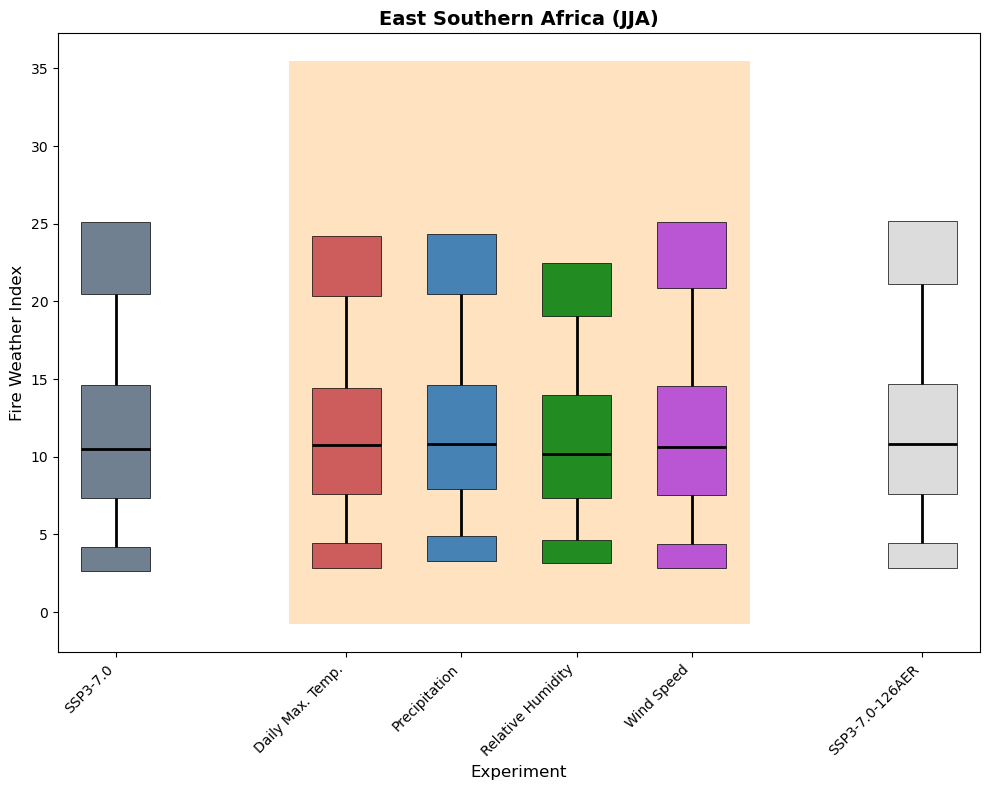

In [49]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_esaf_avg, global_tasmax_FWI_daily_seasonal_jja_esaf_avg, global_pr_FWI_daily_seasonal_jja_esaf_avg, global_hurs_FWI_daily_seasonal_jja_esaf_avg, global_sfcWind_FWI_daily_seasonal_jja_esaf_avg, global_FWI_daily_seasonal_jja_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (JJA)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

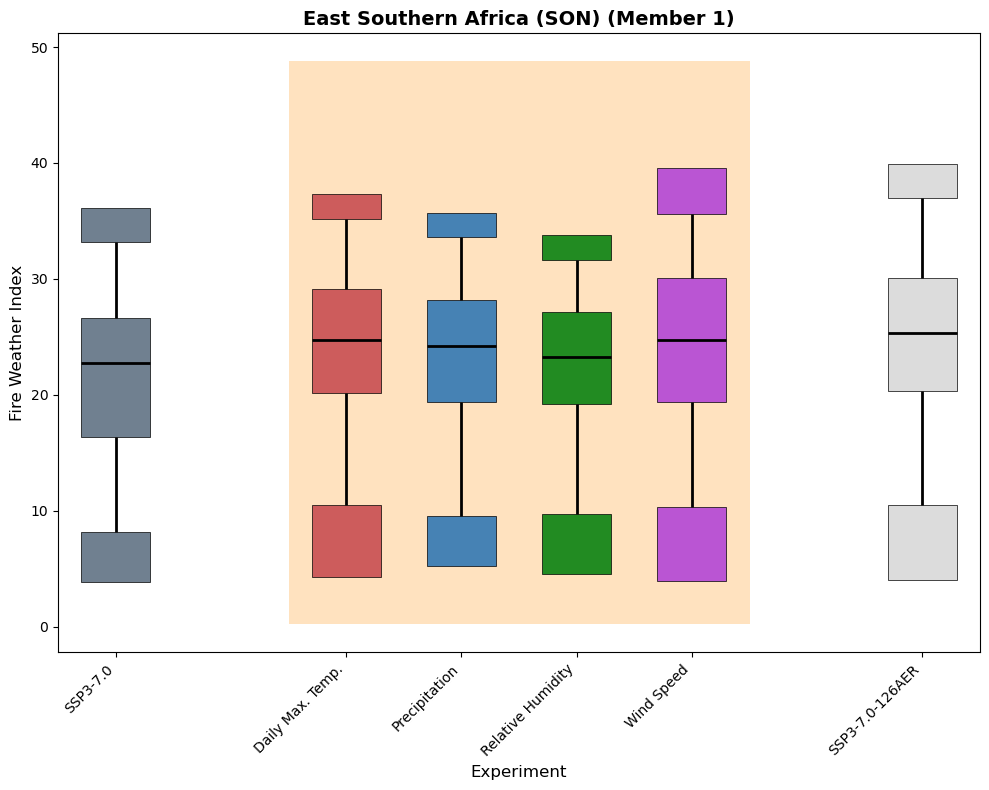

In [73]:
data_arrays = [ssp370_FWI_daily_seasonal_son_esaf_avg.isel(member=1), global_tasmax_FWI_daily_seasonal_son_esaf_avg.isel(member=1), global_pr_FWI_daily_seasonal_son_esaf_avg.isel(member=1), global_hurs_FWI_daily_seasonal_son_esaf_avg.isel(member=1), global_sfcWind_FWI_daily_seasonal_son_esaf_avg.isel(member=1), global_FWI_daily_seasonal_son_esaf_avg.isel(member=1)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (SON) (Member 1)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

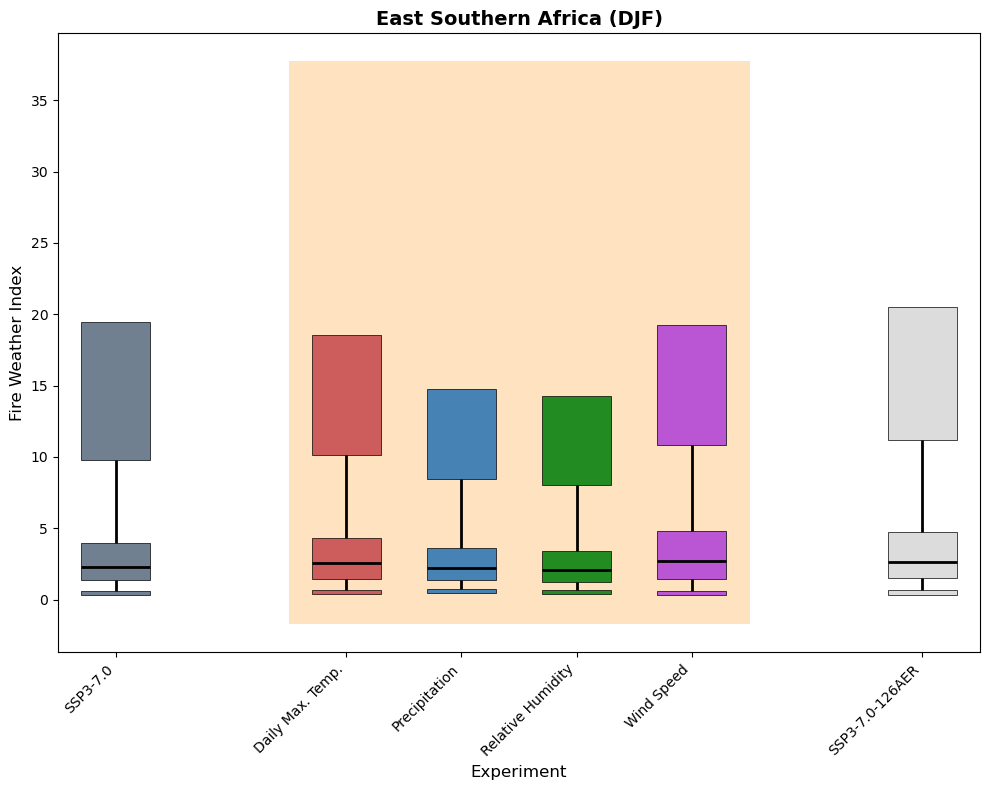

In [51]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_esaf_avg, global_tasmax_FWI_daily_seasonal_djf_esaf_avg, global_pr_FWI_daily_seasonal_djf_esaf_avg, global_hurs_FWI_daily_seasonal_djf_esaf_avg, global_sfcWind_FWI_daily_seasonal_djf_esaf_avg, global_FWI_daily_seasonal_djf_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (DJF)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

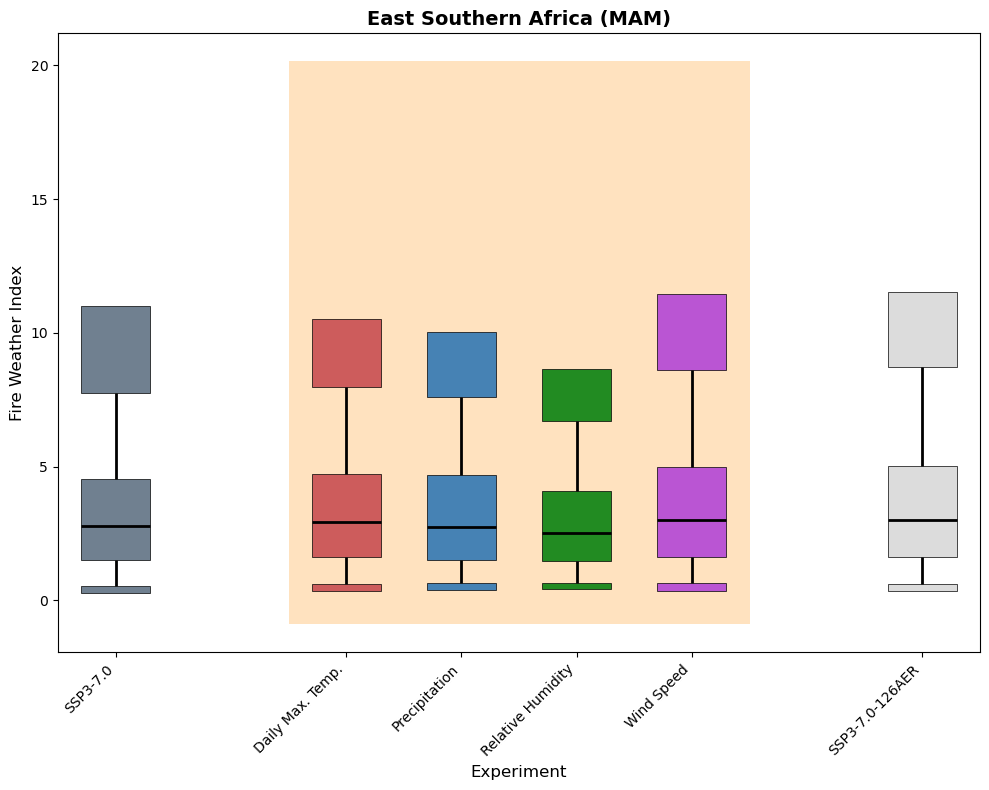

In [52]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_esaf_avg, global_tasmax_FWI_daily_seasonal_mam_esaf_avg, global_pr_FWI_daily_seasonal_mam_esaf_avg, global_hurs_FWI_daily_seasonal_mam_esaf_avg, global_sfcWind_FWI_daily_seasonal_mam_esaf_avg, global_FWI_daily_seasonal_mam_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (MAM)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

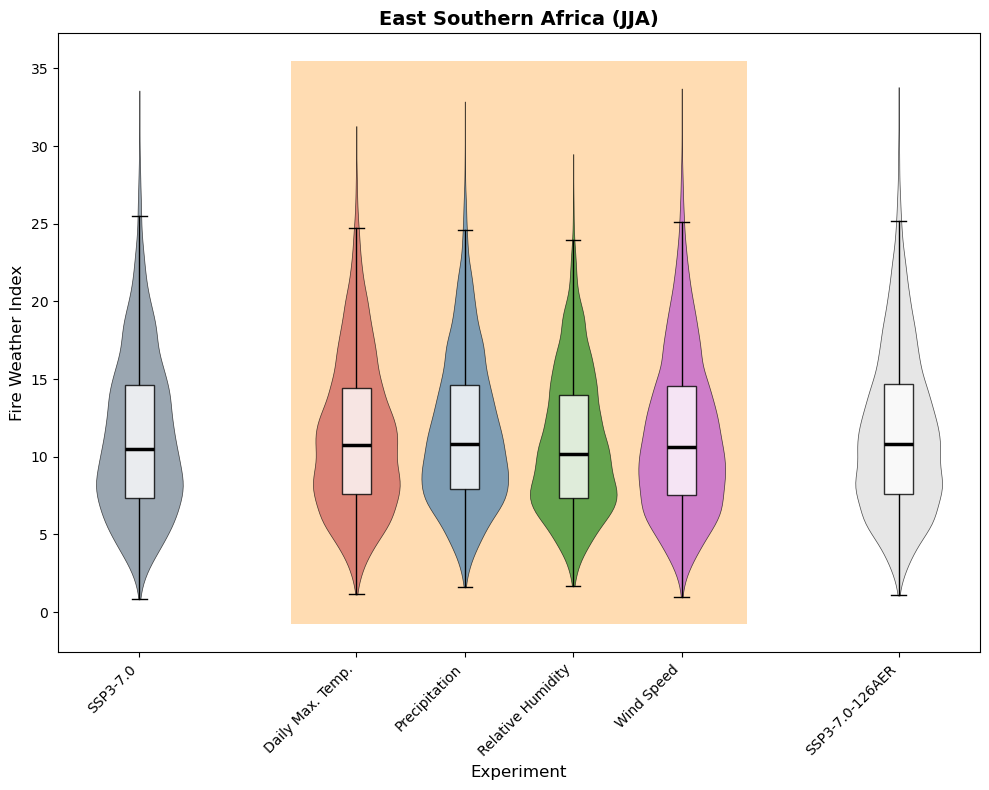

In [57]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_esaf_avg, global_tasmax_FWI_daily_seasonal_jja_esaf_avg, global_pr_FWI_daily_seasonal_jja_esaf_avg, global_hurs_FWI_daily_seasonal_jja_esaf_avg, global_sfcWind_FWI_daily_seasonal_jja_esaf_avg, global_FWI_daily_seasonal_jja_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (JJA)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

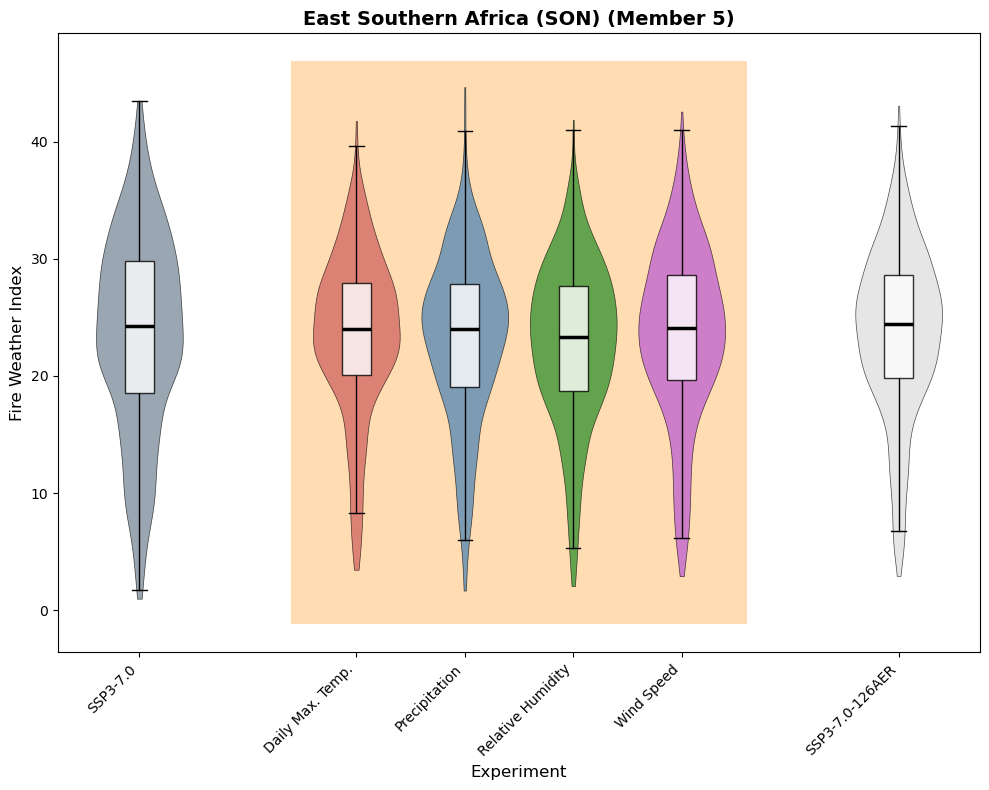

In [78]:
data_arrays = [ssp370_FWI_daily_seasonal_son_esaf_avg.isel(member=5), global_tasmax_FWI_daily_seasonal_son_esaf_avg.isel(member=5), global_pr_FWI_daily_seasonal_son_esaf_avg.isel(member=5), global_hurs_FWI_daily_seasonal_son_esaf_avg.isel(member=5), global_sfcWind_FWI_daily_seasonal_son_esaf_avg.isel(member=5), global_FWI_daily_seasonal_son_esaf_avg.isel(member=5)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (SON) (Member 5)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

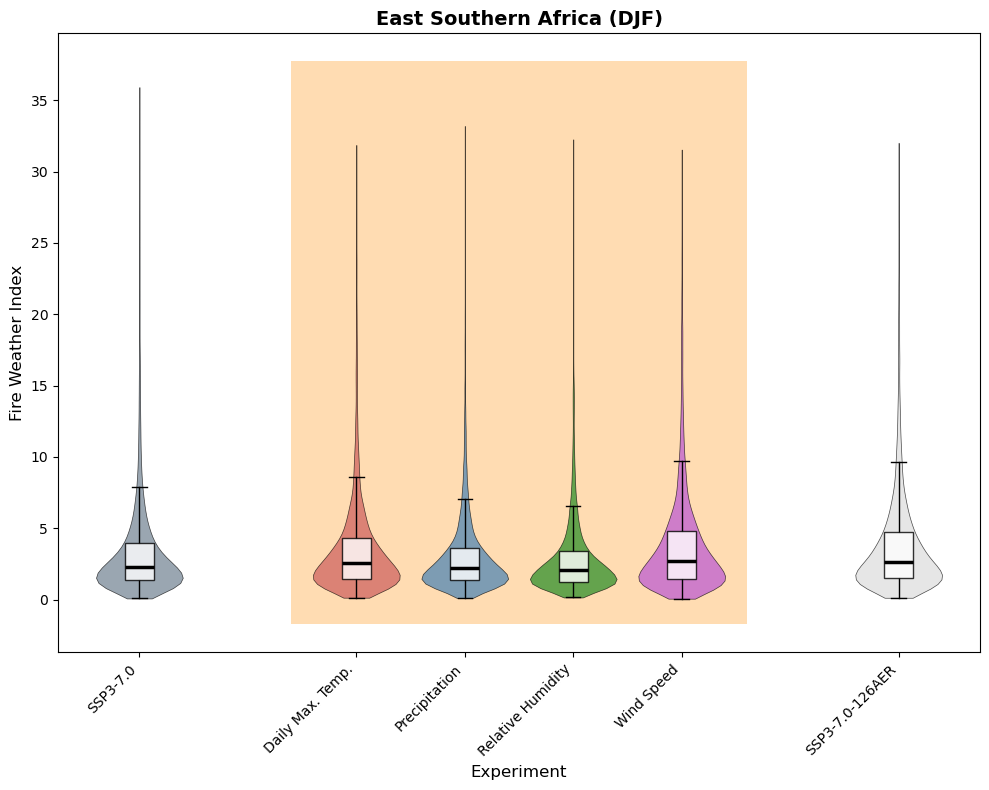

In [59]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_esaf_avg, global_tasmax_FWI_daily_seasonal_djf_esaf_avg, global_pr_FWI_daily_seasonal_djf_esaf_avg, global_hurs_FWI_daily_seasonal_djf_esaf_avg, global_sfcWind_FWI_daily_seasonal_djf_esaf_avg, global_FWI_daily_seasonal_djf_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (DJF)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

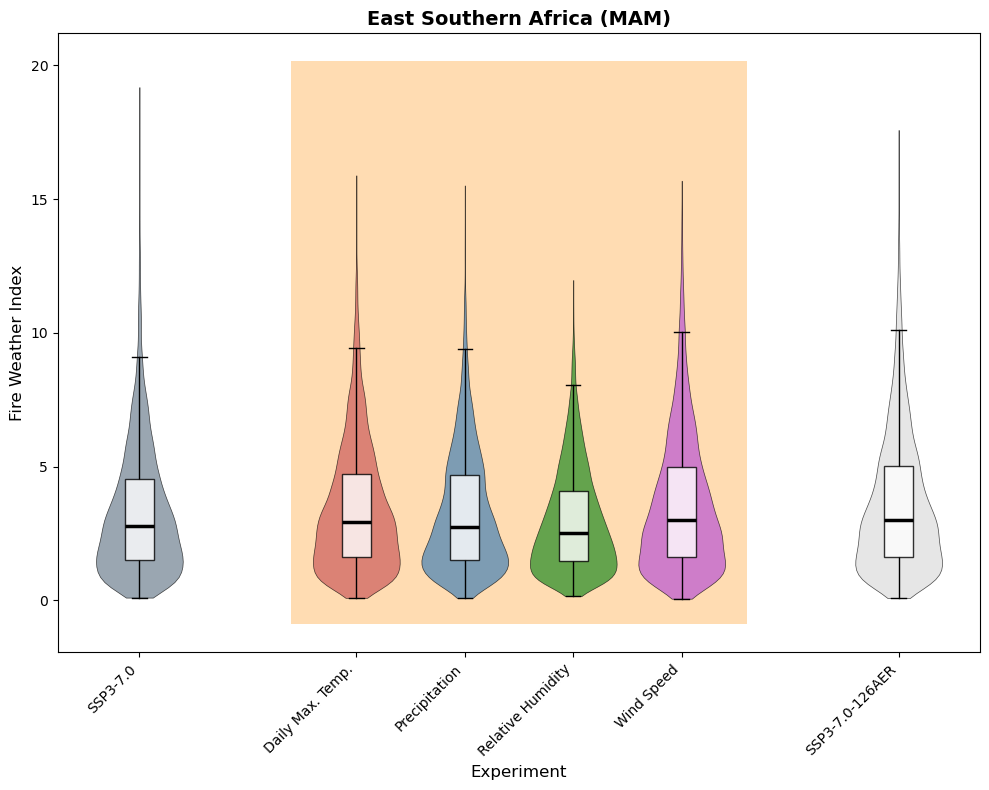

In [60]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_esaf_avg, global_tasmax_FWI_daily_seasonal_mam_esaf_avg, global_pr_FWI_daily_seasonal_mam_esaf_avg, global_hurs_FWI_daily_seasonal_mam_esaf_avg, global_sfcWind_FWI_daily_seasonal_mam_esaf_avg, global_FWI_daily_seasonal_mam_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (MAM)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

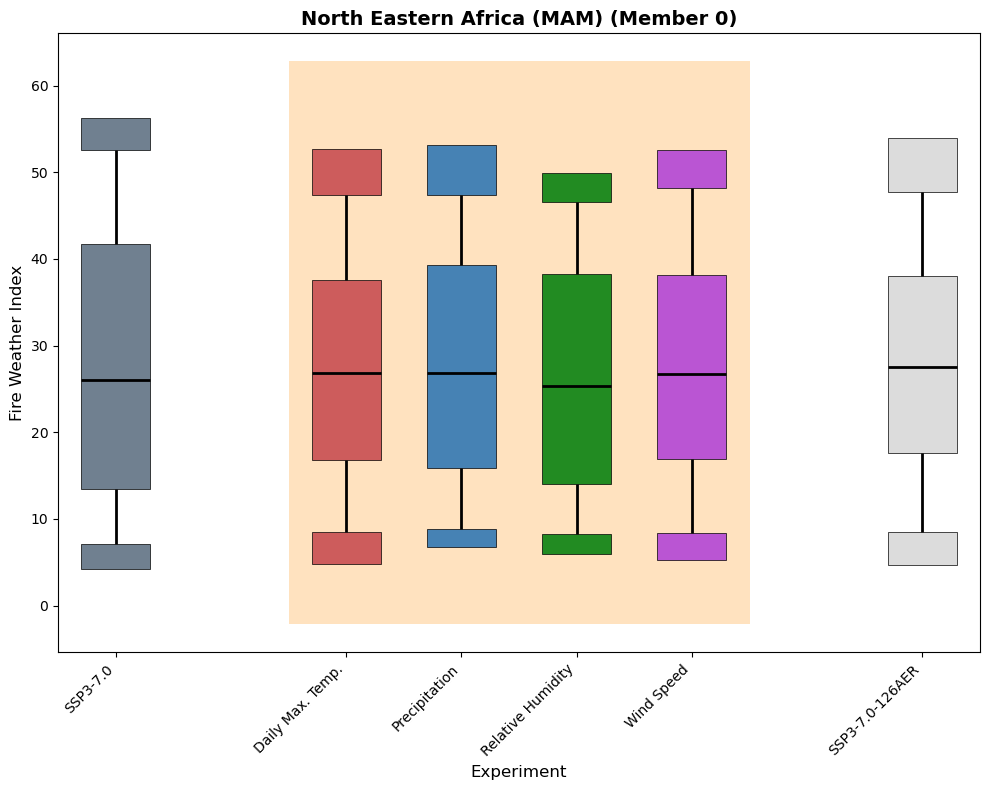

In [83]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_neaf_avg.isel(member=0), global_tasmax_FWI_daily_seasonal_mam_neaf_avg.isel(member=0), global_pr_FWI_daily_seasonal_mam_neaf_avg.isel(member=0), global_hurs_FWI_daily_seasonal_mam_neaf_avg.isel(member=0), global_sfcWind_FWI_daily_seasonal_mam_neaf_avg.isel(member=0), global_FWI_daily_seasonal_mam_neaf_avg.isel(member=0)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (MAM) (Member 0)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

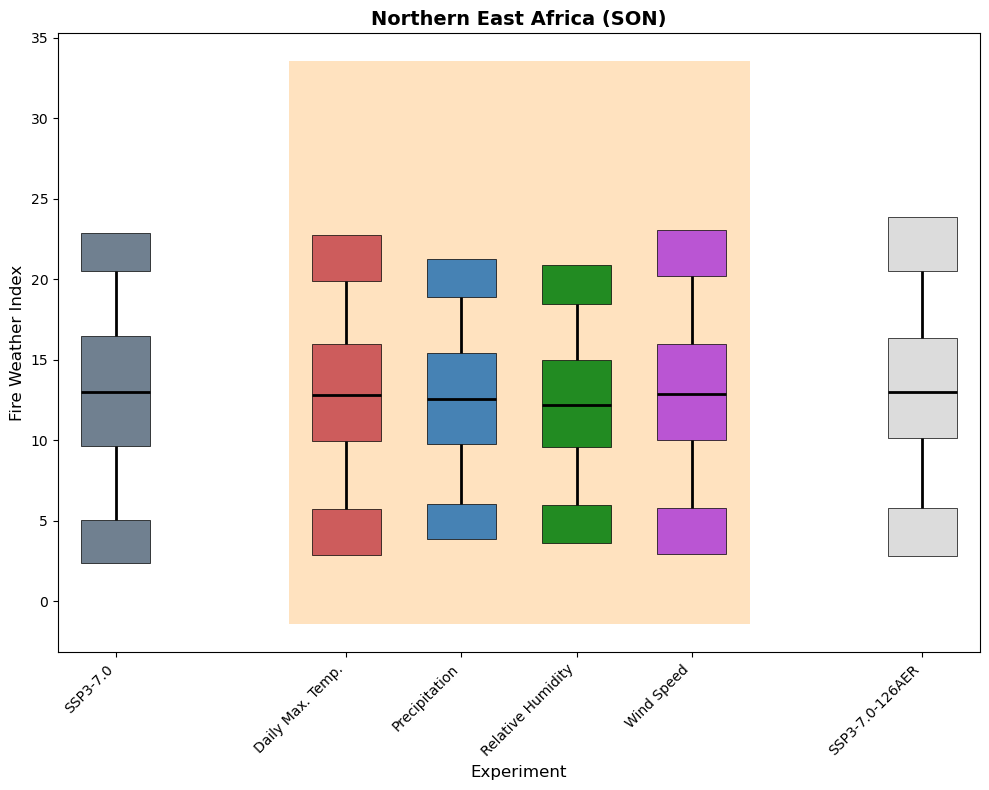

In [62]:
data_arrays = [ssp370_FWI_daily_seasonal_son_neaf_avg, global_tasmax_FWI_daily_seasonal_son_neaf_avg, global_pr_FWI_daily_seasonal_son_neaf_avg, global_hurs_FWI_daily_seasonal_son_neaf_avg, global_sfcWind_FWI_daily_seasonal_son_neaf_avg, global_FWI_daily_seasonal_son_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern East Africa (SON)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

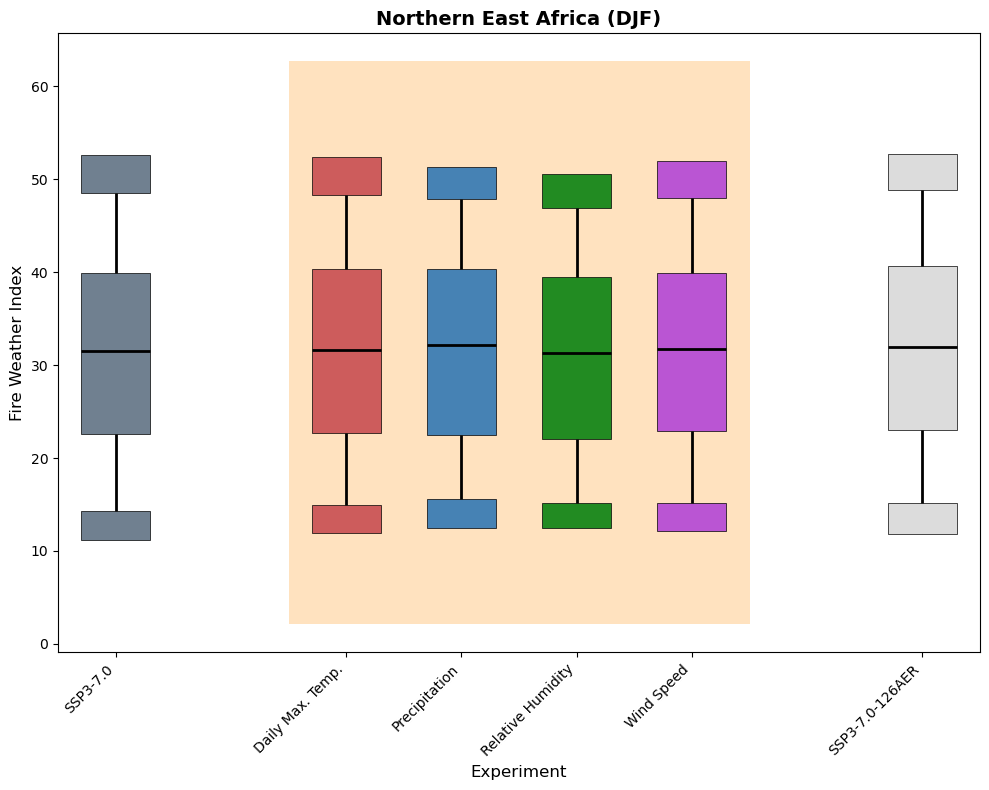

In [63]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_neaf_avg, global_tasmax_FWI_daily_seasonal_djf_neaf_avg, global_pr_FWI_daily_seasonal_djf_neaf_avg, global_hurs_FWI_daily_seasonal_djf_neaf_avg, global_sfcWind_FWI_daily_seasonal_djf_neaf_avg, global_FWI_daily_seasonal_djf_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern East Africa (DJF)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

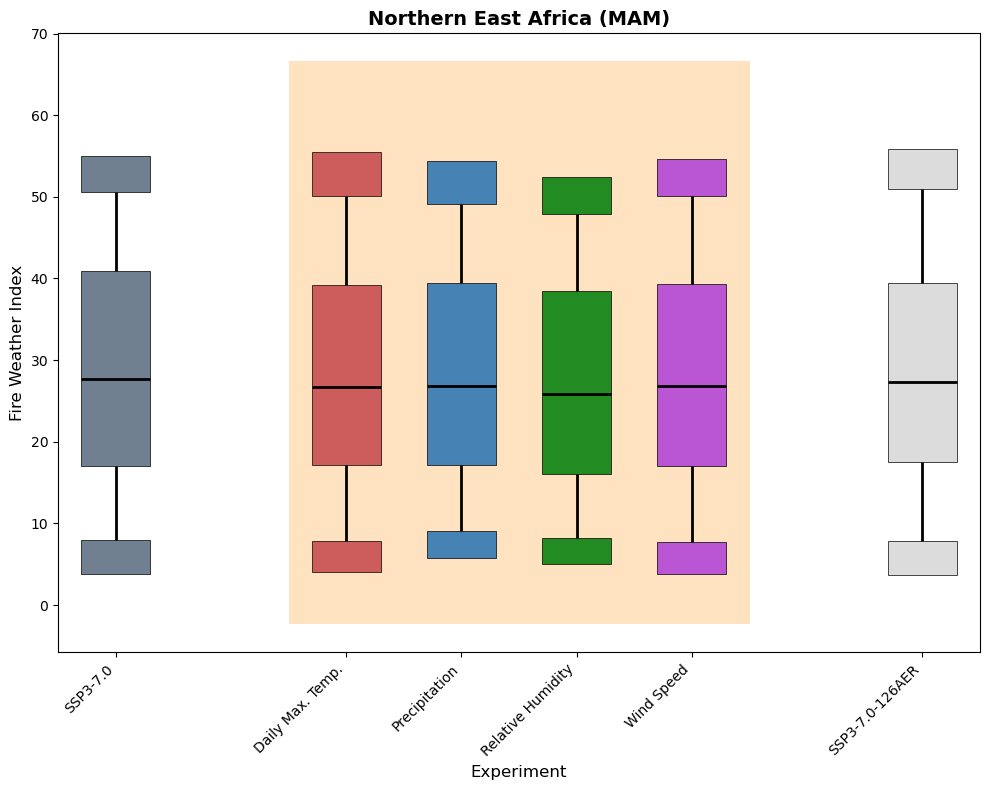

In [64]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_neaf_avg, global_tasmax_FWI_daily_seasonal_mam_neaf_avg, global_pr_FWI_daily_seasonal_mam_neaf_avg, global_hurs_FWI_daily_seasonal_mam_neaf_avg, global_sfcWind_FWI_daily_seasonal_mam_neaf_avg, global_FWI_daily_seasonal_mam_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern East Africa (MAM)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

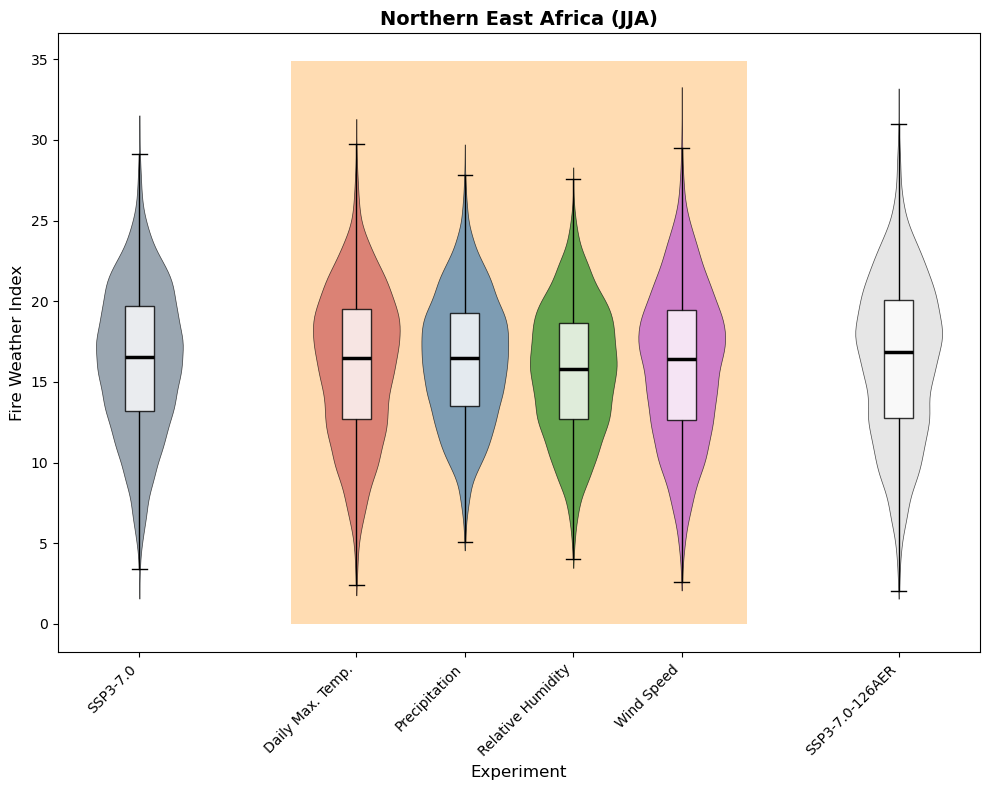

In [67]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_neaf_avg, global_tasmax_FWI_daily_seasonal_jja_neaf_avg, global_pr_FWI_daily_seasonal_jja_neaf_avg, global_hurs_FWI_daily_seasonal_jja_neaf_avg, global_sfcWind_FWI_daily_seasonal_jja_neaf_avg, global_FWI_daily_seasonal_jja_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern East Africa (JJA)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

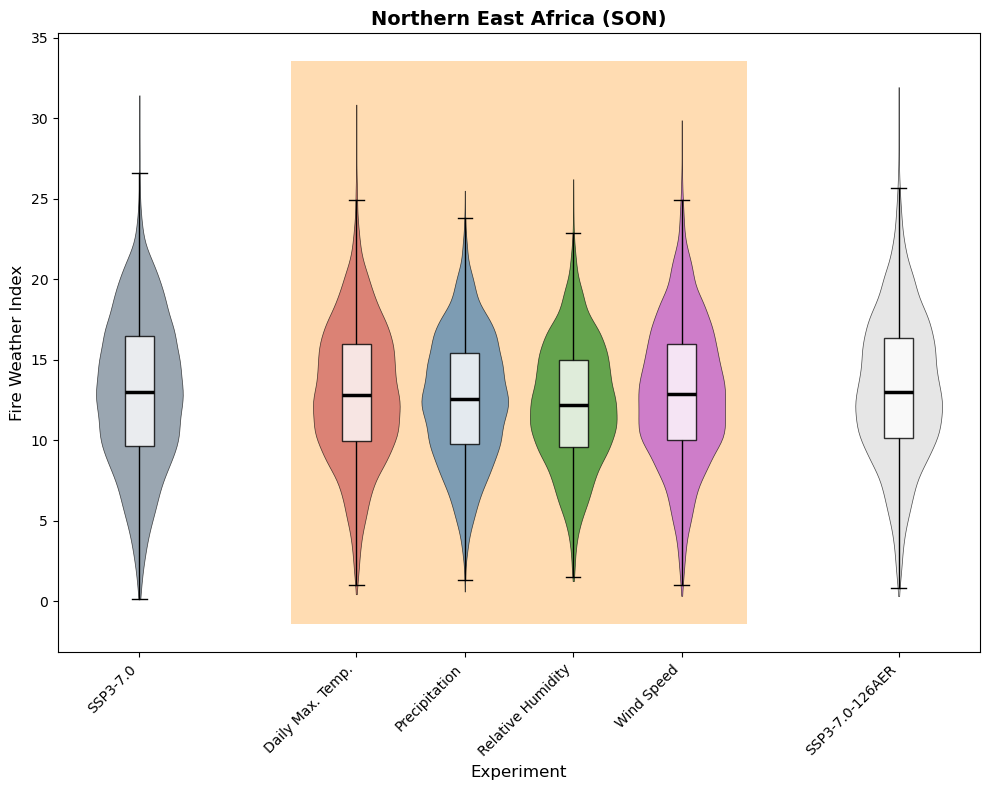

In [68]:
data_arrays = [ssp370_FWI_daily_seasonal_son_neaf_avg, global_tasmax_FWI_daily_seasonal_son_neaf_avg, global_pr_FWI_daily_seasonal_son_neaf_avg, global_hurs_FWI_daily_seasonal_son_neaf_avg, global_sfcWind_FWI_daily_seasonal_son_neaf_avg, global_FWI_daily_seasonal_son_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern East Africa (SON)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

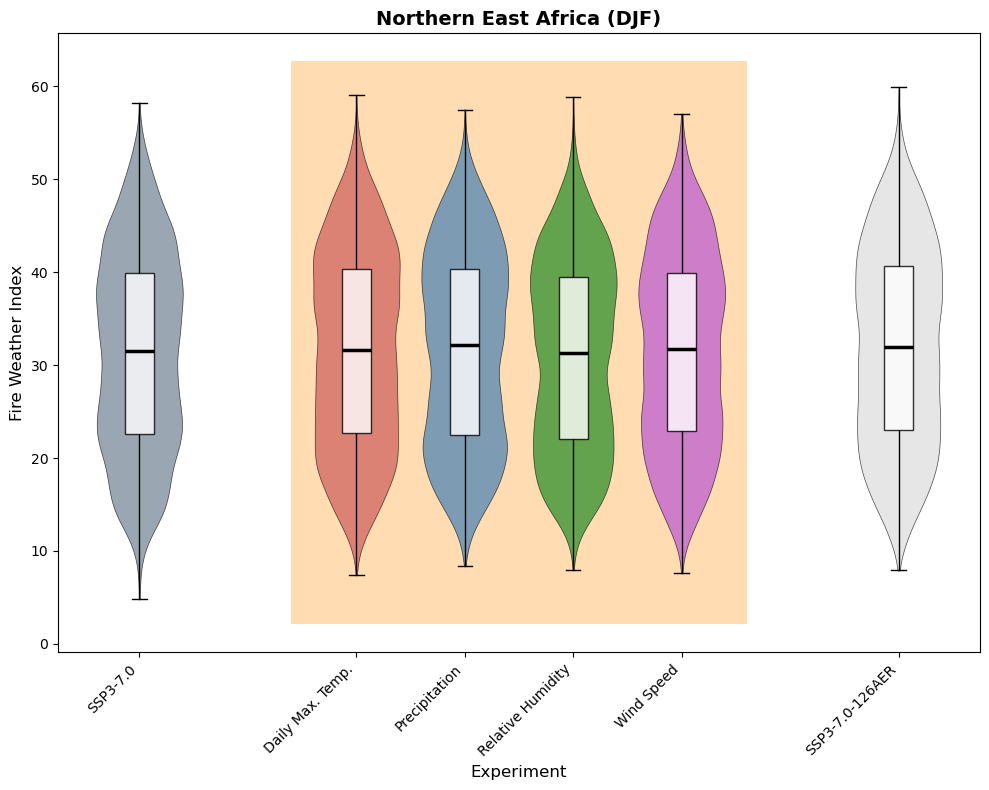

In [69]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_neaf_avg, global_tasmax_FWI_daily_seasonal_djf_neaf_avg, global_pr_FWI_daily_seasonal_djf_neaf_avg, global_hurs_FWI_daily_seasonal_djf_neaf_avg, global_sfcWind_FWI_daily_seasonal_djf_neaf_avg, global_FWI_daily_seasonal_djf_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="Northern East Africa (DJF)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

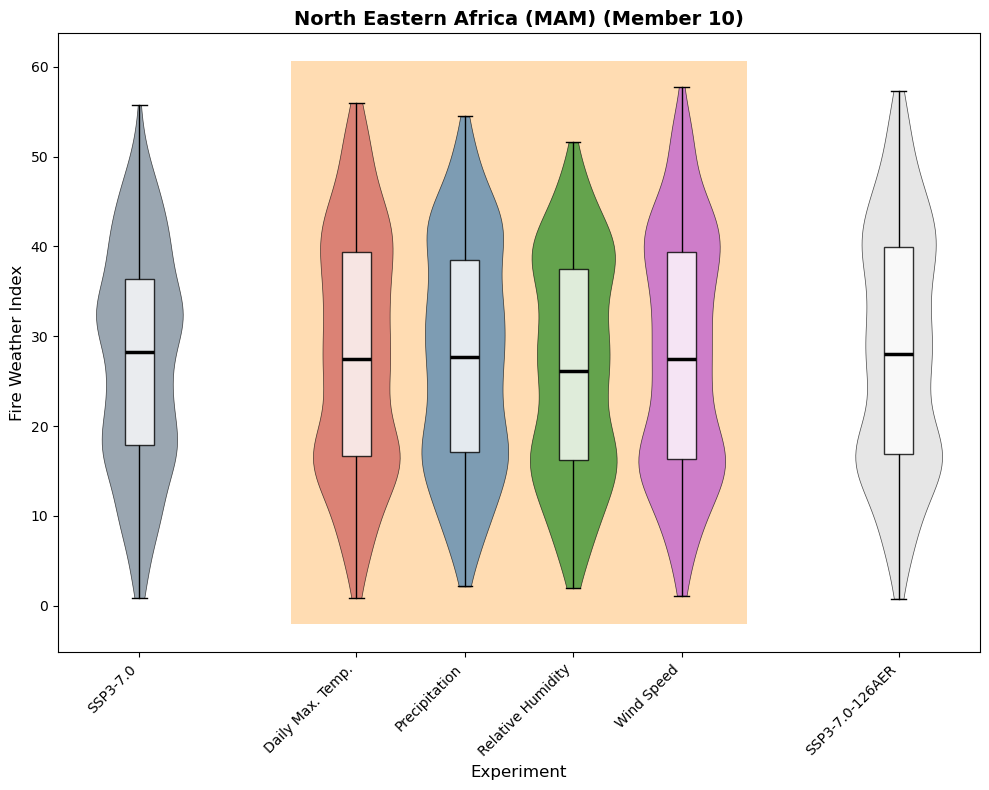

In [94]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_neaf_avg.isel(member=1), global_tasmax_FWI_daily_seasonal_mam_neaf_avg.isel(member=1), global_pr_FWI_daily_seasonal_mam_neaf_avg.isel(member=1), global_hurs_FWI_daily_seasonal_mam_neaf_avg.isel(member=1), global_sfcWind_FWI_daily_seasonal_mam_neaf_avg.isel(member=1), global_FWI_daily_seasonal_mam_neaf_avg.isel(member=1)]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (MAM) (Member 10)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

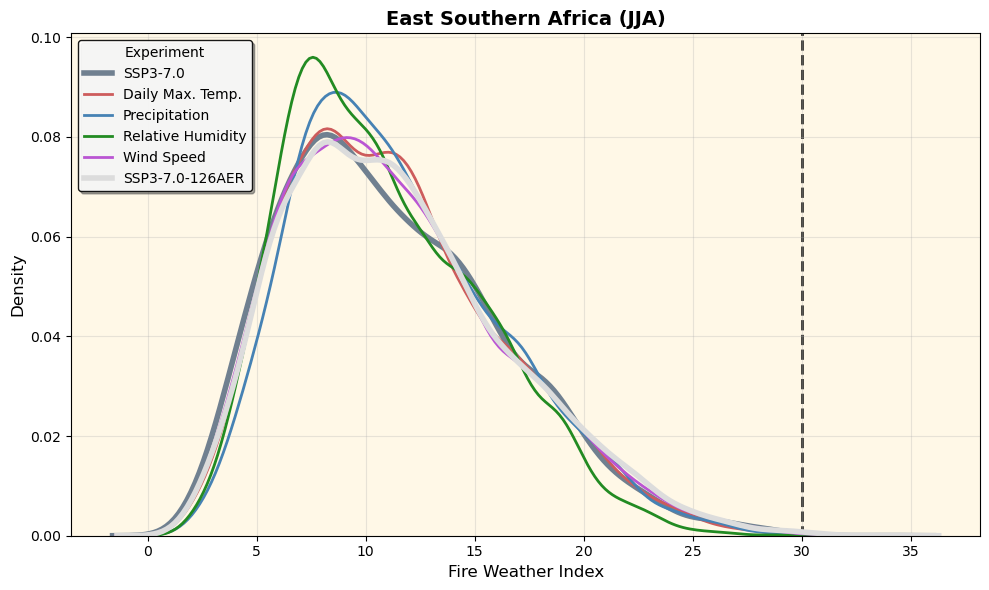

In [152]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_esaf_avg, global_tasmax_FWI_daily_seasonal_jja_esaf_avg, global_pr_FWI_daily_seasonal_jja_esaf_avg, global_hurs_FWI_daily_seasonal_jja_esaf_avg, global_sfcWind_FWI_daily_seasonal_jja_esaf_avg, global_FWI_daily_seasonal_jja_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (JJA)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          figsize=(10, 6), alpha=1)

plt.show()

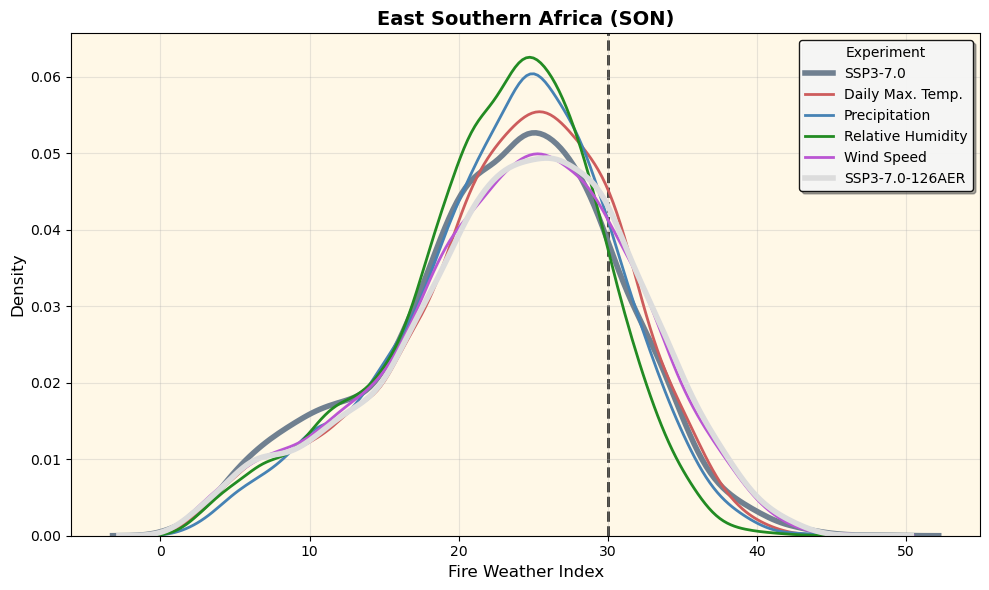

In [154]:
data_arrays = [ssp370_FWI_daily_seasonal_son_esaf_avg, global_tasmax_FWI_daily_seasonal_son_esaf_avg, global_pr_FWI_daily_seasonal_son_esaf_avg, global_hurs_FWI_daily_seasonal_son_esaf_avg, global_sfcWind_FWI_daily_seasonal_son_esaf_avg, global_FWI_daily_seasonal_son_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (SON)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          figsize=(10, 6), alpha=1)

plt.show()

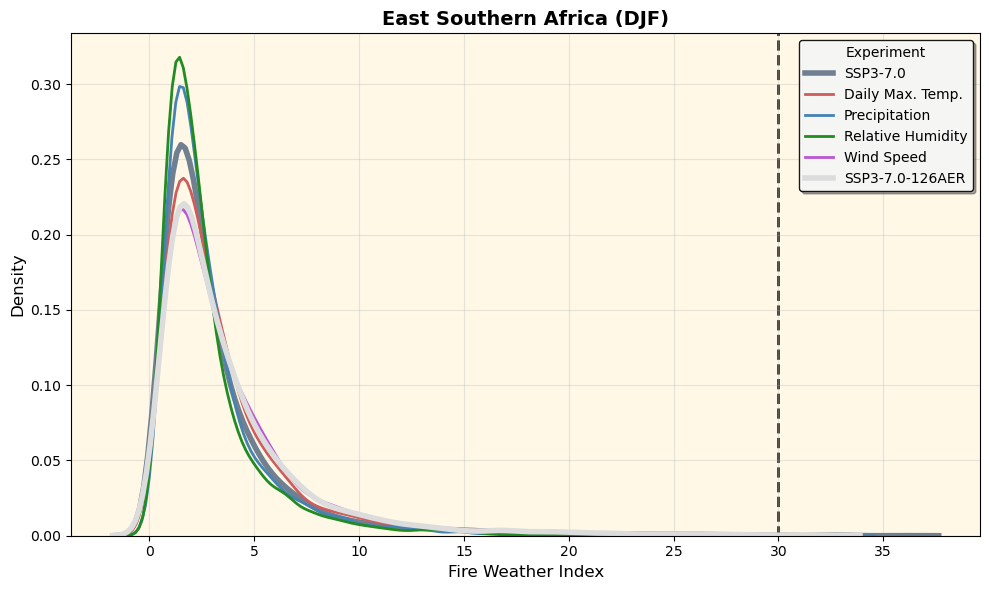

In [155]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_esaf_avg, global_tasmax_FWI_daily_seasonal_djf_esaf_avg, global_pr_FWI_daily_seasonal_djf_esaf_avg, global_hurs_FWI_daily_seasonal_djf_esaf_avg, global_sfcWind_FWI_daily_seasonal_djf_esaf_avg, global_FWI_daily_seasonal_djf_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (DJF)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          figsize=(10, 6), alpha=1)

plt.show()

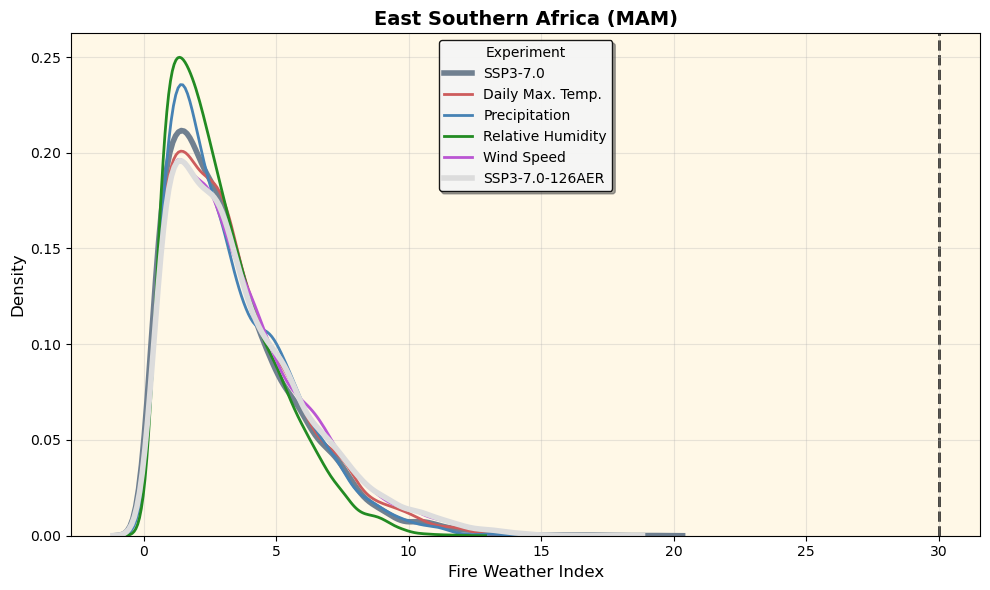

In [156]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_esaf_avg, global_tasmax_FWI_daily_seasonal_mam_esaf_avg, global_pr_FWI_daily_seasonal_mam_esaf_avg, global_hurs_FWI_daily_seasonal_mam_esaf_avg, global_sfcWind_FWI_daily_seasonal_mam_esaf_avg, global_FWI_daily_seasonal_mam_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (MAM)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          figsize=(10, 6), alpha=1)

plt.show()

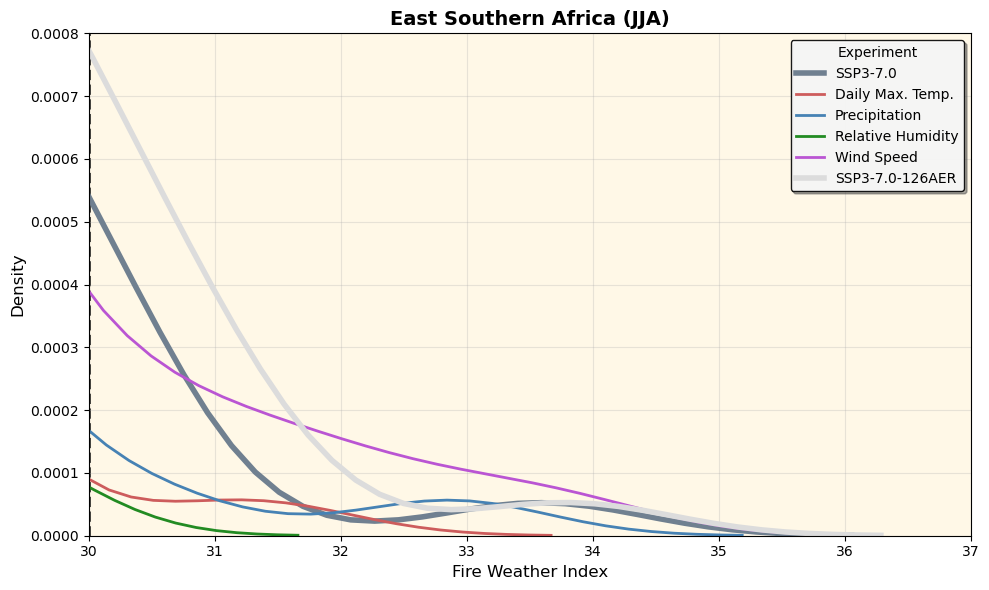

In [158]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_esaf_avg, global_tasmax_FWI_daily_seasonal_jja_esaf_avg, global_pr_FWI_daily_seasonal_jja_esaf_avg, global_hurs_FWI_daily_seasonal_jja_esaf_avg, global_sfcWind_FWI_daily_seasonal_jja_esaf_avg, global_FWI_daily_seasonal_jja_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (JJA)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          xlim=(30, 37), ylim=(0, 0.0008),
                          figsize=(10, 6), alpha=1)

plt.show()

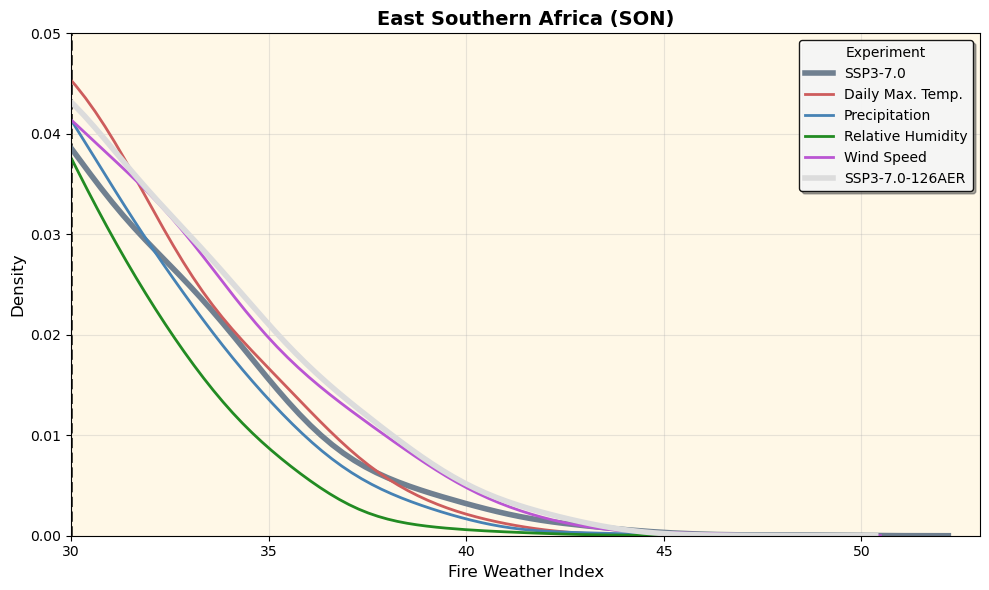

In [164]:
data_arrays = [ssp370_FWI_daily_seasonal_son_esaf_avg, global_tasmax_FWI_daily_seasonal_son_esaf_avg, global_pr_FWI_daily_seasonal_son_esaf_avg, global_hurs_FWI_daily_seasonal_son_esaf_avg, global_sfcWind_FWI_daily_seasonal_son_esaf_avg, global_FWI_daily_seasonal_son_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (SON)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          xlim=(30, 53), ylim=(0, 0.05),
                          figsize=(10, 6), alpha=1)

plt.show()

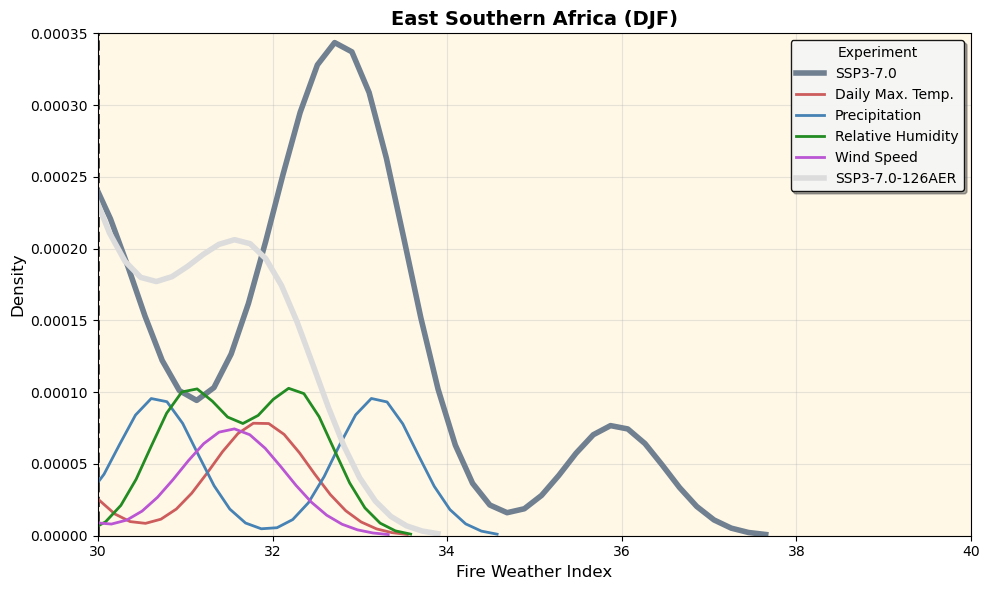

In [169]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_esaf_avg, global_tasmax_FWI_daily_seasonal_djf_esaf_avg, global_pr_FWI_daily_seasonal_djf_esaf_avg, global_hurs_FWI_daily_seasonal_djf_esaf_avg, global_sfcWind_FWI_daily_seasonal_djf_esaf_avg, global_FWI_daily_seasonal_djf_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (DJF)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          xlim=(30, 40), ylim=(0, 0.00035),
                          figsize=(10, 6), alpha=1)

plt.show()

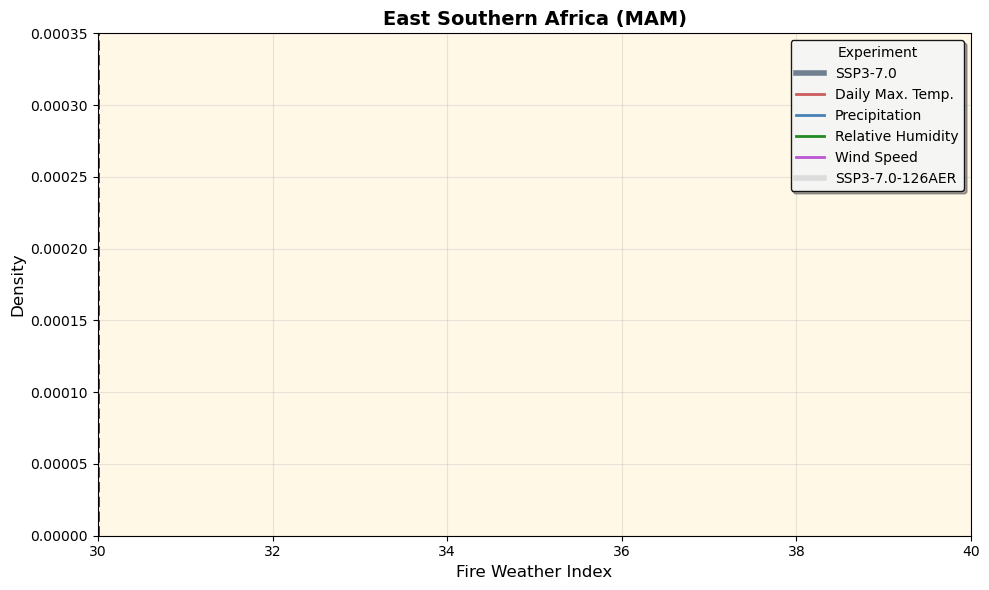

In [172]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_esaf_avg, global_tasmax_FWI_daily_seasonal_mam_esaf_avg, global_pr_FWI_daily_seasonal_mam_esaf_avg, global_hurs_FWI_daily_seasonal_mam_esaf_avg, global_sfcWind_FWI_daily_seasonal_mam_esaf_avg, global_FWI_daily_seasonal_mam_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                          show_hist=False, show_kde=True,
                          xlabel='Fire Weather Index', ylabel='Density',
                          plot_title='East Southern Africa (MAM)',
                          legend_title='Experiment',
                          show_grid=True,
                          legend_inside=True,
                          legend_facecolor='white',
                          legend_edgecolor='black',
                          legend_shadow=True,
                          plot_facecolor='#fff8e7',
                          xlim=(30, 40), ylim=(0, 0.00035),
                          figsize=(10, 6), alpha=1)

plt.show()

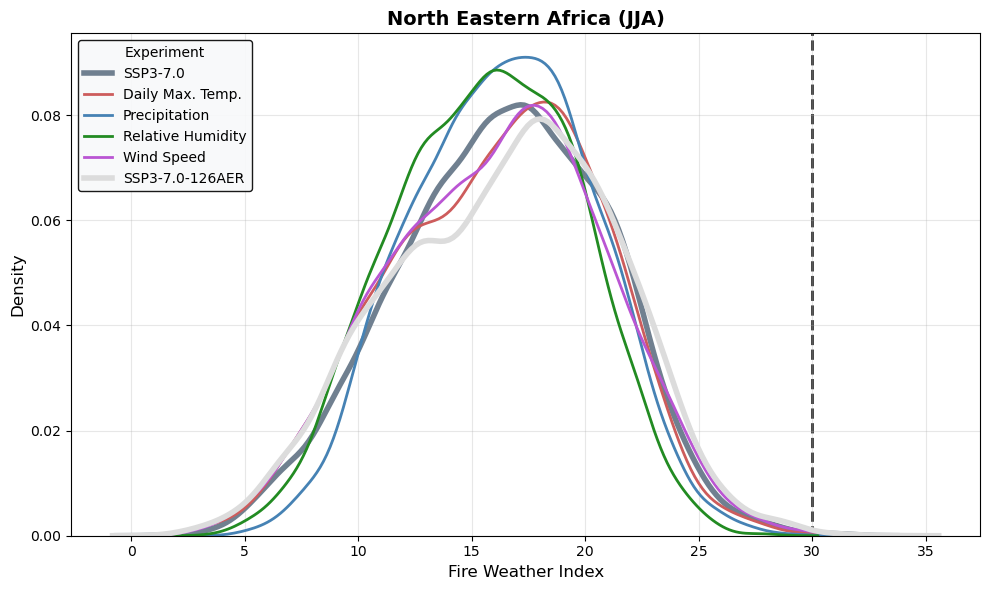

In [174]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_neaf_avg, global_tasmax_FWI_daily_seasonal_jja_neaf_avg, global_pr_FWI_daily_seasonal_jja_neaf_avg, global_hurs_FWI_daily_seasonal_jja_neaf_avg, global_sfcWind_FWI_daily_seasonal_jja_neaf_avg, global_FWI_daily_seasonal_jja_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (JJA)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                figsize=(10, 6), alpha=1)

plt.show()

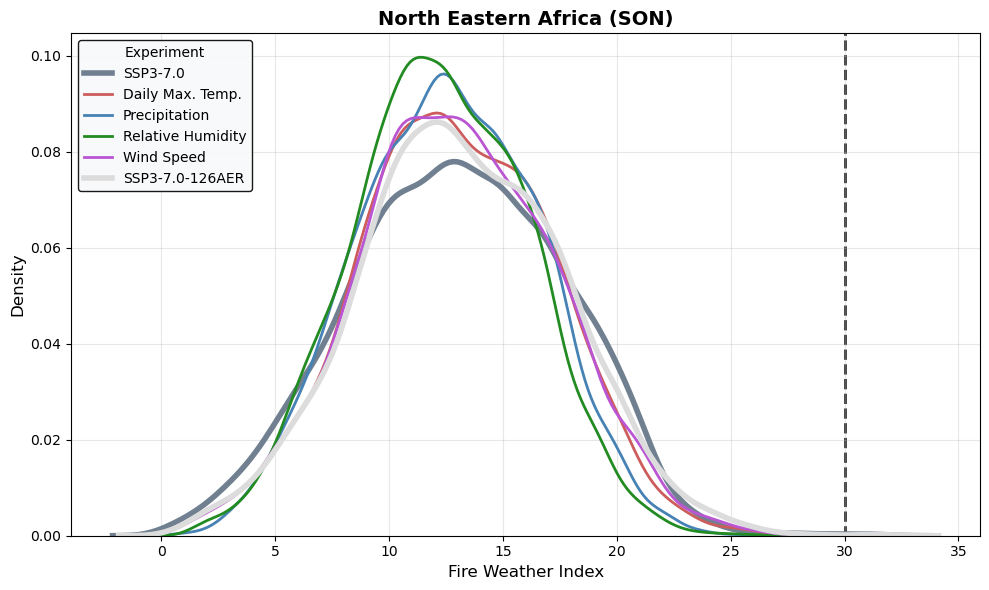

In [175]:
data_arrays = [ssp370_FWI_daily_seasonal_son_neaf_avg, global_tasmax_FWI_daily_seasonal_son_neaf_avg, global_pr_FWI_daily_seasonal_son_neaf_avg, global_hurs_FWI_daily_seasonal_son_neaf_avg, global_sfcWind_FWI_daily_seasonal_son_neaf_avg, global_FWI_daily_seasonal_son_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (SON)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                figsize=(10, 6), alpha=1)

plt.show()

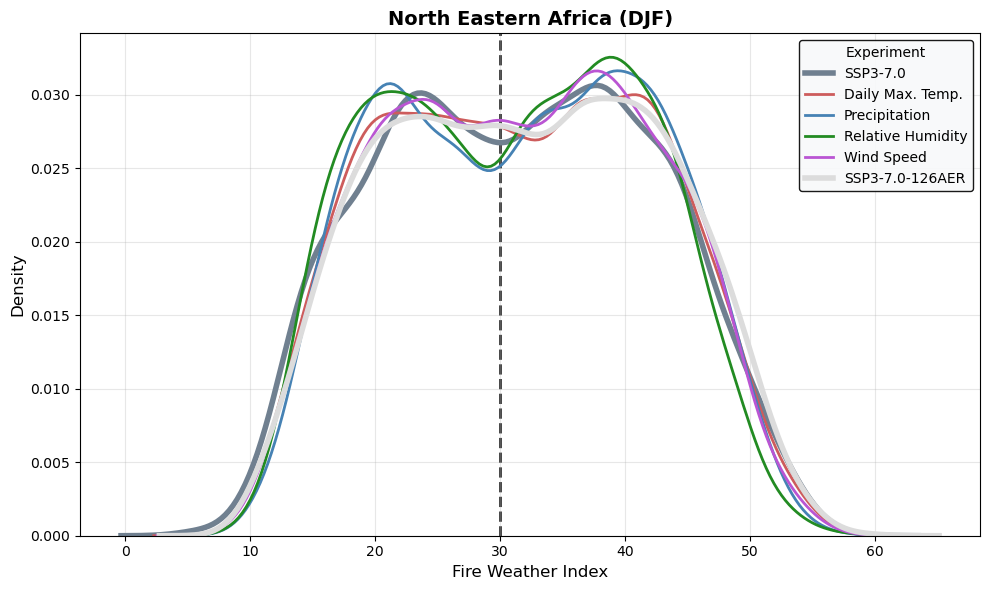

In [176]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_neaf_avg, global_tasmax_FWI_daily_seasonal_djf_neaf_avg, global_pr_FWI_daily_seasonal_djf_neaf_avg, global_hurs_FWI_daily_seasonal_djf_neaf_avg, global_sfcWind_FWI_daily_seasonal_djf_neaf_avg, global_FWI_daily_seasonal_djf_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (DJF)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                figsize=(10, 6), alpha=1)

plt.show()

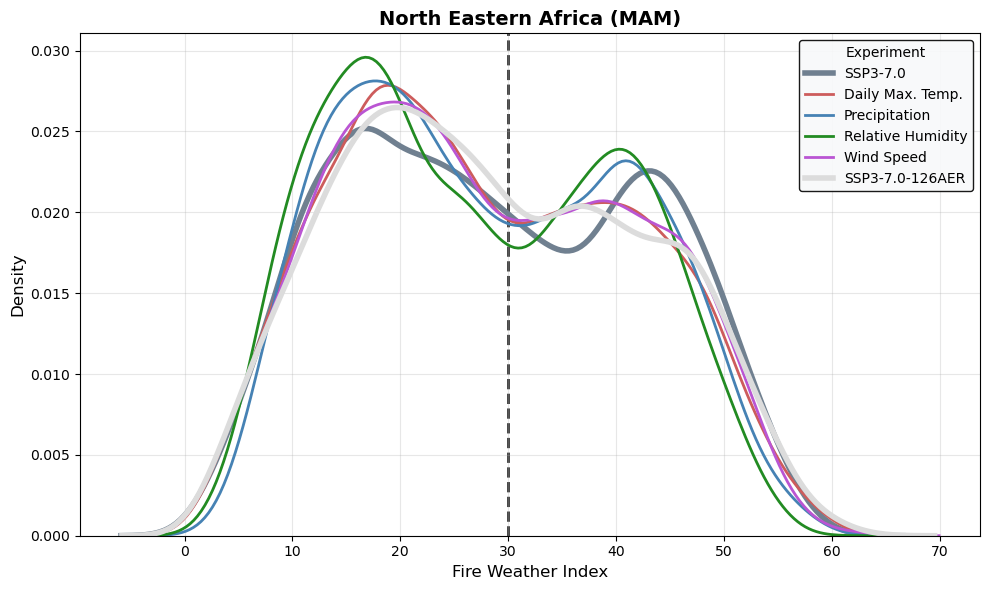

In [177]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_neaf_avg, global_tasmax_FWI_daily_seasonal_mam_neaf_avg, global_pr_FWI_daily_seasonal_mam_neaf_avg, global_hurs_FWI_daily_seasonal_mam_neaf_avg, global_sfcWind_FWI_daily_seasonal_mam_neaf_avg, global_FWI_daily_seasonal_mam_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (MAM)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                figsize=(10, 6), alpha=1)

plt.show()

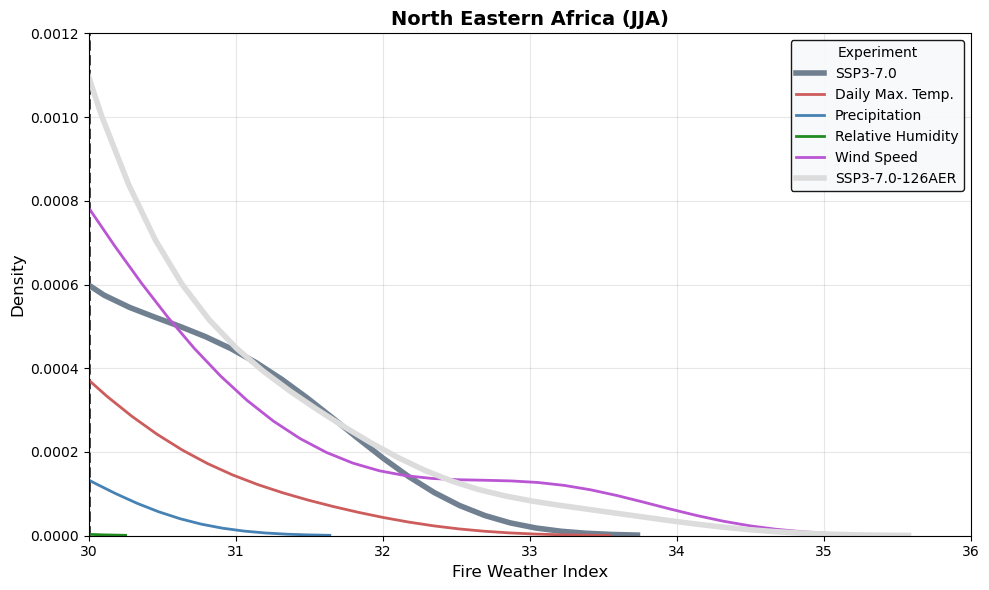

In [182]:
data_arrays = [ssp370_FWI_daily_seasonal_jja_neaf_avg, global_tasmax_FWI_daily_seasonal_jja_neaf_avg, global_pr_FWI_daily_seasonal_jja_neaf_avg, global_hurs_FWI_daily_seasonal_jja_neaf_avg, global_sfcWind_FWI_daily_seasonal_jja_neaf_avg, global_FWI_daily_seasonal_jja_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (JJA)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                xlim=(30, 36), ylim=(0, 0.0012),
                                figsize=(10, 6), alpha=1)

plt.show()

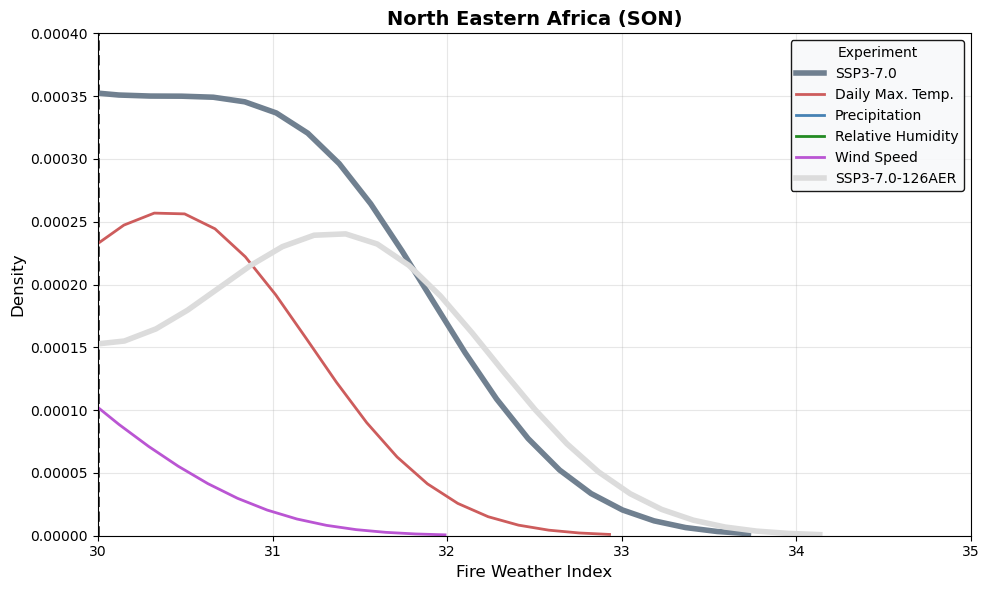

In [186]:
data_arrays = [ssp370_FWI_daily_seasonal_son_neaf_avg, global_tasmax_FWI_daily_seasonal_son_neaf_avg, global_pr_FWI_daily_seasonal_son_neaf_avg, global_hurs_FWI_daily_seasonal_son_neaf_avg, global_sfcWind_FWI_daily_seasonal_son_neaf_avg, global_FWI_daily_seasonal_son_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (SON)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                xlim=(30, 35), ylim=(0, 0.0004),
                                figsize=(10, 6), alpha=1)

plt.show()

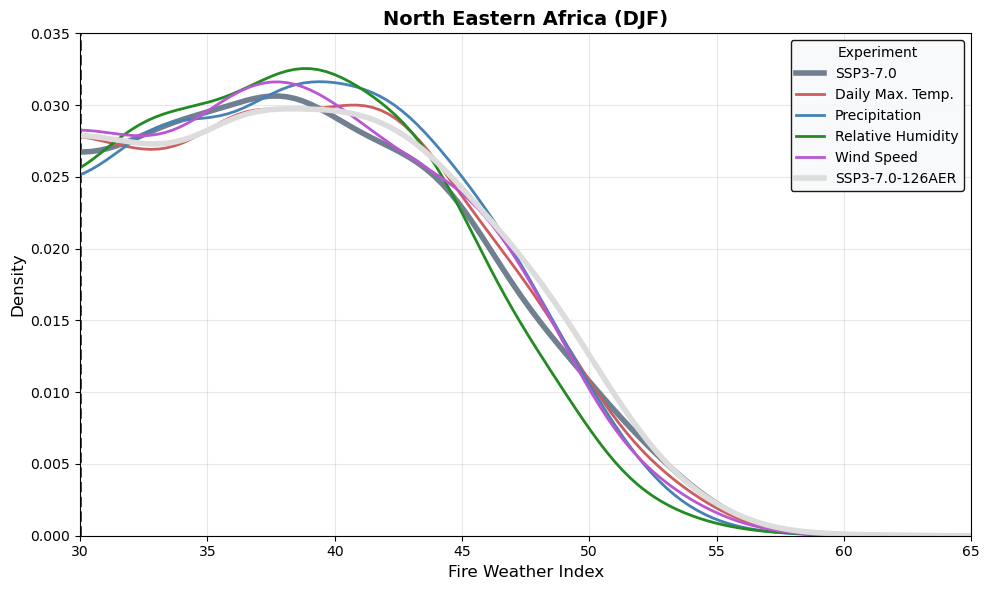

In [189]:
data_arrays = [ssp370_FWI_daily_seasonal_djf_neaf_avg, global_tasmax_FWI_daily_seasonal_djf_neaf_avg, global_pr_FWI_daily_seasonal_djf_neaf_avg, global_hurs_FWI_daily_seasonal_djf_neaf_avg, global_sfcWind_FWI_daily_seasonal_djf_neaf_avg, global_FWI_daily_seasonal_djf_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (DJF)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                xlim=(30, 65), ylim=(0, 0.035),
                                figsize=(10, 6), alpha=1)

plt.show()

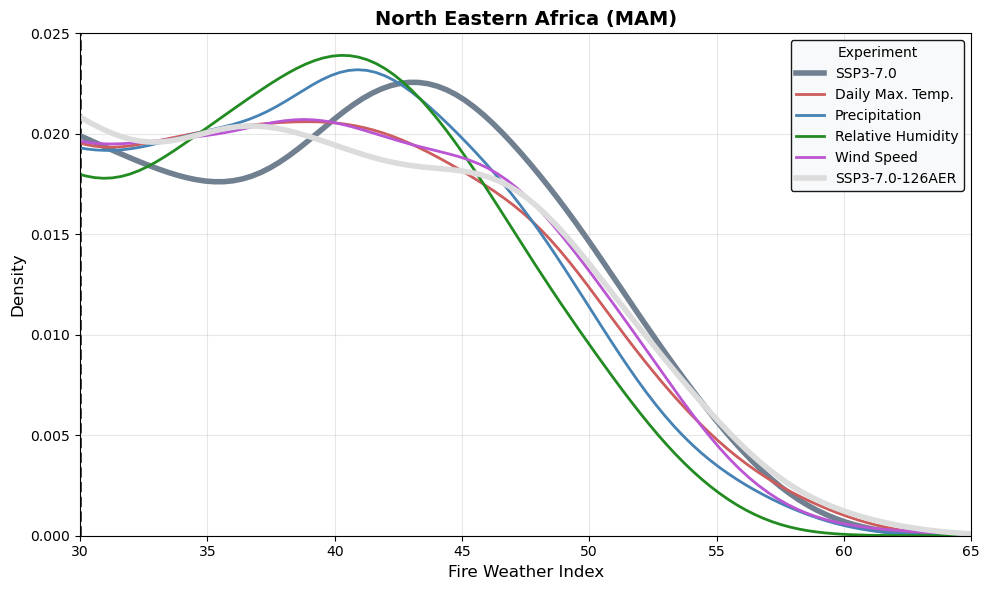

In [191]:
data_arrays = [ssp370_FWI_daily_seasonal_mam_neaf_avg, global_tasmax_FWI_daily_seasonal_mam_neaf_avg, global_pr_FWI_daily_seasonal_mam_neaf_avg, global_hurs_FWI_daily_seasonal_mam_neaf_avg, global_sfcWind_FWI_daily_seasonal_mam_neaf_avg, global_FWI_daily_seasonal_mam_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

plot_xarray_distributions(data_arrays, labels=labels, overlay=True,
                                show_hist=False, show_kde=True,
                                xlabel='Fire Weather Index', ylabel='Density',
                                plot_title='North Eastern Africa (MAM)',
                                legend_title='Experiment',
                                show_grid=True,
                                legend_inside=True,
                                legend_facecolor='#f8f9fa',
                                legend_edgecolor='black',
                                legend_shadow=False,
                                xlim=(30, 65), ylim=(0, 0.025),
                                figsize=(10, 6), alpha=1)

plt.show()

# Regional Seasonal Mean Analysis

In [101]:
# Take seasonal mean

ssp370_FWI_seasonal = season_mean(ssp370_FWI).compute()
print(f"ssp370_FWI_seasonal is ready")
global_FWI_seasonal = season_mean(global_FWI).compute()
print(f"global_FWI_seasonal is ready")
global_hurs_FWI_seasonal = season_mean(global_hurs_FWI).compute()
print(f"global_hurs_FWI_seasonal is ready")
global_pr_FWI_seasonal = season_mean(global_pr_FWI).compute()
print(f"global_pr_FWI_seasonal is ready")
global_sfcWind_FWI_seasonal = season_mean(global_sfcWind_FWI).compute()
print(f"global_sfcWind_FWI_seasonal is ready")
global_tasmax_FWI_seasonal = season_mean(global_tasmax_FWI).compute()
print(f"global_tasmax_FWI_seasonal is ready")

ssp370_FWI_seasonal is ready
global_FWI_seasonal is ready
global_hurs_FWI_seasonal is ready
global_pr_FWI_seasonal is ready
global_sfcWind_FWI_seasonal is ready
global_tasmax_FWI_seasonal is ready


In [102]:
# Get seasonal data for non-barren land

ssp370_FWI_seasonal = ssp370_FWI_seasonal.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"ssp370_FWI_seasonal is ready")
global_FWI_seasonal = global_FWI_seasonal.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_FWI_seasonal is ready")
global_hurs_FWI_seasonal = global_hurs_FWI_seasonal.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_hurs_FWI_seasonal is ready")
global_pr_FWI_seasonal = global_pr_FWI_seasonal.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_pr_FWI_seasonal is ready")
global_sfcWind_FWI_seasonal = global_sfcWind_FWI_seasonal.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_sfcWind_FWI_seasonal is ready")
global_tasmax_FWI_seasonal = global_tasmax_FWI_seasonal.where((da_mask['landmask'].values == 1) & (da_mask['PCT_NAT_PFT'].isel(time=-1).sel(natpft=0).values <= 80), drop=False)
print(f"global_tasmax_FWI_seasonal is ready")



ssp370_FWI_seasonal is ready
global_FWI_seasonal is ready
global_hurs_FWI_seasonal is ready
global_pr_FWI_seasonal is ready
global_sfcWind_FWI_seasonal is ready
global_tasmax_FWI_seasonal is ready


In [103]:
# Specify season

# jja
ssp370_FWI_jja =ssp370_FWI_seasonal.sel(season='JJA')
print(f"ssp370_FWI_jja is ready")
global_FWI_jja = global_FWI_seasonal.sel(season='JJA')
print(f"global_FWI_jja is ready")
global_hurs_FWI_jja = global_hurs_FWI_seasonal.sel(season='JJA')
print(f"global_hurs_FWI_jja is ready")
global_pr_FWI_jja = global_pr_FWI_seasonal.sel(season='JJA')
print(f"global_pr_FWI_jja is ready")
global_sfcWind_FWI_jja = global_sfcWind_FWI_seasonal.sel(season='JJA')
print(f"global_sfcWind_FWI_jja is ready")
global_tasmax_FWI_jja = global_tasmax_FWI_seasonal.sel(season='JJA')
print(f"global_tasmax_FWI_jja is ready")

# son
ssp370_FWI_son =ssp370_FWI_seasonal.sel(season='SON')
print(f"ssp370_FWI_son is ready")
global_FWI_son = global_FWI_seasonal.sel(season='SON')
print(f"global_FWI_son is ready")
global_hurs_FWI_son = global_hurs_FWI_seasonal.sel(season='SON')
print(f"global_hurs_FWI_son is ready")
global_pr_FWI_son = global_pr_FWI_seasonal.sel(season='SON')
print(f"global_pr_FWI_son is ready")
global_sfcWind_FWI_son = global_sfcWind_FWI_seasonal.sel(season='SON')
print(f"global_sfcWind_FWI_son is ready")
global_tasmax_FWI_son = global_tasmax_FWI_seasonal.sel(season='SON')
print(f"global_tasmax_FWI_son is ready")

# djf
ssp370_FWI_djf =ssp370_FWI_seasonal.sel(season='DJF')
print(f"ssp370_FWI_djf is ready")
global_FWI_djf = global_FWI_seasonal.sel(season='DJF')
print(f"global_FWI_djf is ready")
global_hurs_FWI_djf = global_hurs_FWI_seasonal.sel(season='DJF')
print(f"global_hurs_FWI_djf is ready")
global_pr_FWI_djf = global_pr_FWI_seasonal.sel(season='DJF')
print(f"global_pr_FWI_djf is ready")
global_sfcWind_FWI_djf = global_sfcWind_FWI_seasonal.sel(season='DJF')
print(f"global_sfcWind_FWI_djf is ready")
global_tasmax_FWI_djf = global_tasmax_FWI_seasonal.sel(season='DJF')
print(f"global_tasmax_FWI_djf is ready")

# mam
ssp370_FWI_mam =ssp370_FWI_seasonal.sel(season='MAM')
print(f"ssp370_FWI_mam is ready")
global_FWI_mam = global_FWI_seasonal.sel(season='MAM')
print(f"global_FWI_mam is ready")
global_hurs_FWI_mam = global_hurs_FWI_seasonal.sel(season='MAM')
print(f"global_hurs_FWI_mam is ready")
global_pr_FWI_mam = global_pr_FWI_seasonal.sel(season='MAM')
print(f"global_pr_FWI_mam is ready")
global_sfcWind_FWI_mam = global_sfcWind_FWI_seasonal.sel(season='MAM')
print(f"global_sfcWind_FWI_mam is ready")
global_tasmax_FWI_mam = global_tasmax_FWI_seasonal.sel(season='MAM')
print(f"global_tasmax_FWI_mam is ready")


ssp370_FWI_jja is ready
global_FWI_jja is ready
global_hurs_FWI_jja is ready
global_pr_FWI_jja is ready
global_sfcWind_FWI_jja is ready
global_tasmax_FWI_jja is ready
ssp370_FWI_son is ready
global_FWI_son is ready
global_hurs_FWI_son is ready
global_pr_FWI_son is ready
global_sfcWind_FWI_son is ready
global_tasmax_FWI_son is ready
ssp370_FWI_djf is ready
global_FWI_djf is ready
global_hurs_FWI_djf is ready
global_pr_FWI_djf is ready
global_sfcWind_FWI_djf is ready
global_tasmax_FWI_djf is ready
ssp370_FWI_mam is ready
global_FWI_mam is ready
global_hurs_FWI_mam is ready
global_pr_FWI_mam is ready
global_sfcWind_FWI_mam is ready
global_tasmax_FWI_mam is ready


In [104]:
# Group by region

# jja
ssp370_FWI_jja_region = ssp370_FWI_jja.groupby(mask)
print(f"ssp370_FWI_jja_region is ready")
global_FWI_jja_region = global_FWI_jja.groupby(mask)
print(f"global_FWI_jja_region is ready")
global_hurs_FWI_jja_region = global_hurs_FWI_jja.groupby(mask)
print(f"global_hurs_FWI_jja_region is ready")
global_pr_FWI_jja_region = global_pr_FWI_jja.groupby(mask)
print(f"global_pr_FWI_jja_region is ready")
global_sfcWind_FWI_jja_region = global_sfcWind_FWI_jja.groupby(mask)
print(f"global_sfcWind_FWI_jja_region is ready")
global_tasmax_FWI_jja_region = global_tasmax_FWI_jja.groupby(mask)
print(f"global_tasmax_FWI_jja_region is ready")

# son
ssp370_FWI_son_region = ssp370_FWI_son.groupby(mask)
print(f"ssp370_FWI_son_region is ready")
global_FWI_son_region = global_FWI_son.groupby(mask)
print(f"global_FWI_son_region is ready")
global_hurs_FWI_son_region = global_hurs_FWI_son.groupby(mask)
print(f"global_hurs_FWI_son_region is ready")
global_pr_FWI_son_region = global_pr_FWI_son.groupby(mask)
print(f"global_pr_FWI_son_region is ready")
global_sfcWind_FWI_son_region = global_sfcWind_FWI_son.groupby(mask)
print(f"global_sfcWind_FWI_son_region is ready")
global_tasmax_FWI_son_region = global_tasmax_FWI_son.groupby(mask)
print(f"global_tasmax_FWI_son_region is ready")

# djf
ssp370_FWI_djf_region = ssp370_FWI_djf.groupby(mask)
print(f"ssp370_FWI_djf_region is ready")
global_FWI_djf_region = global_FWI_djf.groupby(mask)
print(f"global_FWI_djf_region is ready")
global_hurs_FWI_djf_region = global_hurs_FWI_djf.groupby(mask)
print(f"global_hurs_FWI_djf_region is ready")
global_pr_FWI_djf_region = global_pr_FWI_djf.groupby(mask)
print(f"global_pr_FWI_djf_region is ready")
global_sfcWind_FWI_djf_region = global_sfcWind_FWI_djf.groupby(mask)
print(f"global_sfcWind_FWI_djf_region is ready")
global_tasmax_FWI_djf_region = global_tasmax_FWI_djf.groupby(mask)
print(f"global_tasmax_FWI_djf_region is ready")

# mam
ssp370_FWI_mam_region = ssp370_FWI_mam.groupby(mask)
print(f"ssp370_FWI_mam_region is ready")
global_FWI_mam_region = global_FWI_mam.groupby(mask)
print(f"global_FWI_mam_region is ready")
global_hurs_FWI_mam_region = global_hurs_FWI_mam.groupby(mask)
print(f"global_hurs_FWI_mam_region is ready")
global_pr_FWI_mam_region = global_pr_FWI_mam.groupby(mask)
print(f"global_pr_FWI_mam_region is ready")
global_sfcWind_FWI_mam_region = global_sfcWind_FWI_mam.groupby(mask)
print(f"global_sfcWind_FWI_mam_region is ready")
global_tasmax_FWI_mam_region = global_tasmax_FWI_mam.groupby(mask)
print(f"global_tasmax_FWI_mam_region is ready")


ssp370_FWI_jja_region is ready
global_FWI_jja_region is ready
global_hurs_FWI_jja_region is ready
global_pr_FWI_jja_region is ready
global_sfcWind_FWI_jja_region is ready
global_tasmax_FWI_jja_region is ready
ssp370_FWI_son_region is ready
global_FWI_son_region is ready
global_hurs_FWI_son_region is ready
global_pr_FWI_son_region is ready
global_sfcWind_FWI_son_region is ready
global_tasmax_FWI_son_region is ready
ssp370_FWI_djf_region is ready
global_FWI_djf_region is ready
global_hurs_FWI_djf_region is ready
global_pr_FWI_djf_region is ready
global_sfcWind_FWI_djf_region is ready
global_tasmax_FWI_djf_region is ready
ssp370_FWI_mam_region is ready
global_FWI_mam_region is ready
global_hurs_FWI_mam_region is ready
global_pr_FWI_mam_region is ready
global_sfcWind_FWI_mam_region is ready
global_tasmax_FWI_mam_region is ready


In [105]:
# Unpack the lat/lon coordinates of the grouped data

# jja

# ssp370
ssp370_FWI_jja_nwn = ssp370_FWI_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_nen = ssp370_FWI_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_wna = ssp370_FWI_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_cna = ssp370_FWI_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_ena = ssp370_FWI_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_nca = ssp370_FWI_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_nsa = ssp370_FWI_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_nes = ssp370_FWI_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_sam = ssp370_FWI_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_med = ssp370_FWI_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_waf = ssp370_FWI_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_caf = ssp370_FWI_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_neaf = ssp370_FWI_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_seaf = ssp370_FWI_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_wsaf = ssp370_FWI_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_esaf = ssp370_FWI_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_esb = ssp370_FWI_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_rfe = ssp370_FWI_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_sea = ssp370_FWI_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_eau = ssp370_FWI_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_jja_sau = ssp370_FWI_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_jja_nwn = global_FWI_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_nen = global_FWI_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_wna = global_FWI_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_cna = global_FWI_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_ena = global_FWI_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_nca = global_FWI_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_nsa = global_FWI_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_nes = global_FWI_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_sam = global_FWI_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_med = global_FWI_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_waf = global_FWI_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_caf = global_FWI_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_neaf = global_FWI_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_seaf = global_FWI_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_wsaf = global_FWI_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_esaf = global_FWI_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_esb = global_FWI_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_rfe = global_FWI_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_sea = global_FWI_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_eau = global_FWI_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_jja_sau = global_FWI_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_jja_nwn = global_hurs_FWI_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_nen = global_hurs_FWI_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_wna = global_hurs_FWI_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_cna = global_hurs_FWI_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_ena = global_hurs_FWI_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_nca = global_hurs_FWI_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_nsa = global_hurs_FWI_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_nes = global_hurs_FWI_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_sam = global_hurs_FWI_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_med = global_hurs_FWI_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_waf = global_hurs_FWI_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_caf = global_hurs_FWI_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_neaf = global_hurs_FWI_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_seaf = global_hurs_FWI_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_wsaf = global_hurs_FWI_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_esaf = global_hurs_FWI_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_esb = global_hurs_FWI_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_rfe = global_hurs_FWI_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_sea = global_hurs_FWI_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_eau = global_hurs_FWI_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_jja_sau = global_hurs_FWI_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_jja_nwn = global_pr_FWI_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_nen = global_pr_FWI_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_wna = global_pr_FWI_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_cna = global_pr_FWI_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_ena = global_pr_FWI_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_nca = global_pr_FWI_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_nsa = global_pr_FWI_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_nes = global_pr_FWI_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_sam = global_pr_FWI_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_med = global_pr_FWI_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_waf = global_pr_FWI_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_caf = global_pr_FWI_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_neaf = global_pr_FWI_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_seaf = global_pr_FWI_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_wsaf = global_pr_FWI_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_esaf = global_pr_FWI_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_esb = global_pr_FWI_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_rfe = global_pr_FWI_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_sea = global_pr_FWI_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_eau = global_pr_FWI_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_jja_sau = global_pr_FWI_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_jja_nwn = global_sfcWind_FWI_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_nen = global_sfcWind_FWI_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_wna = global_sfcWind_FWI_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_cna = global_sfcWind_FWI_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_ena = global_sfcWind_FWI_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_nca = global_sfcWind_FWI_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_nsa = global_sfcWind_FWI_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_nes = global_sfcWind_FWI_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_sam = global_sfcWind_FWI_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_med = global_sfcWind_FWI_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_waf = global_sfcWind_FWI_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_caf = global_sfcWind_FWI_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_neaf = global_sfcWind_FWI_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_seaf = global_sfcWind_FWI_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_wsaf = global_sfcWind_FWI_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_esaf = global_sfcWind_FWI_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_esb = global_sfcWind_FWI_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_rfe = global_sfcWind_FWI_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_sea = global_sfcWind_FWI_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_eau = global_sfcWind_FWI_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_jja_sau = global_sfcWind_FWI_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_jja_nwn = global_tasmax_FWI_jja_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_nen = global_tasmax_FWI_jja_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_wna = global_tasmax_FWI_jja_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_cna = global_tasmax_FWI_jja_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_ena = global_tasmax_FWI_jja_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_nca = global_tasmax_FWI_jja_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_nsa = global_tasmax_FWI_jja_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_nes = global_tasmax_FWI_jja_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_sam = global_tasmax_FWI_jja_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_med = global_tasmax_FWI_jja_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_waf = global_tasmax_FWI_jja_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_caf = global_tasmax_FWI_jja_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_neaf = global_tasmax_FWI_jja_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_seaf = global_tasmax_FWI_jja_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_wsaf = global_tasmax_FWI_jja_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_esaf = global_tasmax_FWI_jja_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_esb = global_tasmax_FWI_jja_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_rfe = global_tasmax_FWI_jja_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_sea = global_tasmax_FWI_jja_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_eau = global_tasmax_FWI_jja_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_jja_sau = global_tasmax_FWI_jja_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# son

# ssp370
ssp370_FWI_son_nwn = ssp370_FWI_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_nen = ssp370_FWI_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_wna = ssp370_FWI_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_cna = ssp370_FWI_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_ena = ssp370_FWI_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_nca = ssp370_FWI_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_nsa = ssp370_FWI_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_nes = ssp370_FWI_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_sam = ssp370_FWI_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_med = ssp370_FWI_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_waf = ssp370_FWI_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_caf = ssp370_FWI_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_neaf = ssp370_FWI_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_seaf = ssp370_FWI_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_wsaf = ssp370_FWI_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_esaf = ssp370_FWI_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_esb = ssp370_FWI_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_rfe = ssp370_FWI_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_sea = ssp370_FWI_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_eau = ssp370_FWI_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_son_sau = ssp370_FWI_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_son_nwn = global_FWI_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_nen = global_FWI_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_wna = global_FWI_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_cna = global_FWI_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_ena = global_FWI_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_nca = global_FWI_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_nsa = global_FWI_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_nes = global_FWI_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_sam = global_FWI_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_med = global_FWI_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_waf = global_FWI_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_caf = global_FWI_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_neaf = global_FWI_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_seaf = global_FWI_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_wsaf = global_FWI_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_esaf = global_FWI_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_esb = global_FWI_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_rfe = global_FWI_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_sea = global_FWI_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_eau = global_FWI_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_son_sau = global_FWI_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_son_nwn = global_hurs_FWI_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_nen = global_hurs_FWI_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_wna = global_hurs_FWI_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_cna = global_hurs_FWI_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_ena = global_hurs_FWI_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_nca = global_hurs_FWI_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_nsa = global_hurs_FWI_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_nes = global_hurs_FWI_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_sam = global_hurs_FWI_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_med = global_hurs_FWI_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_waf = global_hurs_FWI_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_caf = global_hurs_FWI_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_neaf = global_hurs_FWI_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_seaf = global_hurs_FWI_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_wsaf = global_hurs_FWI_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_esaf = global_hurs_FWI_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_esb = global_hurs_FWI_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_rfe = global_hurs_FWI_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_sea = global_hurs_FWI_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_eau = global_hurs_FWI_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_son_sau = global_hurs_FWI_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_son_nwn = global_pr_FWI_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_nen = global_pr_FWI_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_wna = global_pr_FWI_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_cna = global_pr_FWI_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_ena = global_pr_FWI_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_nca = global_pr_FWI_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_nsa = global_pr_FWI_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_nes = global_pr_FWI_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_sam = global_pr_FWI_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_med = global_pr_FWI_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_waf = global_pr_FWI_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_caf = global_pr_FWI_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_neaf = global_pr_FWI_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_seaf = global_pr_FWI_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_wsaf = global_pr_FWI_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_esaf = global_pr_FWI_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_esb = global_pr_FWI_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_rfe = global_pr_FWI_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_sea = global_pr_FWI_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_eau = global_pr_FWI_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_son_sau = global_pr_FWI_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_son_nwn = global_sfcWind_FWI_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_nen = global_sfcWind_FWI_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_wna = global_sfcWind_FWI_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_cna = global_sfcWind_FWI_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_ena = global_sfcWind_FWI_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_nca = global_sfcWind_FWI_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_nsa = global_sfcWind_FWI_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_nes = global_sfcWind_FWI_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_sam = global_sfcWind_FWI_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_med = global_sfcWind_FWI_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_waf = global_sfcWind_FWI_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_caf = global_sfcWind_FWI_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_neaf = global_sfcWind_FWI_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_seaf = global_sfcWind_FWI_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_wsaf = global_sfcWind_FWI_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_esaf = global_sfcWind_FWI_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_esb = global_sfcWind_FWI_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_rfe = global_sfcWind_FWI_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_sea = global_sfcWind_FWI_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_eau = global_sfcWind_FWI_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_son_sau = global_sfcWind_FWI_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_son_nwn = global_tasmax_FWI_son_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_nen = global_tasmax_FWI_son_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_wna = global_tasmax_FWI_son_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_cna = global_tasmax_FWI_son_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_ena = global_tasmax_FWI_son_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_nca = global_tasmax_FWI_son_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_nsa = global_tasmax_FWI_son_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_nes = global_tasmax_FWI_son_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_sam = global_tasmax_FWI_son_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_med = global_tasmax_FWI_son_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_waf = global_tasmax_FWI_son_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_caf = global_tasmax_FWI_son_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_neaf = global_tasmax_FWI_son_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_seaf = global_tasmax_FWI_son_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_wsaf = global_tasmax_FWI_son_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_esaf = global_tasmax_FWI_son_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_esb = global_tasmax_FWI_son_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_rfe = global_tasmax_FWI_son_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_sea = global_tasmax_FWI_son_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_eau = global_tasmax_FWI_son_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_son_sau = global_tasmax_FWI_son_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# djf

# ssp370
ssp370_FWI_djf_nwn = ssp370_FWI_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_nen = ssp370_FWI_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_wna = ssp370_FWI_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_cna = ssp370_FWI_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_ena = ssp370_FWI_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_nca = ssp370_FWI_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_nsa = ssp370_FWI_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_nes = ssp370_FWI_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_sam = ssp370_FWI_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_med = ssp370_FWI_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_waf = ssp370_FWI_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_caf = ssp370_FWI_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_neaf = ssp370_FWI_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_seaf = ssp370_FWI_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_wsaf = ssp370_FWI_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_esaf = ssp370_FWI_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_esb = ssp370_FWI_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_rfe = ssp370_FWI_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_sea = ssp370_FWI_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_eau = ssp370_FWI_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_djf_sau = ssp370_FWI_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_djf_nwn = global_FWI_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_nen = global_FWI_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_wna = global_FWI_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_cna = global_FWI_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_ena = global_FWI_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_nca = global_FWI_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_nsa = global_FWI_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_nes = global_FWI_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_sam = global_FWI_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_med = global_FWI_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_waf = global_FWI_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_caf = global_FWI_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_neaf = global_FWI_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_seaf = global_FWI_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_wsaf = global_FWI_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_esaf = global_FWI_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_esb = global_FWI_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_rfe = global_FWI_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_sea = global_FWI_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_eau = global_FWI_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_djf_sau = global_FWI_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_djf_nwn = global_hurs_FWI_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_nen = global_hurs_FWI_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_wna = global_hurs_FWI_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_cna = global_hurs_FWI_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_ena = global_hurs_FWI_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_nca = global_hurs_FWI_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_nsa = global_hurs_FWI_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_nes = global_hurs_FWI_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_sam = global_hurs_FWI_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_med = global_hurs_FWI_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_waf = global_hurs_FWI_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_caf = global_hurs_FWI_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_neaf = global_hurs_FWI_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_seaf = global_hurs_FWI_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_wsaf = global_hurs_FWI_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_esaf = global_hurs_FWI_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_esb = global_hurs_FWI_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_rfe = global_hurs_FWI_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_sea = global_hurs_FWI_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_eau = global_hurs_FWI_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_djf_sau = global_hurs_FWI_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_djf_nwn = global_pr_FWI_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_nen = global_pr_FWI_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_wna = global_pr_FWI_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_cna = global_pr_FWI_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_ena = global_pr_FWI_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_nca = global_pr_FWI_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_nsa = global_pr_FWI_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_nes = global_pr_FWI_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_sam = global_pr_FWI_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_med = global_pr_FWI_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_waf = global_pr_FWI_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_caf = global_pr_FWI_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_neaf = global_pr_FWI_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_seaf = global_pr_FWI_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_wsaf = global_pr_FWI_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_esaf = global_pr_FWI_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_esb = global_pr_FWI_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_rfe = global_pr_FWI_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_sea = global_pr_FWI_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_eau = global_pr_FWI_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_djf_sau = global_pr_FWI_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_djf_nwn = global_sfcWind_FWI_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_nen = global_sfcWind_FWI_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_wna = global_sfcWind_FWI_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_cna = global_sfcWind_FWI_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_ena = global_sfcWind_FWI_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_nca = global_sfcWind_FWI_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_nsa = global_sfcWind_FWI_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_nes = global_sfcWind_FWI_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_sam = global_sfcWind_FWI_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_med = global_sfcWind_FWI_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_waf = global_sfcWind_FWI_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_caf = global_sfcWind_FWI_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_neaf = global_sfcWind_FWI_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_seaf = global_sfcWind_FWI_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_wsaf = global_sfcWind_FWI_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_esaf = global_sfcWind_FWI_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_esb = global_sfcWind_FWI_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_rfe = global_sfcWind_FWI_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_sea = global_sfcWind_FWI_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_eau = global_sfcWind_FWI_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_djf_sau = global_sfcWind_FWI_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_djf_nwn = global_tasmax_FWI_djf_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_nen = global_tasmax_FWI_djf_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_wna = global_tasmax_FWI_djf_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_cna = global_tasmax_FWI_djf_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_ena = global_tasmax_FWI_djf_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_nca = global_tasmax_FWI_djf_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_nsa = global_tasmax_FWI_djf_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_nes = global_tasmax_FWI_djf_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_sam = global_tasmax_FWI_djf_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_med = global_tasmax_FWI_djf_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_waf = global_tasmax_FWI_djf_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_caf = global_tasmax_FWI_djf_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_neaf = global_tasmax_FWI_djf_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_seaf = global_tasmax_FWI_djf_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_wsaf = global_tasmax_FWI_djf_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_esaf = global_tasmax_FWI_djf_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_esb = global_tasmax_FWI_djf_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_rfe = global_tasmax_FWI_djf_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_sea = global_tasmax_FWI_djf_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_eau = global_tasmax_FWI_djf_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_djf_sau = global_tasmax_FWI_djf_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# mam

# ssp370
ssp370_FWI_mam_nwn = ssp370_FWI_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_nen = ssp370_FWI_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_wna = ssp370_FWI_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_cna = ssp370_FWI_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_ena = ssp370_FWI_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_nca = ssp370_FWI_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_nsa = ssp370_FWI_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_nes = ssp370_FWI_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_sam = ssp370_FWI_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_med = ssp370_FWI_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_waf = ssp370_FWI_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_caf = ssp370_FWI_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_neaf = ssp370_FWI_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_seaf = ssp370_FWI_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_wsaf = ssp370_FWI_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_esaf = ssp370_FWI_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_esb = ssp370_FWI_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_rfe = ssp370_FWI_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_sea = ssp370_FWI_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_eau = ssp370_FWI_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
ssp370_FWI_mam_sau = ssp370_FWI_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global
global_FWI_mam_nwn = global_FWI_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_nen = global_FWI_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_wna = global_FWI_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_cna = global_FWI_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_ena = global_FWI_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_nca = global_FWI_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_nsa = global_FWI_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_nes = global_FWI_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_sam = global_FWI_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_med = global_FWI_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_waf = global_FWI_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_caf = global_FWI_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_neaf = global_FWI_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_seaf = global_FWI_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_wsaf = global_FWI_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_esaf = global_FWI_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_esb = global_FWI_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_rfe = global_FWI_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_sea = global_FWI_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_eau = global_FWI_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_FWI_mam_sau = global_FWI_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_hurs
global_hurs_FWI_mam_nwn = global_hurs_FWI_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_nen = global_hurs_FWI_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_wna = global_hurs_FWI_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_cna = global_hurs_FWI_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_ena = global_hurs_FWI_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_nca = global_hurs_FWI_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_nsa = global_hurs_FWI_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_nes = global_hurs_FWI_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_sam = global_hurs_FWI_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_med = global_hurs_FWI_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_waf = global_hurs_FWI_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_caf = global_hurs_FWI_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_neaf = global_hurs_FWI_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_seaf = global_hurs_FWI_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_wsaf = global_hurs_FWI_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_esaf = global_hurs_FWI_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_esb = global_hurs_FWI_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_rfe = global_hurs_FWI_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_sea = global_hurs_FWI_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_eau = global_hurs_FWI_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_hurs_FWI_mam_sau = global_hurs_FWI_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_pr
global_pr_FWI_mam_nwn = global_pr_FWI_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_nen = global_pr_FWI_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_wna = global_pr_FWI_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_cna = global_pr_FWI_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_ena = global_pr_FWI_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_nca = global_pr_FWI_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_nsa = global_pr_FWI_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_nes = global_pr_FWI_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_sam = global_pr_FWI_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_med = global_pr_FWI_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_waf = global_pr_FWI_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_caf = global_pr_FWI_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_neaf = global_pr_FWI_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_seaf = global_pr_FWI_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_wsaf = global_pr_FWI_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_esaf = global_pr_FWI_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_esb = global_pr_FWI_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_rfe = global_pr_FWI_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_sea = global_pr_FWI_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_eau = global_pr_FWI_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_pr_FWI_mam_sau = global_pr_FWI_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_sfcWind
global_sfcWind_FWI_mam_nwn = global_sfcWind_FWI_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_nen = global_sfcWind_FWI_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_wna = global_sfcWind_FWI_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_cna = global_sfcWind_FWI_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_ena = global_sfcWind_FWI_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_nca = global_sfcWind_FWI_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_nsa = global_sfcWind_FWI_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_nes = global_sfcWind_FWI_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_sam = global_sfcWind_FWI_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_med = global_sfcWind_FWI_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_waf = global_sfcWind_FWI_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_caf = global_sfcWind_FWI_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_neaf = global_sfcWind_FWI_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_seaf = global_sfcWind_FWI_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_wsaf = global_sfcWind_FWI_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_esaf = global_sfcWind_FWI_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_esb = global_sfcWind_FWI_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_rfe = global_sfcWind_FWI_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_sea = global_sfcWind_FWI_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_eau = global_sfcWind_FWI_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_sfcWind_FWI_mam_sau = global_sfcWind_FWI_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])

# global_tasmax
global_tasmax_FWI_mam_nwn = global_tasmax_FWI_mam_region[1].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_nen = global_tasmax_FWI_mam_region[2].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_wna = global_tasmax_FWI_mam_region[3].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_cna = global_tasmax_FWI_mam_region[4].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_ena = global_tasmax_FWI_mam_region[5].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_nca = global_tasmax_FWI_mam_region[6].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_nsa = global_tasmax_FWI_mam_region[10].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_nes = global_tasmax_FWI_mam_region[11].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_sam = global_tasmax_FWI_mam_region[12].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_med = global_tasmax_FWI_mam_region[19].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_waf = global_tasmax_FWI_mam_region[21].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_caf = global_tasmax_FWI_mam_region[22].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_neaf = global_tasmax_FWI_mam_region[23].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_seaf = global_tasmax_FWI_mam_region[24].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_wsaf = global_tasmax_FWI_mam_region[25].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_esaf = global_tasmax_FWI_mam_region[26].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_esb = global_tasmax_FWI_mam_region[30].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_rfe = global_tasmax_FWI_mam_region[31].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_sea = global_tasmax_FWI_mam_region[38].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_eau = global_tasmax_FWI_mam_region[41].unstack("stacked_lat_lon").sortby(['lat', 'lon'])
global_tasmax_FWI_mam_sau = global_tasmax_FWI_mam_region[42].unstack("stacked_lat_lon").sortby(['lat', 'lon'])



In [106]:
# Compute weighted horizontal average

# jja

# ssp370
ssp370_FWI_jja_global_avg = weighted_horizontal_avg(ssp370_FWI_jja, ensemble=False, time=False)
ssp370_FWI_jja_nwn_avg = weighted_horizontal_avg(ssp370_FWI_jja_nwn, ensemble=False, time=False)
ssp370_FWI_jja_nen_avg = weighted_horizontal_avg(ssp370_FWI_jja_nen, ensemble=False, time=False)
ssp370_FWI_jja_wna_avg = weighted_horizontal_avg(ssp370_FWI_jja_wna, ensemble=False, time=False)
ssp370_FWI_jja_cna_avg = weighted_horizontal_avg(ssp370_FWI_jja_cna, ensemble=False, time=False)
ssp370_FWI_jja_ena_avg = weighted_horizontal_avg(ssp370_FWI_jja_ena, ensemble=False, time=False)
ssp370_FWI_jja_nca_avg = weighted_horizontal_avg(ssp370_FWI_jja_nca, ensemble=False, time=False)
ssp370_FWI_jja_nsa_avg = weighted_horizontal_avg(ssp370_FWI_jja_nsa, ensemble=False, time=False)
ssp370_FWI_jja_nes_avg = weighted_horizontal_avg(ssp370_FWI_jja_nes, ensemble=False, time=False)
ssp370_FWI_jja_sam_avg = weighted_horizontal_avg(ssp370_FWI_jja_sam, ensemble=False, time=False)
ssp370_FWI_jja_med_avg = weighted_horizontal_avg(ssp370_FWI_jja_med, ensemble=False, time=False)
ssp370_FWI_jja_waf_avg = weighted_horizontal_avg(ssp370_FWI_jja_waf, ensemble=False, time=False)
ssp370_FWI_jja_caf_avg = weighted_horizontal_avg(ssp370_FWI_jja_caf, ensemble=False, time=False)
ssp370_FWI_jja_neaf_avg = weighted_horizontal_avg(ssp370_FWI_jja_neaf, ensemble=False, time=False)
ssp370_FWI_jja_seaf_avg = weighted_horizontal_avg(ssp370_FWI_jja_seaf, ensemble=False, time=False)
ssp370_FWI_jja_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_jja_wsaf, ensemble=False, time=False)
ssp370_FWI_jja_esaf_avg = weighted_horizontal_avg(ssp370_FWI_jja_esaf, ensemble=False, time=False)
ssp370_FWI_jja_esb_avg = weighted_horizontal_avg(ssp370_FWI_jja_esb, ensemble=False, time=False)
ssp370_FWI_jja_rfe_avg = weighted_horizontal_avg(ssp370_FWI_jja_rfe, ensemble=False, time=False)
ssp370_FWI_jja_sea_avg = weighted_horizontal_avg(ssp370_FWI_jja_sea, ensemble=False, time=False)
ssp370_FWI_jja_eau_avg = weighted_horizontal_avg(ssp370_FWI_jja_eau, ensemble=False, time=False)
ssp370_FWI_jja_sau_avg = weighted_horizontal_avg(ssp370_FWI_jja_sau, ensemble=False, time=False)

# global
global_FWI_jja_global_avg = weighted_horizontal_avg(global_FWI_jja, ensemble=False, time=False)
global_FWI_jja_nwn_avg = weighted_horizontal_avg(global_FWI_jja_nwn, ensemble=False, time=False)
global_FWI_jja_nen_avg = weighted_horizontal_avg(global_FWI_jja_nen, ensemble=False, time=False)
global_FWI_jja_wna_avg = weighted_horizontal_avg(global_FWI_jja_wna, ensemble=False, time=False)
global_FWI_jja_cna_avg = weighted_horizontal_avg(global_FWI_jja_cna, ensemble=False, time=False)
global_FWI_jja_ena_avg = weighted_horizontal_avg(global_FWI_jja_ena, ensemble=False, time=False)
global_FWI_jja_nca_avg = weighted_horizontal_avg(global_FWI_jja_nca, ensemble=False, time=False)
global_FWI_jja_nsa_avg = weighted_horizontal_avg(global_FWI_jja_nsa, ensemble=False, time=False)
global_FWI_jja_nes_avg = weighted_horizontal_avg(global_FWI_jja_nes, ensemble=False, time=False)
global_FWI_jja_sam_avg = weighted_horizontal_avg(global_FWI_jja_sam, ensemble=False, time=False)
global_FWI_jja_med_avg = weighted_horizontal_avg(global_FWI_jja_med, ensemble=False, time=False)
global_FWI_jja_waf_avg = weighted_horizontal_avg(global_FWI_jja_waf, ensemble=False, time=False)
global_FWI_jja_caf_avg = weighted_horizontal_avg(global_FWI_jja_caf, ensemble=False, time=False)
global_FWI_jja_neaf_avg = weighted_horizontal_avg(global_FWI_jja_neaf, ensemble=False, time=False)
global_FWI_jja_seaf_avg = weighted_horizontal_avg(global_FWI_jja_seaf, ensemble=False, time=False)
global_FWI_jja_wsaf_avg = weighted_horizontal_avg(global_FWI_jja_wsaf, ensemble=False, time=False)
global_FWI_jja_esaf_avg = weighted_horizontal_avg(global_FWI_jja_esaf, ensemble=False, time=False)
global_FWI_jja_esb_avg = weighted_horizontal_avg(global_FWI_jja_esb, ensemble=False, time=False)
global_FWI_jja_rfe_avg = weighted_horizontal_avg(global_FWI_jja_rfe, ensemble=False, time=False)
global_FWI_jja_sea_avg = weighted_horizontal_avg(global_FWI_jja_sea, ensemble=False, time=False)
global_FWI_jja_eau_avg = weighted_horizontal_avg(global_FWI_jja_eau, ensemble=False, time=False)
global_FWI_jja_sau_avg = weighted_horizontal_avg(global_FWI_jja_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_jja_global_avg = weighted_horizontal_avg(global_hurs_FWI_jja, ensemble=False, time=False)
global_hurs_FWI_jja_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_jja_nwn, ensemble=False, time=False)
global_hurs_FWI_jja_nen_avg = weighted_horizontal_avg(global_hurs_FWI_jja_nen, ensemble=False, time=False)
global_hurs_FWI_jja_wna_avg = weighted_horizontal_avg(global_hurs_FWI_jja_wna, ensemble=False, time=False)
global_hurs_FWI_jja_cna_avg = weighted_horizontal_avg(global_hurs_FWI_jja_cna, ensemble=False, time=False)
global_hurs_FWI_jja_ena_avg = weighted_horizontal_avg(global_hurs_FWI_jja_ena, ensemble=False, time=False)
global_hurs_FWI_jja_nca_avg = weighted_horizontal_avg(global_hurs_FWI_jja_nca, ensemble=False, time=False)
global_hurs_FWI_jja_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_jja_nsa, ensemble=False, time=False)
global_hurs_FWI_jja_nes_avg = weighted_horizontal_avg(global_hurs_FWI_jja_nes, ensemble=False, time=False)
global_hurs_FWI_jja_sam_avg = weighted_horizontal_avg(global_hurs_FWI_jja_sam, ensemble=False, time=False)
global_hurs_FWI_jja_med_avg = weighted_horizontal_avg(global_hurs_FWI_jja_med, ensemble=False, time=False)
global_hurs_FWI_jja_waf_avg = weighted_horizontal_avg(global_hurs_FWI_jja_waf, ensemble=False, time=False)
global_hurs_FWI_jja_caf_avg = weighted_horizontal_avg(global_hurs_FWI_jja_caf, ensemble=False, time=False)
global_hurs_FWI_jja_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_jja_neaf, ensemble=False, time=False)
global_hurs_FWI_jja_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_jja_seaf, ensemble=False, time=False)
global_hurs_FWI_jja_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_jja_wsaf, ensemble=False, time=False)
global_hurs_FWI_jja_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_jja_esaf, ensemble=False, time=False)
global_hurs_FWI_jja_esb_avg = weighted_horizontal_avg(global_hurs_FWI_jja_esb, ensemble=False, time=False)
global_hurs_FWI_jja_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_jja_rfe, ensemble=False, time=False)
global_hurs_FWI_jja_sea_avg = weighted_horizontal_avg(global_hurs_FWI_jja_sea, ensemble=False, time=False)
global_hurs_FWI_jja_eau_avg = weighted_horizontal_avg(global_hurs_FWI_jja_eau, ensemble=False, time=False)
global_hurs_FWI_jja_sau_avg = weighted_horizontal_avg(global_hurs_FWI_jja_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_jja_global_avg = weighted_horizontal_avg(global_pr_FWI_jja, ensemble=False, time=False)
global_pr_FWI_jja_nwn_avg = weighted_horizontal_avg(global_pr_FWI_jja_nwn, ensemble=False, time=False)
global_pr_FWI_jja_nen_avg = weighted_horizontal_avg(global_pr_FWI_jja_nen, ensemble=False, time=False)
global_pr_FWI_jja_wna_avg = weighted_horizontal_avg(global_pr_FWI_jja_wna, ensemble=False, time=False)
global_pr_FWI_jja_cna_avg = weighted_horizontal_avg(global_pr_FWI_jja_cna, ensemble=False, time=False)
global_pr_FWI_jja_ena_avg = weighted_horizontal_avg(global_pr_FWI_jja_ena, ensemble=False, time=False)
global_pr_FWI_jja_nca_avg = weighted_horizontal_avg(global_pr_FWI_jja_nca, ensemble=False, time=False)
global_pr_FWI_jja_nsa_avg = weighted_horizontal_avg(global_pr_FWI_jja_nsa, ensemble=False, time=False)
global_pr_FWI_jja_nes_avg = weighted_horizontal_avg(global_pr_FWI_jja_nes, ensemble=False, time=False)
global_pr_FWI_jja_sam_avg = weighted_horizontal_avg(global_pr_FWI_jja_sam, ensemble=False, time=False)
global_pr_FWI_jja_med_avg = weighted_horizontal_avg(global_pr_FWI_jja_med, ensemble=False, time=False)
global_pr_FWI_jja_waf_avg = weighted_horizontal_avg(global_pr_FWI_jja_waf, ensemble=False, time=False)
global_pr_FWI_jja_caf_avg = weighted_horizontal_avg(global_pr_FWI_jja_caf, ensemble=False, time=False)
global_pr_FWI_jja_neaf_avg = weighted_horizontal_avg(global_pr_FWI_jja_neaf, ensemble=False, time=False)
global_pr_FWI_jja_seaf_avg = weighted_horizontal_avg(global_pr_FWI_jja_seaf, ensemble=False, time=False)
global_pr_FWI_jja_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_jja_wsaf, ensemble=False, time=False)
global_pr_FWI_jja_esaf_avg = weighted_horizontal_avg(global_pr_FWI_jja_esaf, ensemble=False, time=False)
global_pr_FWI_jja_esb_avg = weighted_horizontal_avg(global_pr_FWI_jja_esb, ensemble=False, time=False)
global_pr_FWI_jja_rfe_avg = weighted_horizontal_avg(global_pr_FWI_jja_rfe, ensemble=False, time=False)
global_pr_FWI_jja_sea_avg = weighted_horizontal_avg(global_pr_FWI_jja_sea, ensemble=False, time=False)
global_pr_FWI_jja_eau_avg = weighted_horizontal_avg(global_pr_FWI_jja_eau, ensemble=False, time=False)
global_pr_FWI_jja_sau_avg = weighted_horizontal_avg(global_pr_FWI_jja_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_jja_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja, ensemble=False, time=False)
global_sfcWind_FWI_jja_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_nwn, ensemble=False, time=False)
global_sfcWind_FWI_jja_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_nen, ensemble=False, time=False)
global_sfcWind_FWI_jja_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_wna, ensemble=False, time=False)
global_sfcWind_FWI_jja_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_cna, ensemble=False, time=False)
global_sfcWind_FWI_jja_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_ena, ensemble=False, time=False)
global_sfcWind_FWI_jja_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_nca, ensemble=False, time=False)
global_sfcWind_FWI_jja_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_nsa, ensemble=False, time=False)
global_sfcWind_FWI_jja_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_nes, ensemble=False, time=False)
global_sfcWind_FWI_jja_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_sam, ensemble=False, time=False)
global_sfcWind_FWI_jja_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_med, ensemble=False, time=False)
global_sfcWind_FWI_jja_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_waf, ensemble=False, time=False)
global_sfcWind_FWI_jja_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_caf, ensemble=False, time=False)
global_sfcWind_FWI_jja_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_neaf, ensemble=False, time=False)
global_sfcWind_FWI_jja_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_seaf, ensemble=False, time=False)
global_sfcWind_FWI_jja_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_jja_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_esaf, ensemble=False, time=False)
global_sfcWind_FWI_jja_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_esb, ensemble=False, time=False)
global_sfcWind_FWI_jja_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_rfe, ensemble=False, time=False)
global_sfcWind_FWI_jja_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_sea, ensemble=False, time=False)
global_sfcWind_FWI_jja_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_eau, ensemble=False, time=False)
global_sfcWind_FWI_jja_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_jja_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_jja_global_avg = weighted_horizontal_avg(global_tasmax_FWI_jja, ensemble=False, time=False)
global_tasmax_FWI_jja_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_nwn, ensemble=False, time=False)
global_tasmax_FWI_jja_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_nen, ensemble=False, time=False)
global_tasmax_FWI_jja_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_wna, ensemble=False, time=False)
global_tasmax_FWI_jja_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_cna, ensemble=False, time=False)
global_tasmax_FWI_jja_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_ena, ensemble=False, time=False)
global_tasmax_FWI_jja_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_nca, ensemble=False, time=False)
global_tasmax_FWI_jja_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_nsa, ensemble=False, time=False)
global_tasmax_FWI_jja_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_nes, ensemble=False, time=False)
global_tasmax_FWI_jja_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_sam, ensemble=False, time=False)
global_tasmax_FWI_jja_med_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_med, ensemble=False, time=False)
global_tasmax_FWI_jja_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_waf, ensemble=False, time=False)
global_tasmax_FWI_jja_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_caf, ensemble=False, time=False)
global_tasmax_FWI_jja_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_neaf, ensemble=False, time=False)
global_tasmax_FWI_jja_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_seaf, ensemble=False, time=False)
global_tasmax_FWI_jja_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_wsaf, ensemble=False, time=False)
global_tasmax_FWI_jja_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_esaf, ensemble=False, time=False)
global_tasmax_FWI_jja_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_esb, ensemble=False, time=False)
global_tasmax_FWI_jja_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_rfe, ensemble=False, time=False)
global_tasmax_FWI_jja_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_sea, ensemble=False, time=False)
global_tasmax_FWI_jja_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_eau, ensemble=False, time=False)
global_tasmax_FWI_jja_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_jja_sau, ensemble=False, time=False)

# son

# ssp370
ssp370_FWI_son_global_avg = weighted_horizontal_avg(ssp370_FWI_son, ensemble=False, time=False)
ssp370_FWI_son_nwn_avg = weighted_horizontal_avg(ssp370_FWI_son_nwn, ensemble=False, time=False)
ssp370_FWI_son_nen_avg = weighted_horizontal_avg(ssp370_FWI_son_nen, ensemble=False, time=False)
ssp370_FWI_son_wna_avg = weighted_horizontal_avg(ssp370_FWI_son_wna, ensemble=False, time=False)
ssp370_FWI_son_cna_avg = weighted_horizontal_avg(ssp370_FWI_son_cna, ensemble=False, time=False)
ssp370_FWI_son_ena_avg = weighted_horizontal_avg(ssp370_FWI_son_ena, ensemble=False, time=False)
ssp370_FWI_son_nca_avg = weighted_horizontal_avg(ssp370_FWI_son_nca, ensemble=False, time=False)
ssp370_FWI_son_nsa_avg = weighted_horizontal_avg(ssp370_FWI_son_nsa, ensemble=False, time=False)
ssp370_FWI_son_nes_avg = weighted_horizontal_avg(ssp370_FWI_son_nes, ensemble=False, time=False)
ssp370_FWI_son_sam_avg = weighted_horizontal_avg(ssp370_FWI_son_sam, ensemble=False, time=False)
ssp370_FWI_son_med_avg = weighted_horizontal_avg(ssp370_FWI_son_med, ensemble=False, time=False)
ssp370_FWI_son_waf_avg = weighted_horizontal_avg(ssp370_FWI_son_waf, ensemble=False, time=False)
ssp370_FWI_son_caf_avg = weighted_horizontal_avg(ssp370_FWI_son_caf, ensemble=False, time=False)
ssp370_FWI_son_neaf_avg = weighted_horizontal_avg(ssp370_FWI_son_neaf, ensemble=False, time=False)
ssp370_FWI_son_seaf_avg = weighted_horizontal_avg(ssp370_FWI_son_seaf, ensemble=False, time=False)
ssp370_FWI_son_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_son_wsaf, ensemble=False, time=False)
ssp370_FWI_son_esaf_avg = weighted_horizontal_avg(ssp370_FWI_son_esaf, ensemble=False, time=False)
ssp370_FWI_son_esb_avg = weighted_horizontal_avg(ssp370_FWI_son_esb, ensemble=False, time=False)
ssp370_FWI_son_rfe_avg = weighted_horizontal_avg(ssp370_FWI_son_rfe, ensemble=False, time=False)
ssp370_FWI_son_sea_avg = weighted_horizontal_avg(ssp370_FWI_son_sea, ensemble=False, time=False)
ssp370_FWI_son_eau_avg = weighted_horizontal_avg(ssp370_FWI_son_eau, ensemble=False, time=False)
ssp370_FWI_son_sau_avg = weighted_horizontal_avg(ssp370_FWI_son_sau, ensemble=False, time=False)

# global
global_FWI_son_global_avg = weighted_horizontal_avg(global_FWI_son, ensemble=False, time=False)
global_FWI_son_nwn_avg = weighted_horizontal_avg(global_FWI_son_nwn, ensemble=False, time=False)
global_FWI_son_nen_avg = weighted_horizontal_avg(global_FWI_son_nen, ensemble=False, time=False)
global_FWI_son_wna_avg = weighted_horizontal_avg(global_FWI_son_wna, ensemble=False, time=False)
global_FWI_son_cna_avg = weighted_horizontal_avg(global_FWI_son_cna, ensemble=False, time=False)
global_FWI_son_ena_avg = weighted_horizontal_avg(global_FWI_son_ena, ensemble=False, time=False)
global_FWI_son_nca_avg = weighted_horizontal_avg(global_FWI_son_nca, ensemble=False, time=False)
global_FWI_son_nsa_avg = weighted_horizontal_avg(global_FWI_son_nsa, ensemble=False, time=False)
global_FWI_son_nes_avg = weighted_horizontal_avg(global_FWI_son_nes, ensemble=False, time=False)
global_FWI_son_sam_avg = weighted_horizontal_avg(global_FWI_son_sam, ensemble=False, time=False)
global_FWI_son_med_avg = weighted_horizontal_avg(global_FWI_son_med, ensemble=False, time=False)
global_FWI_son_waf_avg = weighted_horizontal_avg(global_FWI_son_waf, ensemble=False, time=False)
global_FWI_son_caf_avg = weighted_horizontal_avg(global_FWI_son_caf, ensemble=False, time=False)
global_FWI_son_neaf_avg = weighted_horizontal_avg(global_FWI_son_neaf, ensemble=False, time=False)
global_FWI_son_seaf_avg = weighted_horizontal_avg(global_FWI_son_seaf, ensemble=False, time=False)
global_FWI_son_wsaf_avg = weighted_horizontal_avg(global_FWI_son_wsaf, ensemble=False, time=False)
global_FWI_son_esaf_avg = weighted_horizontal_avg(global_FWI_son_esaf, ensemble=False, time=False)
global_FWI_son_esb_avg = weighted_horizontal_avg(global_FWI_son_esb, ensemble=False, time=False)
global_FWI_son_rfe_avg = weighted_horizontal_avg(global_FWI_son_rfe, ensemble=False, time=False)
global_FWI_son_sea_avg = weighted_horizontal_avg(global_FWI_son_sea, ensemble=False, time=False)
global_FWI_son_eau_avg = weighted_horizontal_avg(global_FWI_son_eau, ensemble=False, time=False)
global_FWI_son_sau_avg = weighted_horizontal_avg(global_FWI_son_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_son_global_avg = weighted_horizontal_avg(global_hurs_FWI_son, ensemble=False, time=False)
global_hurs_FWI_son_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_son_nwn, ensemble=False, time=False)
global_hurs_FWI_son_nen_avg = weighted_horizontal_avg(global_hurs_FWI_son_nen, ensemble=False, time=False)
global_hurs_FWI_son_wna_avg = weighted_horizontal_avg(global_hurs_FWI_son_wna, ensemble=False, time=False)
global_hurs_FWI_son_cna_avg = weighted_horizontal_avg(global_hurs_FWI_son_cna, ensemble=False, time=False)
global_hurs_FWI_son_ena_avg = weighted_horizontal_avg(global_hurs_FWI_son_ena, ensemble=False, time=False)
global_hurs_FWI_son_nca_avg = weighted_horizontal_avg(global_hurs_FWI_son_nca, ensemble=False, time=False)
global_hurs_FWI_son_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_son_nsa, ensemble=False, time=False)
global_hurs_FWI_son_nes_avg = weighted_horizontal_avg(global_hurs_FWI_son_nes, ensemble=False, time=False)
global_hurs_FWI_son_sam_avg = weighted_horizontal_avg(global_hurs_FWI_son_sam, ensemble=False, time=False)
global_hurs_FWI_son_med_avg = weighted_horizontal_avg(global_hurs_FWI_son_med, ensemble=False, time=False)
global_hurs_FWI_son_waf_avg = weighted_horizontal_avg(global_hurs_FWI_son_waf, ensemble=False, time=False)
global_hurs_FWI_son_caf_avg = weighted_horizontal_avg(global_hurs_FWI_son_caf, ensemble=False, time=False)
global_hurs_FWI_son_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_son_neaf, ensemble=False, time=False)
global_hurs_FWI_son_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_son_seaf, ensemble=False, time=False)
global_hurs_FWI_son_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_son_wsaf, ensemble=False, time=False)
global_hurs_FWI_son_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_son_esaf, ensemble=False, time=False)
global_hurs_FWI_son_esb_avg = weighted_horizontal_avg(global_hurs_FWI_son_esb, ensemble=False, time=False)
global_hurs_FWI_son_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_son_rfe, ensemble=False, time=False)
global_hurs_FWI_son_sea_avg = weighted_horizontal_avg(global_hurs_FWI_son_sea, ensemble=False, time=False)
global_hurs_FWI_son_eau_avg = weighted_horizontal_avg(global_hurs_FWI_son_eau, ensemble=False, time=False)
global_hurs_FWI_son_sau_avg = weighted_horizontal_avg(global_hurs_FWI_son_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_son_global_avg = weighted_horizontal_avg(global_pr_FWI_son, ensemble=False, time=False)
global_pr_FWI_son_nwn_avg = weighted_horizontal_avg(global_pr_FWI_son_nwn, ensemble=False, time=False)
global_pr_FWI_son_nen_avg = weighted_horizontal_avg(global_pr_FWI_son_nen, ensemble=False, time=False)
global_pr_FWI_son_wna_avg = weighted_horizontal_avg(global_pr_FWI_son_wna, ensemble=False, time=False)
global_pr_FWI_son_cna_avg = weighted_horizontal_avg(global_pr_FWI_son_cna, ensemble=False, time=False)
global_pr_FWI_son_ena_avg = weighted_horizontal_avg(global_pr_FWI_son_ena, ensemble=False, time=False)
global_pr_FWI_son_nca_avg = weighted_horizontal_avg(global_pr_FWI_son_nca, ensemble=False, time=False)
global_pr_FWI_son_nsa_avg = weighted_horizontal_avg(global_pr_FWI_son_nsa, ensemble=False, time=False)
global_pr_FWI_son_nes_avg = weighted_horizontal_avg(global_pr_FWI_son_nes, ensemble=False, time=False)
global_pr_FWI_son_sam_avg = weighted_horizontal_avg(global_pr_FWI_son_sam, ensemble=False, time=False)
global_pr_FWI_son_med_avg = weighted_horizontal_avg(global_pr_FWI_son_med, ensemble=False, time=False)
global_pr_FWI_son_waf_avg = weighted_horizontal_avg(global_pr_FWI_son_waf, ensemble=False, time=False)
global_pr_FWI_son_caf_avg = weighted_horizontal_avg(global_pr_FWI_son_caf, ensemble=False, time=False)
global_pr_FWI_son_neaf_avg = weighted_horizontal_avg(global_pr_FWI_son_neaf, ensemble=False, time=False)
global_pr_FWI_son_seaf_avg = weighted_horizontal_avg(global_pr_FWI_son_seaf, ensemble=False, time=False)
global_pr_FWI_son_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_son_wsaf, ensemble=False, time=False)
global_pr_FWI_son_esaf_avg = weighted_horizontal_avg(global_pr_FWI_son_esaf, ensemble=False, time=False)
global_pr_FWI_son_esb_avg = weighted_horizontal_avg(global_pr_FWI_son_esb, ensemble=False, time=False)
global_pr_FWI_son_rfe_avg = weighted_horizontal_avg(global_pr_FWI_son_rfe, ensemble=False, time=False)
global_pr_FWI_son_sea_avg = weighted_horizontal_avg(global_pr_FWI_son_sea, ensemble=False, time=False)
global_pr_FWI_son_eau_avg = weighted_horizontal_avg(global_pr_FWI_son_eau, ensemble=False, time=False)
global_pr_FWI_son_sau_avg = weighted_horizontal_avg(global_pr_FWI_son_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_son_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_son, ensemble=False, time=False)
global_sfcWind_FWI_son_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_nwn, ensemble=False, time=False)
global_sfcWind_FWI_son_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_nen, ensemble=False, time=False)
global_sfcWind_FWI_son_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_wna, ensemble=False, time=False)
global_sfcWind_FWI_son_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_cna, ensemble=False, time=False)
global_sfcWind_FWI_son_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_ena, ensemble=False, time=False)
global_sfcWind_FWI_son_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_nca, ensemble=False, time=False)
global_sfcWind_FWI_son_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_nsa, ensemble=False, time=False)
global_sfcWind_FWI_son_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_nes, ensemble=False, time=False)
global_sfcWind_FWI_son_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_sam, ensemble=False, time=False)
global_sfcWind_FWI_son_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_med, ensemble=False, time=False)
global_sfcWind_FWI_son_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_waf, ensemble=False, time=False)
global_sfcWind_FWI_son_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_caf, ensemble=False, time=False)
global_sfcWind_FWI_son_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_neaf, ensemble=False, time=False)
global_sfcWind_FWI_son_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_seaf, ensemble=False, time=False)
global_sfcWind_FWI_son_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_son_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_esaf, ensemble=False, time=False)
global_sfcWind_FWI_son_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_esb, ensemble=False, time=False)
global_sfcWind_FWI_son_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_rfe, ensemble=False, time=False)
global_sfcWind_FWI_son_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_sea, ensemble=False, time=False)
global_sfcWind_FWI_son_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_eau, ensemble=False, time=False)
global_sfcWind_FWI_son_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_son_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_son_global_avg = weighted_horizontal_avg(global_tasmax_FWI_son, ensemble=False, time=False)
global_tasmax_FWI_son_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_son_nwn, ensemble=False, time=False)
global_tasmax_FWI_son_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_son_nen, ensemble=False, time=False)
global_tasmax_FWI_son_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_son_wna, ensemble=False, time=False)
global_tasmax_FWI_son_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_son_cna, ensemble=False, time=False)
global_tasmax_FWI_son_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_son_ena, ensemble=False, time=False)
global_tasmax_FWI_son_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_son_nca, ensemble=False, time=False)
global_tasmax_FWI_son_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_son_nsa, ensemble=False, time=False)
global_tasmax_FWI_son_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_son_nes, ensemble=False, time=False)
global_tasmax_FWI_son_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_son_sam, ensemble=False, time=False)
global_tasmax_FWI_son_med_avg = weighted_horizontal_avg(global_tasmax_FWI_son_med, ensemble=False, time=False)
global_tasmax_FWI_son_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_son_waf, ensemble=False, time=False)
global_tasmax_FWI_son_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_son_caf, ensemble=False, time=False)
global_tasmax_FWI_son_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_son_neaf, ensemble=False, time=False)
global_tasmax_FWI_son_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_son_seaf, ensemble=False, time=False)
global_tasmax_FWI_son_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_son_wsaf, ensemble=False, time=False)
global_tasmax_FWI_son_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_son_esaf, ensemble=False, time=False)
global_tasmax_FWI_son_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_son_esb, ensemble=False, time=False)
global_tasmax_FWI_son_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_son_rfe, ensemble=False, time=False)
global_tasmax_FWI_son_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_son_sea, ensemble=False, time=False)
global_tasmax_FWI_son_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_son_eau, ensemble=False, time=False)
global_tasmax_FWI_son_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_son_sau, ensemble=False, time=False)

# djf

# ssp370
ssp370_FWI_djf_global_avg = weighted_horizontal_avg(ssp370_FWI_djf, ensemble=False, time=False)
ssp370_FWI_djf_nwn_avg = weighted_horizontal_avg(ssp370_FWI_djf_nwn, ensemble=False, time=False)
ssp370_FWI_djf_nen_avg = weighted_horizontal_avg(ssp370_FWI_djf_nen, ensemble=False, time=False)
ssp370_FWI_djf_wna_avg = weighted_horizontal_avg(ssp370_FWI_djf_wna, ensemble=False, time=False)
ssp370_FWI_djf_cna_avg = weighted_horizontal_avg(ssp370_FWI_djf_cna, ensemble=False, time=False)
ssp370_FWI_djf_ena_avg = weighted_horizontal_avg(ssp370_FWI_djf_ena, ensemble=False, time=False)
ssp370_FWI_djf_nca_avg = weighted_horizontal_avg(ssp370_FWI_djf_nca, ensemble=False, time=False)
ssp370_FWI_djf_nsa_avg = weighted_horizontal_avg(ssp370_FWI_djf_nsa, ensemble=False, time=False)
ssp370_FWI_djf_nes_avg = weighted_horizontal_avg(ssp370_FWI_djf_nes, ensemble=False, time=False)
ssp370_FWI_djf_sam_avg = weighted_horizontal_avg(ssp370_FWI_djf_sam, ensemble=False, time=False)
ssp370_FWI_djf_med_avg = weighted_horizontal_avg(ssp370_FWI_djf_med, ensemble=False, time=False)
ssp370_FWI_djf_waf_avg = weighted_horizontal_avg(ssp370_FWI_djf_waf, ensemble=False, time=False)
ssp370_FWI_djf_caf_avg = weighted_horizontal_avg(ssp370_FWI_djf_caf, ensemble=False, time=False)
ssp370_FWI_djf_neaf_avg = weighted_horizontal_avg(ssp370_FWI_djf_neaf, ensemble=False, time=False)
ssp370_FWI_djf_seaf_avg = weighted_horizontal_avg(ssp370_FWI_djf_seaf, ensemble=False, time=False)
ssp370_FWI_djf_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_djf_wsaf, ensemble=False, time=False)
ssp370_FWI_djf_esaf_avg = weighted_horizontal_avg(ssp370_FWI_djf_esaf, ensemble=False, time=False)
ssp370_FWI_djf_esb_avg = weighted_horizontal_avg(ssp370_FWI_djf_esb, ensemble=False, time=False)
ssp370_FWI_djf_rfe_avg = weighted_horizontal_avg(ssp370_FWI_djf_rfe, ensemble=False, time=False)
ssp370_FWI_djf_sea_avg = weighted_horizontal_avg(ssp370_FWI_djf_sea, ensemble=False, time=False)
ssp370_FWI_djf_eau_avg = weighted_horizontal_avg(ssp370_FWI_djf_eau, ensemble=False, time=False)
ssp370_FWI_djf_sau_avg = weighted_horizontal_avg(ssp370_FWI_djf_sau, ensemble=False, time=False)

# global
global_FWI_djf_global_avg = weighted_horizontal_avg(global_FWI_djf, ensemble=False, time=False)
global_FWI_djf_nwn_avg = weighted_horizontal_avg(global_FWI_djf_nwn, ensemble=False, time=False)
global_FWI_djf_nen_avg = weighted_horizontal_avg(global_FWI_djf_nen, ensemble=False, time=False)
global_FWI_djf_wna_avg = weighted_horizontal_avg(global_FWI_djf_wna, ensemble=False, time=False)
global_FWI_djf_cna_avg = weighted_horizontal_avg(global_FWI_djf_cna, ensemble=False, time=False)
global_FWI_djf_ena_avg = weighted_horizontal_avg(global_FWI_djf_ena, ensemble=False, time=False)
global_FWI_djf_nca_avg = weighted_horizontal_avg(global_FWI_djf_nca, ensemble=False, time=False)
global_FWI_djf_nsa_avg = weighted_horizontal_avg(global_FWI_djf_nsa, ensemble=False, time=False)
global_FWI_djf_nes_avg = weighted_horizontal_avg(global_FWI_djf_nes, ensemble=False, time=False)
global_FWI_djf_sam_avg = weighted_horizontal_avg(global_FWI_djf_sam, ensemble=False, time=False)
global_FWI_djf_med_avg = weighted_horizontal_avg(global_FWI_djf_med, ensemble=False, time=False)
global_FWI_djf_waf_avg = weighted_horizontal_avg(global_FWI_djf_waf, ensemble=False, time=False)
global_FWI_djf_caf_avg = weighted_horizontal_avg(global_FWI_djf_caf, ensemble=False, time=False)
global_FWI_djf_neaf_avg = weighted_horizontal_avg(global_FWI_djf_neaf, ensemble=False, time=False)
global_FWI_djf_seaf_avg = weighted_horizontal_avg(global_FWI_djf_seaf, ensemble=False, time=False)
global_FWI_djf_wsaf_avg = weighted_horizontal_avg(global_FWI_djf_wsaf, ensemble=False, time=False)
global_FWI_djf_esaf_avg = weighted_horizontal_avg(global_FWI_djf_esaf, ensemble=False, time=False)
global_FWI_djf_esb_avg = weighted_horizontal_avg(global_FWI_djf_esb, ensemble=False, time=False)
global_FWI_djf_rfe_avg = weighted_horizontal_avg(global_FWI_djf_rfe, ensemble=False, time=False)
global_FWI_djf_sea_avg = weighted_horizontal_avg(global_FWI_djf_sea, ensemble=False, time=False)
global_FWI_djf_eau_avg = weighted_horizontal_avg(global_FWI_djf_eau, ensemble=False, time=False)
global_FWI_djf_sau_avg = weighted_horizontal_avg(global_FWI_djf_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_djf_global_avg = weighted_horizontal_avg(global_hurs_FWI_djf, ensemble=False, time=False)
global_hurs_FWI_djf_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_djf_nwn, ensemble=False, time=False)
global_hurs_FWI_djf_nen_avg = weighted_horizontal_avg(global_hurs_FWI_djf_nen, ensemble=False, time=False)
global_hurs_FWI_djf_wna_avg = weighted_horizontal_avg(global_hurs_FWI_djf_wna, ensemble=False, time=False)
global_hurs_FWI_djf_cna_avg = weighted_horizontal_avg(global_hurs_FWI_djf_cna, ensemble=False, time=False)
global_hurs_FWI_djf_ena_avg = weighted_horizontal_avg(global_hurs_FWI_djf_ena, ensemble=False, time=False)
global_hurs_FWI_djf_nca_avg = weighted_horizontal_avg(global_hurs_FWI_djf_nca, ensemble=False, time=False)
global_hurs_FWI_djf_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_djf_nsa, ensemble=False, time=False)
global_hurs_FWI_djf_nes_avg = weighted_horizontal_avg(global_hurs_FWI_djf_nes, ensemble=False, time=False)
global_hurs_FWI_djf_sam_avg = weighted_horizontal_avg(global_hurs_FWI_djf_sam, ensemble=False, time=False)
global_hurs_FWI_djf_med_avg = weighted_horizontal_avg(global_hurs_FWI_djf_med, ensemble=False, time=False)
global_hurs_FWI_djf_waf_avg = weighted_horizontal_avg(global_hurs_FWI_djf_waf, ensemble=False, time=False)
global_hurs_FWI_djf_caf_avg = weighted_horizontal_avg(global_hurs_FWI_djf_caf, ensemble=False, time=False)
global_hurs_FWI_djf_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_djf_neaf, ensemble=False, time=False)
global_hurs_FWI_djf_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_djf_seaf, ensemble=False, time=False)
global_hurs_FWI_djf_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_djf_wsaf, ensemble=False, time=False)
global_hurs_FWI_djf_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_djf_esaf, ensemble=False, time=False)
global_hurs_FWI_djf_esb_avg = weighted_horizontal_avg(global_hurs_FWI_djf_esb, ensemble=False, time=False)
global_hurs_FWI_djf_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_djf_rfe, ensemble=False, time=False)
global_hurs_FWI_djf_sea_avg = weighted_horizontal_avg(global_hurs_FWI_djf_sea, ensemble=False, time=False)
global_hurs_FWI_djf_eau_avg = weighted_horizontal_avg(global_hurs_FWI_djf_eau, ensemble=False, time=False)
global_hurs_FWI_djf_sau_avg = weighted_horizontal_avg(global_hurs_FWI_djf_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_djf_global_avg = weighted_horizontal_avg(global_pr_FWI_djf, ensemble=False, time=False)
global_pr_FWI_djf_nwn_avg = weighted_horizontal_avg(global_pr_FWI_djf_nwn, ensemble=False, time=False)
global_pr_FWI_djf_nen_avg = weighted_horizontal_avg(global_pr_FWI_djf_nen, ensemble=False, time=False)
global_pr_FWI_djf_wna_avg = weighted_horizontal_avg(global_pr_FWI_djf_wna, ensemble=False, time=False)
global_pr_FWI_djf_cna_avg = weighted_horizontal_avg(global_pr_FWI_djf_cna, ensemble=False, time=False)
global_pr_FWI_djf_ena_avg = weighted_horizontal_avg(global_pr_FWI_djf_ena, ensemble=False, time=False)
global_pr_FWI_djf_nca_avg = weighted_horizontal_avg(global_pr_FWI_djf_nca, ensemble=False, time=False)
global_pr_FWI_djf_nsa_avg = weighted_horizontal_avg(global_pr_FWI_djf_nsa, ensemble=False, time=False)
global_pr_FWI_djf_nes_avg = weighted_horizontal_avg(global_pr_FWI_djf_nes, ensemble=False, time=False)
global_pr_FWI_djf_sam_avg = weighted_horizontal_avg(global_pr_FWI_djf_sam, ensemble=False, time=False)
global_pr_FWI_djf_med_avg = weighted_horizontal_avg(global_pr_FWI_djf_med, ensemble=False, time=False)
global_pr_FWI_djf_waf_avg = weighted_horizontal_avg(global_pr_FWI_djf_waf, ensemble=False, time=False)
global_pr_FWI_djf_caf_avg = weighted_horizontal_avg(global_pr_FWI_djf_caf, ensemble=False, time=False)
global_pr_FWI_djf_neaf_avg = weighted_horizontal_avg(global_pr_FWI_djf_neaf, ensemble=False, time=False)
global_pr_FWI_djf_seaf_avg = weighted_horizontal_avg(global_pr_FWI_djf_seaf, ensemble=False, time=False)
global_pr_FWI_djf_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_djf_wsaf, ensemble=False, time=False)
global_pr_FWI_djf_esaf_avg = weighted_horizontal_avg(global_pr_FWI_djf_esaf, ensemble=False, time=False)
global_pr_FWI_djf_esb_avg = weighted_horizontal_avg(global_pr_FWI_djf_esb, ensemble=False, time=False)
global_pr_FWI_djf_rfe_avg = weighted_horizontal_avg(global_pr_FWI_djf_rfe, ensemble=False, time=False)
global_pr_FWI_djf_sea_avg = weighted_horizontal_avg(global_pr_FWI_djf_sea, ensemble=False, time=False)
global_pr_FWI_djf_eau_avg = weighted_horizontal_avg(global_pr_FWI_djf_eau, ensemble=False, time=False)
global_pr_FWI_djf_sau_avg = weighted_horizontal_avg(global_pr_FWI_djf_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_djf_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf, ensemble=False, time=False)
global_sfcWind_FWI_djf_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_nwn, ensemble=False, time=False)
global_sfcWind_FWI_djf_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_nen, ensemble=False, time=False)
global_sfcWind_FWI_djf_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_wna, ensemble=False, time=False)
global_sfcWind_FWI_djf_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_cna, ensemble=False, time=False)
global_sfcWind_FWI_djf_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_ena, ensemble=False, time=False)
global_sfcWind_FWI_djf_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_nca, ensemble=False, time=False)
global_sfcWind_FWI_djf_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_nsa, ensemble=False, time=False)
global_sfcWind_FWI_djf_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_nes, ensemble=False, time=False)
global_sfcWind_FWI_djf_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_sam, ensemble=False, time=False)
global_sfcWind_FWI_djf_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_med, ensemble=False, time=False)
global_sfcWind_FWI_djf_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_waf, ensemble=False, time=False)
global_sfcWind_FWI_djf_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_caf, ensemble=False, time=False)
global_sfcWind_FWI_djf_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_neaf, ensemble=False, time=False)
global_sfcWind_FWI_djf_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_seaf, ensemble=False, time=False)
global_sfcWind_FWI_djf_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_djf_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_esaf, ensemble=False, time=False)
global_sfcWind_FWI_djf_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_esb, ensemble=False, time=False)
global_sfcWind_FWI_djf_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_rfe, ensemble=False, time=False)
global_sfcWind_FWI_djf_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_sea, ensemble=False, time=False)
global_sfcWind_FWI_djf_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_eau, ensemble=False, time=False)
global_sfcWind_FWI_djf_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_djf_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_djf_global_avg = weighted_horizontal_avg(global_tasmax_FWI_djf, ensemble=False, time=False)
global_tasmax_FWI_djf_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_nwn, ensemble=False, time=False)
global_tasmax_FWI_djf_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_nen, ensemble=False, time=False)
global_tasmax_FWI_djf_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_wna, ensemble=False, time=False)
global_tasmax_FWI_djf_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_cna, ensemble=False, time=False)
global_tasmax_FWI_djf_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_ena, ensemble=False, time=False)
global_tasmax_FWI_djf_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_nca, ensemble=False, time=False)
global_tasmax_FWI_djf_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_nsa, ensemble=False, time=False)
global_tasmax_FWI_djf_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_nes, ensemble=False, time=False)
global_tasmax_FWI_djf_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_sam, ensemble=False, time=False)
global_tasmax_FWI_djf_med_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_med, ensemble=False, time=False)
global_tasmax_FWI_djf_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_waf, ensemble=False, time=False)
global_tasmax_FWI_djf_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_caf, ensemble=False, time=False)
global_tasmax_FWI_djf_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_neaf, ensemble=False, time=False)
global_tasmax_FWI_djf_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_seaf, ensemble=False, time=False)
global_tasmax_FWI_djf_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_wsaf, ensemble=False, time=False)
global_tasmax_FWI_djf_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_esaf, ensemble=False, time=False)
global_tasmax_FWI_djf_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_esb, ensemble=False, time=False)
global_tasmax_FWI_djf_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_rfe, ensemble=False, time=False)
global_tasmax_FWI_djf_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_sea, ensemble=False, time=False)
global_tasmax_FWI_djf_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_eau, ensemble=False, time=False)
global_tasmax_FWI_djf_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_djf_sau, ensemble=False, time=False)

# mam

# ssp370
ssp370_FWI_mam_global_avg = weighted_horizontal_avg(ssp370_FWI_mam, ensemble=False, time=False)
ssp370_FWI_mam_nwn_avg = weighted_horizontal_avg(ssp370_FWI_mam_nwn, ensemble=False, time=False)
ssp370_FWI_mam_nen_avg = weighted_horizontal_avg(ssp370_FWI_mam_nen, ensemble=False, time=False)
ssp370_FWI_mam_wna_avg = weighted_horizontal_avg(ssp370_FWI_mam_wna, ensemble=False, time=False)
ssp370_FWI_mam_cna_avg = weighted_horizontal_avg(ssp370_FWI_mam_cna, ensemble=False, time=False)
ssp370_FWI_mam_ena_avg = weighted_horizontal_avg(ssp370_FWI_mam_ena, ensemble=False, time=False)
ssp370_FWI_mam_nca_avg = weighted_horizontal_avg(ssp370_FWI_mam_nca, ensemble=False, time=False)
ssp370_FWI_mam_nsa_avg = weighted_horizontal_avg(ssp370_FWI_mam_nsa, ensemble=False, time=False)
ssp370_FWI_mam_nes_avg = weighted_horizontal_avg(ssp370_FWI_mam_nes, ensemble=False, time=False)
ssp370_FWI_mam_sam_avg = weighted_horizontal_avg(ssp370_FWI_mam_sam, ensemble=False, time=False)
ssp370_FWI_mam_med_avg = weighted_horizontal_avg(ssp370_FWI_mam_med, ensemble=False, time=False)
ssp370_FWI_mam_waf_avg = weighted_horizontal_avg(ssp370_FWI_mam_waf, ensemble=False, time=False)
ssp370_FWI_mam_caf_avg = weighted_horizontal_avg(ssp370_FWI_mam_caf, ensemble=False, time=False)
ssp370_FWI_mam_neaf_avg = weighted_horizontal_avg(ssp370_FWI_mam_neaf, ensemble=False, time=False)
ssp370_FWI_mam_seaf_avg = weighted_horizontal_avg(ssp370_FWI_mam_seaf, ensemble=False, time=False)
ssp370_FWI_mam_wsaf_avg = weighted_horizontal_avg(ssp370_FWI_mam_wsaf, ensemble=False, time=False)
ssp370_FWI_mam_esaf_avg = weighted_horizontal_avg(ssp370_FWI_mam_esaf, ensemble=False, time=False)
ssp370_FWI_mam_esb_avg = weighted_horizontal_avg(ssp370_FWI_mam_esb, ensemble=False, time=False)
ssp370_FWI_mam_rfe_avg = weighted_horizontal_avg(ssp370_FWI_mam_rfe, ensemble=False, time=False)
ssp370_FWI_mam_sea_avg = weighted_horizontal_avg(ssp370_FWI_mam_sea, ensemble=False, time=False)
ssp370_FWI_mam_eau_avg = weighted_horizontal_avg(ssp370_FWI_mam_eau, ensemble=False, time=False)
ssp370_FWI_mam_sau_avg = weighted_horizontal_avg(ssp370_FWI_mam_sau, ensemble=False, time=False)

# global
global_FWI_mam_global_avg = weighted_horizontal_avg(global_FWI_mam, ensemble=False, time=False)
global_FWI_mam_nwn_avg = weighted_horizontal_avg(global_FWI_mam_nwn, ensemble=False, time=False)
global_FWI_mam_nen_avg = weighted_horizontal_avg(global_FWI_mam_nen, ensemble=False, time=False)
global_FWI_mam_wna_avg = weighted_horizontal_avg(global_FWI_mam_wna, ensemble=False, time=False)
global_FWI_mam_cna_avg = weighted_horizontal_avg(global_FWI_mam_cna, ensemble=False, time=False)
global_FWI_mam_ena_avg = weighted_horizontal_avg(global_FWI_mam_ena, ensemble=False, time=False)
global_FWI_mam_nca_avg = weighted_horizontal_avg(global_FWI_mam_nca, ensemble=False, time=False)
global_FWI_mam_nsa_avg = weighted_horizontal_avg(global_FWI_mam_nsa, ensemble=False, time=False)
global_FWI_mam_nes_avg = weighted_horizontal_avg(global_FWI_mam_nes, ensemble=False, time=False)
global_FWI_mam_sam_avg = weighted_horizontal_avg(global_FWI_mam_sam, ensemble=False, time=False)
global_FWI_mam_med_avg = weighted_horizontal_avg(global_FWI_mam_med, ensemble=False, time=False)
global_FWI_mam_waf_avg = weighted_horizontal_avg(global_FWI_mam_waf, ensemble=False, time=False)
global_FWI_mam_caf_avg = weighted_horizontal_avg(global_FWI_mam_caf, ensemble=False, time=False)
global_FWI_mam_neaf_avg = weighted_horizontal_avg(global_FWI_mam_neaf, ensemble=False, time=False)
global_FWI_mam_seaf_avg = weighted_horizontal_avg(global_FWI_mam_seaf, ensemble=False, time=False)
global_FWI_mam_wsaf_avg = weighted_horizontal_avg(global_FWI_mam_wsaf, ensemble=False, time=False)
global_FWI_mam_esaf_avg = weighted_horizontal_avg(global_FWI_mam_esaf, ensemble=False, time=False)
global_FWI_mam_esb_avg = weighted_horizontal_avg(global_FWI_mam_esb, ensemble=False, time=False)
global_FWI_mam_rfe_avg = weighted_horizontal_avg(global_FWI_mam_rfe, ensemble=False, time=False)
global_FWI_mam_sea_avg = weighted_horizontal_avg(global_FWI_mam_sea, ensemble=False, time=False)
global_FWI_mam_eau_avg = weighted_horizontal_avg(global_FWI_mam_eau, ensemble=False, time=False)
global_FWI_mam_sau_avg = weighted_horizontal_avg(global_FWI_mam_sau, ensemble=False, time=False)

# global_hurs
global_hurs_FWI_mam_global_avg = weighted_horizontal_avg(global_hurs_FWI_mam, ensemble=False, time=False)
global_hurs_FWI_mam_nwn_avg = weighted_horizontal_avg(global_hurs_FWI_mam_nwn, ensemble=False, time=False)
global_hurs_FWI_mam_nen_avg = weighted_horizontal_avg(global_hurs_FWI_mam_nen, ensemble=False, time=False)
global_hurs_FWI_mam_wna_avg = weighted_horizontal_avg(global_hurs_FWI_mam_wna, ensemble=False, time=False)
global_hurs_FWI_mam_cna_avg = weighted_horizontal_avg(global_hurs_FWI_mam_cna, ensemble=False, time=False)
global_hurs_FWI_mam_ena_avg = weighted_horizontal_avg(global_hurs_FWI_mam_ena, ensemble=False, time=False)
global_hurs_FWI_mam_nca_avg = weighted_horizontal_avg(global_hurs_FWI_mam_nca, ensemble=False, time=False)
global_hurs_FWI_mam_nsa_avg = weighted_horizontal_avg(global_hurs_FWI_mam_nsa, ensemble=False, time=False)
global_hurs_FWI_mam_nes_avg = weighted_horizontal_avg(global_hurs_FWI_mam_nes, ensemble=False, time=False)
global_hurs_FWI_mam_sam_avg = weighted_horizontal_avg(global_hurs_FWI_mam_sam, ensemble=False, time=False)
global_hurs_FWI_mam_med_avg = weighted_horizontal_avg(global_hurs_FWI_mam_med, ensemble=False, time=False)
global_hurs_FWI_mam_waf_avg = weighted_horizontal_avg(global_hurs_FWI_mam_waf, ensemble=False, time=False)
global_hurs_FWI_mam_caf_avg = weighted_horizontal_avg(global_hurs_FWI_mam_caf, ensemble=False, time=False)
global_hurs_FWI_mam_neaf_avg = weighted_horizontal_avg(global_hurs_FWI_mam_neaf, ensemble=False, time=False)
global_hurs_FWI_mam_seaf_avg = weighted_horizontal_avg(global_hurs_FWI_mam_seaf, ensemble=False, time=False)
global_hurs_FWI_mam_wsaf_avg = weighted_horizontal_avg(global_hurs_FWI_mam_wsaf, ensemble=False, time=False)
global_hurs_FWI_mam_esaf_avg = weighted_horizontal_avg(global_hurs_FWI_mam_esaf, ensemble=False, time=False)
global_hurs_FWI_mam_esb_avg = weighted_horizontal_avg(global_hurs_FWI_mam_esb, ensemble=False, time=False)
global_hurs_FWI_mam_rfe_avg = weighted_horizontal_avg(global_hurs_FWI_mam_rfe, ensemble=False, time=False)
global_hurs_FWI_mam_sea_avg = weighted_horizontal_avg(global_hurs_FWI_mam_sea, ensemble=False, time=False)
global_hurs_FWI_mam_eau_avg = weighted_horizontal_avg(global_hurs_FWI_mam_eau, ensemble=False, time=False)
global_hurs_FWI_mam_sau_avg = weighted_horizontal_avg(global_hurs_FWI_mam_sau, ensemble=False, time=False)

# global_pr
global_pr_FWI_mam_global_avg = weighted_horizontal_avg(global_pr_FWI_mam, ensemble=False, time=False)
global_pr_FWI_mam_nwn_avg = weighted_horizontal_avg(global_pr_FWI_mam_nwn, ensemble=False, time=False)
global_pr_FWI_mam_nen_avg = weighted_horizontal_avg(global_pr_FWI_mam_nen, ensemble=False, time=False)
global_pr_FWI_mam_wna_avg = weighted_horizontal_avg(global_pr_FWI_mam_wna, ensemble=False, time=False)
global_pr_FWI_mam_cna_avg = weighted_horizontal_avg(global_pr_FWI_mam_cna, ensemble=False, time=False)
global_pr_FWI_mam_ena_avg = weighted_horizontal_avg(global_pr_FWI_mam_ena, ensemble=False, time=False)
global_pr_FWI_mam_nca_avg = weighted_horizontal_avg(global_pr_FWI_mam_nca, ensemble=False, time=False)
global_pr_FWI_mam_nsa_avg = weighted_horizontal_avg(global_pr_FWI_mam_nsa, ensemble=False, time=False)
global_pr_FWI_mam_nes_avg = weighted_horizontal_avg(global_pr_FWI_mam_nes, ensemble=False, time=False)
global_pr_FWI_mam_sam_avg = weighted_horizontal_avg(global_pr_FWI_mam_sam, ensemble=False, time=False)
global_pr_FWI_mam_med_avg = weighted_horizontal_avg(global_pr_FWI_mam_med, ensemble=False, time=False)
global_pr_FWI_mam_waf_avg = weighted_horizontal_avg(global_pr_FWI_mam_waf, ensemble=False, time=False)
global_pr_FWI_mam_caf_avg = weighted_horizontal_avg(global_pr_FWI_mam_caf, ensemble=False, time=False)
global_pr_FWI_mam_neaf_avg = weighted_horizontal_avg(global_pr_FWI_mam_neaf, ensemble=False, time=False)
global_pr_FWI_mam_seaf_avg = weighted_horizontal_avg(global_pr_FWI_mam_seaf, ensemble=False, time=False)
global_pr_FWI_mam_wsaf_avg = weighted_horizontal_avg(global_pr_FWI_mam_wsaf, ensemble=False, time=False)
global_pr_FWI_mam_esaf_avg = weighted_horizontal_avg(global_pr_FWI_mam_esaf, ensemble=False, time=False)
global_pr_FWI_mam_esb_avg = weighted_horizontal_avg(global_pr_FWI_mam_esb, ensemble=False, time=False)
global_pr_FWI_mam_rfe_avg = weighted_horizontal_avg(global_pr_FWI_mam_rfe, ensemble=False, time=False)
global_pr_FWI_mam_sea_avg = weighted_horizontal_avg(global_pr_FWI_mam_sea, ensemble=False, time=False)
global_pr_FWI_mam_eau_avg = weighted_horizontal_avg(global_pr_FWI_mam_eau, ensemble=False, time=False)
global_pr_FWI_mam_sau_avg = weighted_horizontal_avg(global_pr_FWI_mam_sau, ensemble=False, time=False)

# global_sfcWind
global_sfcWind_FWI_mam_global_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam, ensemble=False, time=False)
global_sfcWind_FWI_mam_nwn_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_nwn, ensemble=False, time=False)
global_sfcWind_FWI_mam_nen_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_nen, ensemble=False, time=False)
global_sfcWind_FWI_mam_wna_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_wna, ensemble=False, time=False)
global_sfcWind_FWI_mam_cna_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_cna, ensemble=False, time=False)
global_sfcWind_FWI_mam_ena_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_ena, ensemble=False, time=False)
global_sfcWind_FWI_mam_nca_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_nca, ensemble=False, time=False)
global_sfcWind_FWI_mam_nsa_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_nsa, ensemble=False, time=False)
global_sfcWind_FWI_mam_nes_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_nes, ensemble=False, time=False)
global_sfcWind_FWI_mam_sam_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_sam, ensemble=False, time=False)
global_sfcWind_FWI_mam_med_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_med, ensemble=False, time=False)
global_sfcWind_FWI_mam_waf_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_waf, ensemble=False, time=False)
global_sfcWind_FWI_mam_caf_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_caf, ensemble=False, time=False)
global_sfcWind_FWI_mam_neaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_neaf, ensemble=False, time=False)
global_sfcWind_FWI_mam_seaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_seaf, ensemble=False, time=False)
global_sfcWind_FWI_mam_wsaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_wsaf, ensemble=False, time=False)
global_sfcWind_FWI_mam_esaf_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_esaf, ensemble=False, time=False)
global_sfcWind_FWI_mam_esb_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_esb, ensemble=False, time=False)
global_sfcWind_FWI_mam_rfe_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_rfe, ensemble=False, time=False)
global_sfcWind_FWI_mam_sea_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_sea, ensemble=False, time=False)
global_sfcWind_FWI_mam_eau_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_eau, ensemble=False, time=False)
global_sfcWind_FWI_mam_sau_avg = weighted_horizontal_avg(global_sfcWind_FWI_mam_sau, ensemble=False, time=False)

# global_tasmax
global_tasmax_FWI_mam_global_avg = weighted_horizontal_avg(global_tasmax_FWI_mam, ensemble=False, time=False)
global_tasmax_FWI_mam_nwn_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_nwn, ensemble=False, time=False)
global_tasmax_FWI_mam_nen_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_nen, ensemble=False, time=False)
global_tasmax_FWI_mam_wna_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_wna, ensemble=False, time=False)
global_tasmax_FWI_mam_cna_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_cna, ensemble=False, time=False)
global_tasmax_FWI_mam_ena_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_ena, ensemble=False, time=False)
global_tasmax_FWI_mam_nca_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_nca, ensemble=False, time=False)
global_tasmax_FWI_mam_nsa_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_nsa, ensemble=False, time=False)
global_tasmax_FWI_mam_nes_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_nes, ensemble=False, time=False)
global_tasmax_FWI_mam_sam_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_sam, ensemble=False, time=False)
global_tasmax_FWI_mam_med_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_med, ensemble=False, time=False)
global_tasmax_FWI_mam_waf_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_waf, ensemble=False, time=False)
global_tasmax_FWI_mam_caf_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_caf, ensemble=False, time=False)
global_tasmax_FWI_mam_neaf_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_neaf, ensemble=False, time=False)
global_tasmax_FWI_mam_seaf_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_seaf, ensemble=False, time=False)
global_tasmax_FWI_mam_wsaf_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_wsaf, ensemble=False, time=False)
global_tasmax_FWI_mam_esaf_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_esaf, ensemble=False, time=False)
global_tasmax_FWI_mam_esb_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_esb, ensemble=False, time=False)
global_tasmax_FWI_mam_rfe_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_rfe, ensemble=False, time=False)
global_tasmax_FWI_mam_sea_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_sea, ensemble=False, time=False)
global_tasmax_FWI_mam_eau_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_eau, ensemble=False, time=False)
global_tasmax_FWI_mam_sau_avg = weighted_horizontal_avg(global_tasmax_FWI_mam_sau, ensemble=False, time=False)

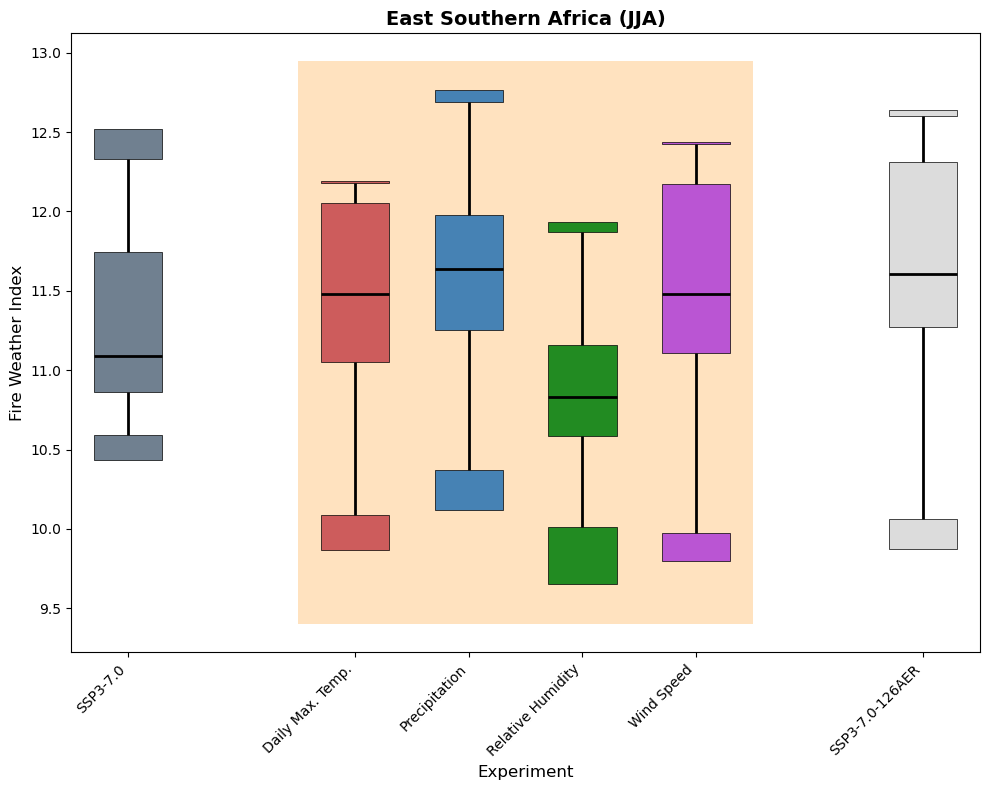

In [112]:
data_arrays = [ssp370_FWI_jja_esaf_avg, global_tasmax_FWI_jja_esaf_avg, global_pr_FWI_jja_esaf_avg, global_hurs_FWI_jja_esaf_avg, global_sfcWind_FWI_jja_esaf_avg, global_FWI_jja_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (JJA)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)


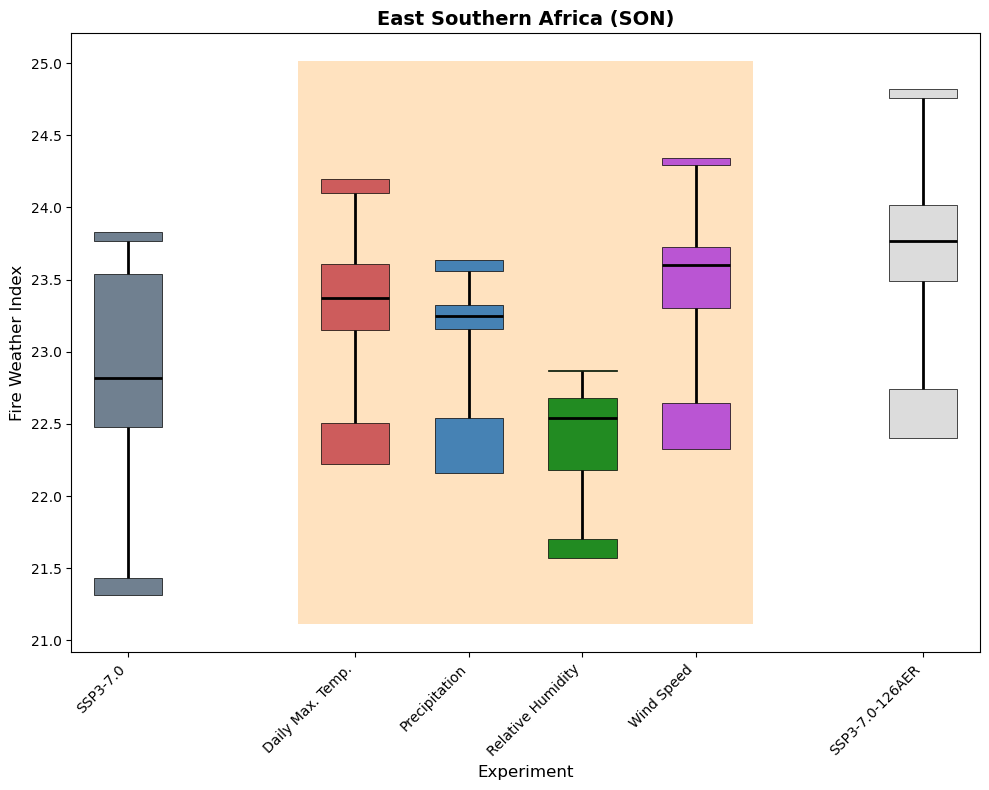

In [111]:
data_arrays = [ssp370_FWI_son_esaf_avg, global_tasmax_FWI_son_esaf_avg, global_pr_FWI_son_esaf_avg, global_hurs_FWI_son_esaf_avg, global_sfcWind_FWI_son_esaf_avg, global_FWI_son_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (SON)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

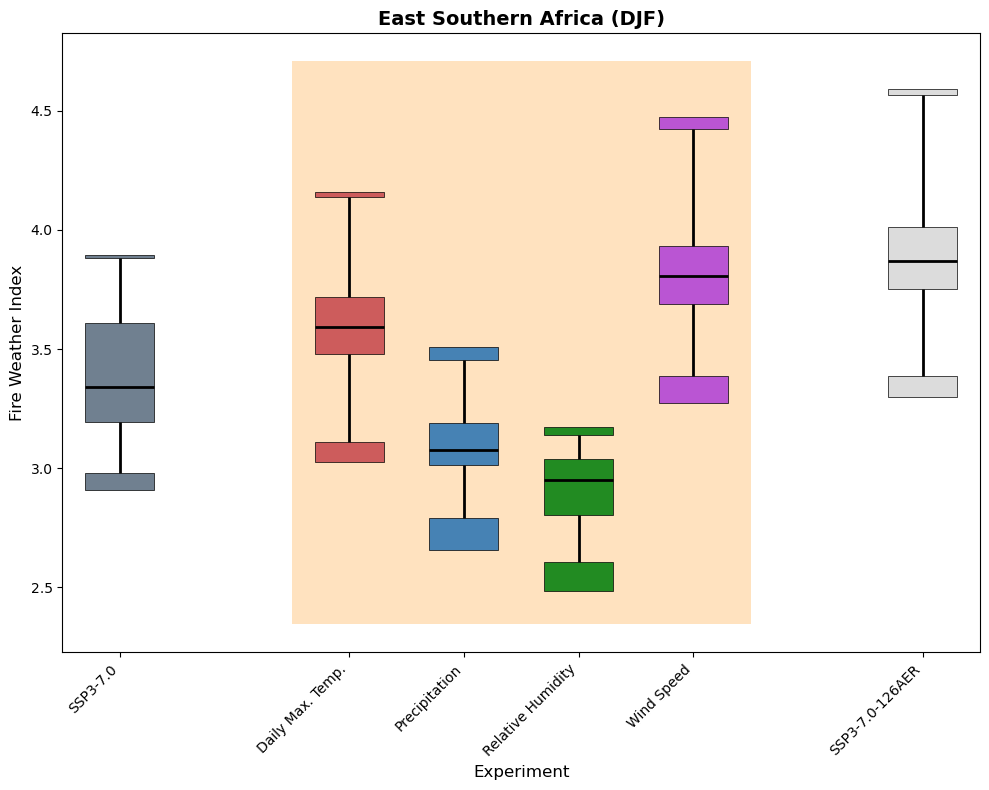

In [113]:
data_arrays = [ssp370_FWI_djf_esaf_avg, global_tasmax_FWI_djf_esaf_avg, global_pr_FWI_djf_esaf_avg, global_hurs_FWI_djf_esaf_avg, global_sfcWind_FWI_djf_esaf_avg, global_FWI_djf_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

# Custom background color and transparency
fig, ax = create_fwi_boxplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (DJF)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",  # Any color you want
    background_alpha=0.25  # Adjust transparency
)

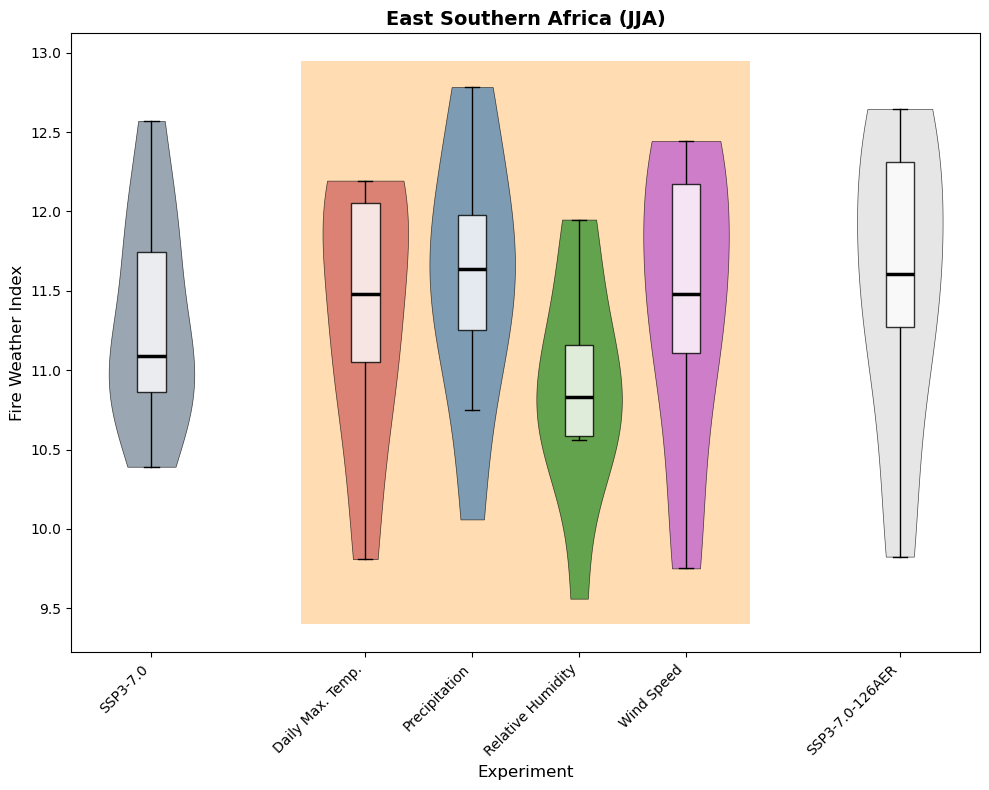

In [117]:
data_arrays = [ssp370_FWI_jja_esaf_avg, global_tasmax_FWI_jja_esaf_avg, global_pr_FWI_jja_esaf_avg, global_hurs_FWI_jja_esaf_avg, global_sfcWind_FWI_jja_esaf_avg, global_FWI_jja_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (JJA)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

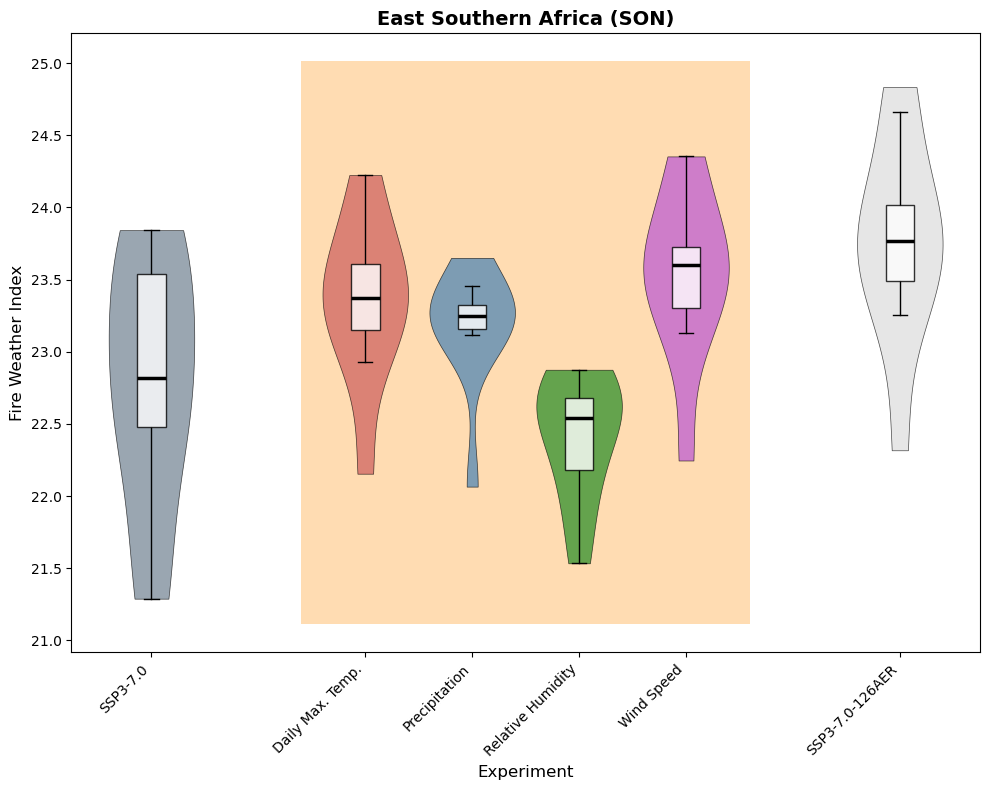

In [118]:
data_arrays = [ssp370_FWI_son_esaf_avg, global_tasmax_FWI_son_esaf_avg, global_pr_FWI_son_esaf_avg, global_hurs_FWI_son_esaf_avg, global_sfcWind_FWI_son_esaf_avg, global_FWI_son_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (SON)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

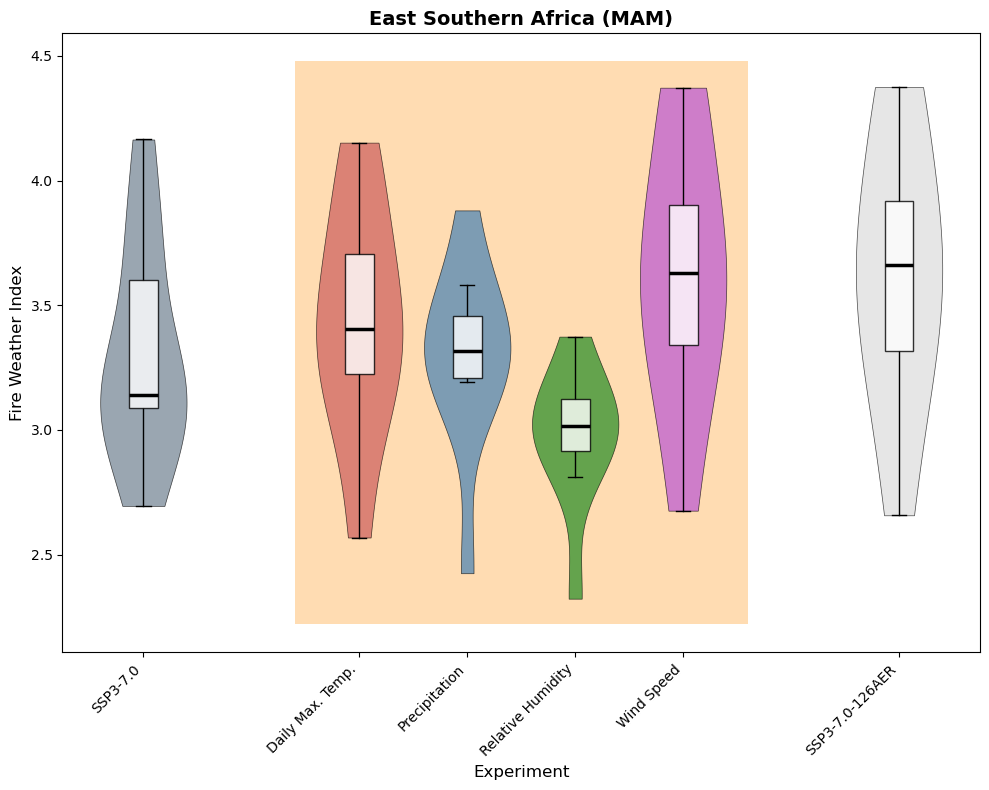

In [120]:
data_arrays = [ssp370_FWI_mam_esaf_avg, global_tasmax_FWI_mam_esaf_avg, global_pr_FWI_mam_esaf_avg, global_hurs_FWI_mam_esaf_avg, global_sfcWind_FWI_mam_esaf_avg, global_FWI_mam_esaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="East Southern Africa (MAM)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

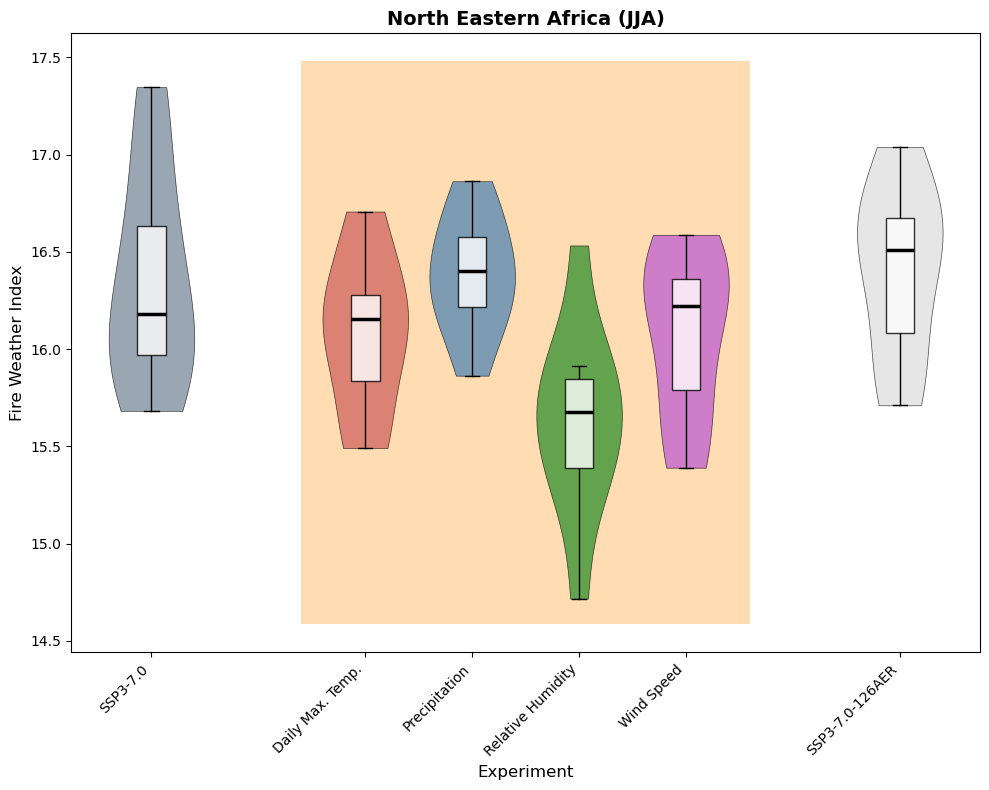

In [121]:
data_arrays = [ssp370_FWI_jja_neaf_avg, global_tasmax_FWI_jja_neaf_avg, global_pr_FWI_jja_neaf_avg, global_hurs_FWI_jja_neaf_avg, global_sfcWind_FWI_jja_neaf_avg, global_FWI_jja_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (JJA)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

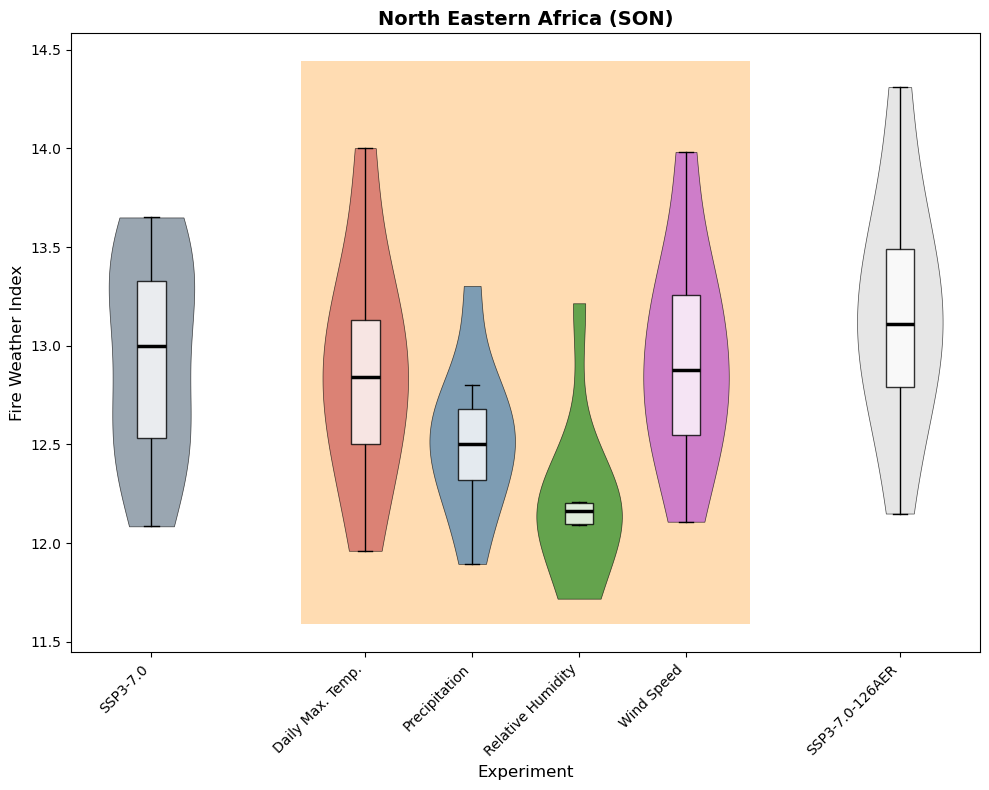

In [122]:
data_arrays = [ssp370_FWI_son_neaf_avg, global_tasmax_FWI_son_neaf_avg, global_pr_FWI_son_neaf_avg, global_hurs_FWI_son_neaf_avg, global_sfcWind_FWI_son_neaf_avg, global_FWI_son_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (SON)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

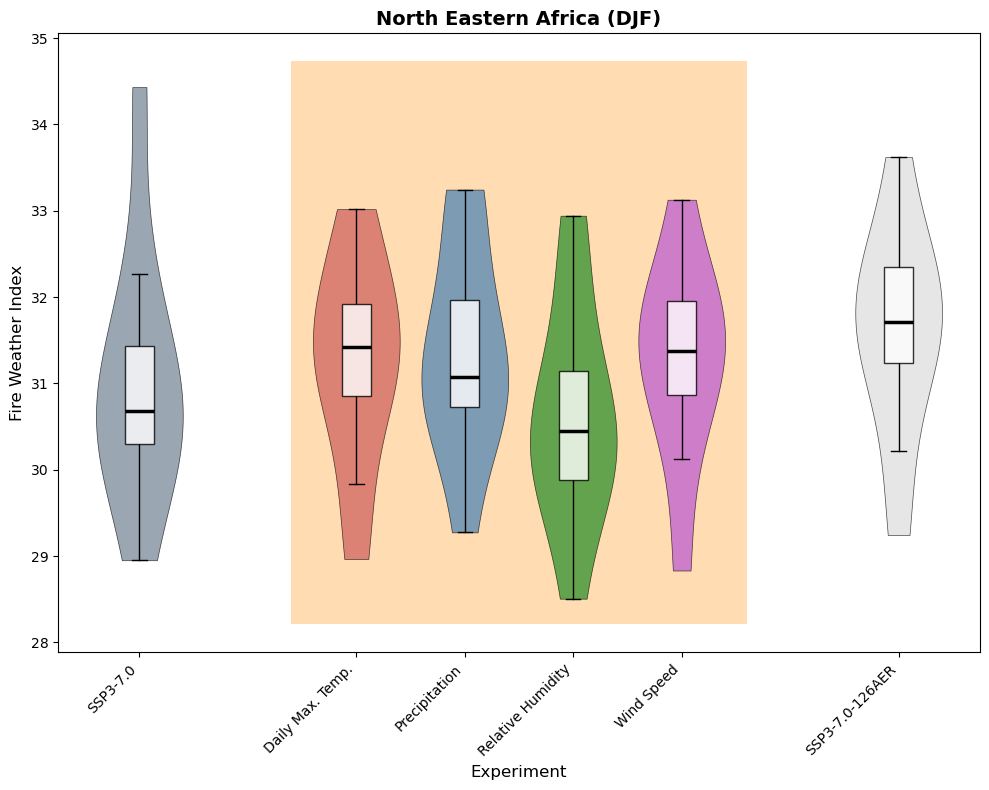

In [123]:
data_arrays = [ssp370_FWI_djf_neaf_avg, global_tasmax_FWI_djf_neaf_avg, global_pr_FWI_djf_neaf_avg, global_hurs_FWI_djf_neaf_avg, global_sfcWind_FWI_djf_neaf_avg, global_FWI_djf_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (DJF)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)

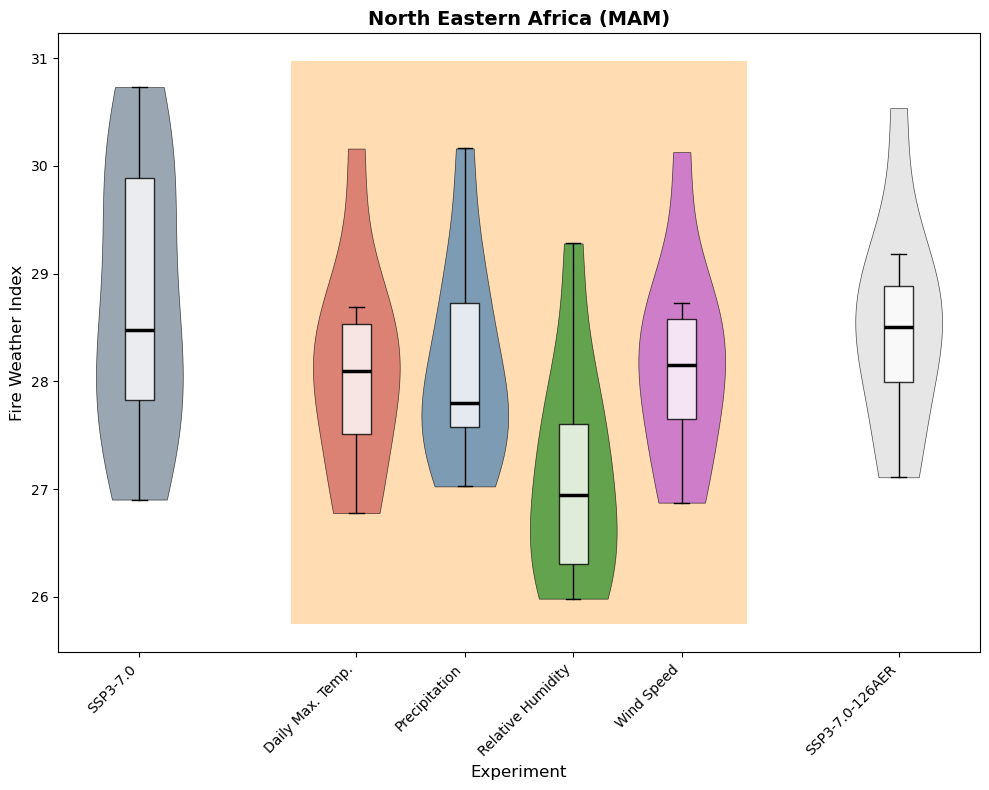

In [124]:
data_arrays = [ssp370_FWI_mam_neaf_avg, global_tasmax_FWI_mam_neaf_avg, global_pr_FWI_mam_neaf_avg, global_hurs_FWI_mam_neaf_avg, global_sfcWind_FWI_mam_neaf_avg, global_FWI_mam_neaf_avg]
labels = ['SSP3-7.0', 'Daily Max. Temp.', 'Precipitation', 'Relative Humidity', 'Wind Speed', 'SSP3-7.0-126AER']

fig, ax = create_fwi_violinplots_with_background(
    data_arrays,
    labels=labels,
    title="North Eastern Africa (MAM)",
    spacing_pattern="isolated_ends",
    background_color="darkorange",
    violin_style="filled",  # or "outline"
    show_box_inside=True   # Add small box plots inside
)